This is a notebook dedicated to investigating the properties of CHE stars on the MS from MESA output.

### Prelude

In [1]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D

import astropy.units as u
import astropy.constants as ct
from astropy.cosmology import WMAP9
from scipy.signal import find_peaks

import mesa_reader as mr

import sys
sys.path.append('..')
from src.constants import (Z_SUN, MASS_U, PERIOD_U, AGE_U, SMA_U, RADIUS_U, TEMP_U, LUMINOSITY_U, 
                           T_H)
from src.star import eggleton_rl1_radius, marchant_l2_radius, a_from_p, p_from_a

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <

In [2]:
plt.style.use('./plotstyle.mplstyle')

### References

Gottlieb, O., Renzo, M., Metzger, B. D., Goldberg, J. A. & Cantiello, M., *She's got her mother's hair: end-to-end collapsar simulations unveil the origin of black holes' magnetic field*, 2024, [arXiv:2407.16745](https://ui.adsabs.harvard.edu/abs/2024arXiv240716745G/abstract)  
Nugis, T. & Lamers, H. J. G. L. M., *Mass-loss rates of Wolf-Rayet stars as a function of stellar parameters*, 2000, [A&A 360, 227](https://ui.adsabs.harvard.edu/abs/2000A%26A...360..227N/abstract)  
Vink, J. S., de Koter, A. & Lamers, H. J. G. L. M., *New theoretical mass-loss rates of O and B Stars*, 2000, [A&A, 362, 295](https://ui.adsabs.harvard.edu/abs/2000A%26A...362..295V/abstract)

### Definitions

In [3]:
mix_dict = dict(
    crystallized=-1,
    none=0,
    convective=1,
    overshoot=2,
    semiconvective=3,
    thermohaline=4,
    rotation=5,
    rayleigh_taylor=6,
    minimum=7,
    anonymous=8,
    leftover=9,
    phase_sep=10
    )
mix_dict = {v: k for k, v in mix_dict.items()}

In [4]:
def get_model_dict(grid_folder):
    d = dict()
    for model_folder in grid_folder.glob('m*_w*'):
        if model_folder.suffix == '.log':
            continue
        m, w = model_folder.name.replace('d', 'e').split('_')        
        m = f'{float(m.lstrip("m")):.1f}'
        w = float(w.lstrip('w'))
        p = 2*np.pi / w / (60*60*24)
        p = f'{p:.2f}'
        if m not in d.keys():
            d[m] = dict()
        d[m][p] = model_folder
    return d

In [5]:
def monitor(w, h, axes, c, col_indices=[0, 1, 2, 3, 4, 5, 6]):
    #fig, axes = plt.subplots(1, 7, figsize=(36, 4), sharex=True)
    #fig.subplots_adjust(wspace=0.5)

    omg_ax, wct_ax, vrt_ax, mss_ax, rad_ax, lum_ax, he4_ax = col_indices 

    axes[omg_ax].plot(h.star_age/1e6, h.surf_avg_v_rot/(2*np.pi*h.radius*u.Rsun.to(u.km)/(2*np.pi)), lw=1, c=c)     
    axes[vrt_ax].plot(h.star_age/1e6, h.surf_avg_v_rot, lw=1, c=c)     
    axes[rad_ax].plot(h.star_age/1e6, h.radius, lw=1, c=c)    
    axes[wct_ax].plot(h.star_age/1e6, h.surf_avg_omega_div_omega_crit, lw=1, c=c)        
    axes[mss_ax].plot(h.star_age/1e6, h.star_mass, lw=1, c=c)    
    axes[lum_ax].plot(h.star_age/1e6, h.log_L, lw=1, c=c)    
    axes[he4_ax].plot(h.star_age/1e6, h.surface_he4, lw=1, c=c)    
    axes[he4_ax].plot(h.star_age/1e6, h.center_h1, lw=1, c=c, ls='--') 
    
    i_critrot_peaks = find_peaks(h.surf_avg_omega_div_omega_crit, height=1, distance=100, prominence=0.1)[0]
    t_critrot_peaks= h.star_age[i_critrot_peaks]/1e6
    for t in t_critrot_peaks:
        # don't plot peaks (too many in one panel)
        continue
        for ax in axes:
            y0, y1 = ax.get_ylim()
            ax.vlines(t, 0, y1, lw=1, color='k', ls='-')
            try:
                ax.vlines(h.star_age[1500]/1e6, 0, y1, lw=1, color='k', ls='--')
            except IndexError:
                pass
            ax.set_ylim(y0, y1)
            
    #axes[omg_ax].set_ylabel('$\\Omega$')
    #axes[vrt_ax].set_ylabel('$v_\\mathrm{rot}/\\mathrm{km}\\,\\mathrm{s}^{-1}$')
    #axes[rad_ax].set_ylabel('$R/\\mathrm{R}_\\odot$')
    #axes[wct_ax].set_ylabel('$\\Omega/\\Omega_\\mathrm{crit}$')
    #axes[mss_ax].set_ylabel('$M/\\mathrm{M}_\\odot$')
    #axes[lum_ax].set_ylabel('$L/\\mathrm{L}_\\odot$')
    #axes[he4_ax].set_ylabel('S.He4 / C. H1')
    
    if h.center_h1[-1] < 1e-7:
        status = 'DONE'
    else:
        status = 'RUNNING'
        
    p = 2 * np.pi / float(w) / (24*60*60)
    handle = Line2D((-1, -1), (-1, -1), linestyle='-', color=c, 
                    label=f'${p:.2f}\\,\\mathrm{{d}}$ ({np.log10(h.center_h1[-1]):.1f}, {len(h.star_age)} steps)')
    #axes[3].text(0.5, 1.1, f'$m={m:.1f}\\,\\mathrm{{M}}_\\odot, P={p:.2f}\\,\\mathrm{{d}}, \\Omega={w:.1e}\\,\\mathrm{{rad}}\\,\\mathrm{{s}}^{{-1}},$ {len(h.star_age)} steps ({status})', 
    #             rotation=0, va='center', ha='right', fontsize=28, transform=axes[3].transAxes)   
    
    return axes, handle

### Analysis

In [6]:
ROOT = Path.cwd().parent
GRID_FOLDER = ROOT/'mesa/sse_che_window_test/new_models_test'

In [ ]:
model_dict = get_model_dict(GRID_FOLDER)
model_dict

{'180.0': {'4.04': PosixPath('/mnt/home/ldesa/repos/cher/mesa/sse_che_window_test/new_models_test/m1.8d+02_w1.8d-05')},
 '39.0': {'1.28': PosixPath('/mnt/home/ldesa/repos/cher/mesa/sse_che_window_test/new_models_test/m3.9d+01_w5.7d-05'),
  '0.89': PosixPath('/mnt/home/ldesa/repos/cher/mesa/sse_che_window_test/new_models_test/m3.9d+01_w8.2d-05')},
 '65.0': {'1.65': PosixPath('/mnt/home/ldesa/repos/cher/mesa/sse_che_window_test/new_models_test/m6.5d+01_w4.4d-05'),
  '2.80': PosixPath('/mnt/home/ldesa/repos/cher/mesa/sse_che_window_test/new_models_test/m6.5d+01_w2.6d-05')},
 '14.0': {'0.48': PosixPath('/mnt/home/ldesa/repos/cher/mesa/sse_che_window_test/new_models_test/m1.4d+01_w1.5d-04')}}

### Cases of interest

In [8]:
from matplotlib.patches import Patch

Text(0.5, 0.05, 'Age/Myr')

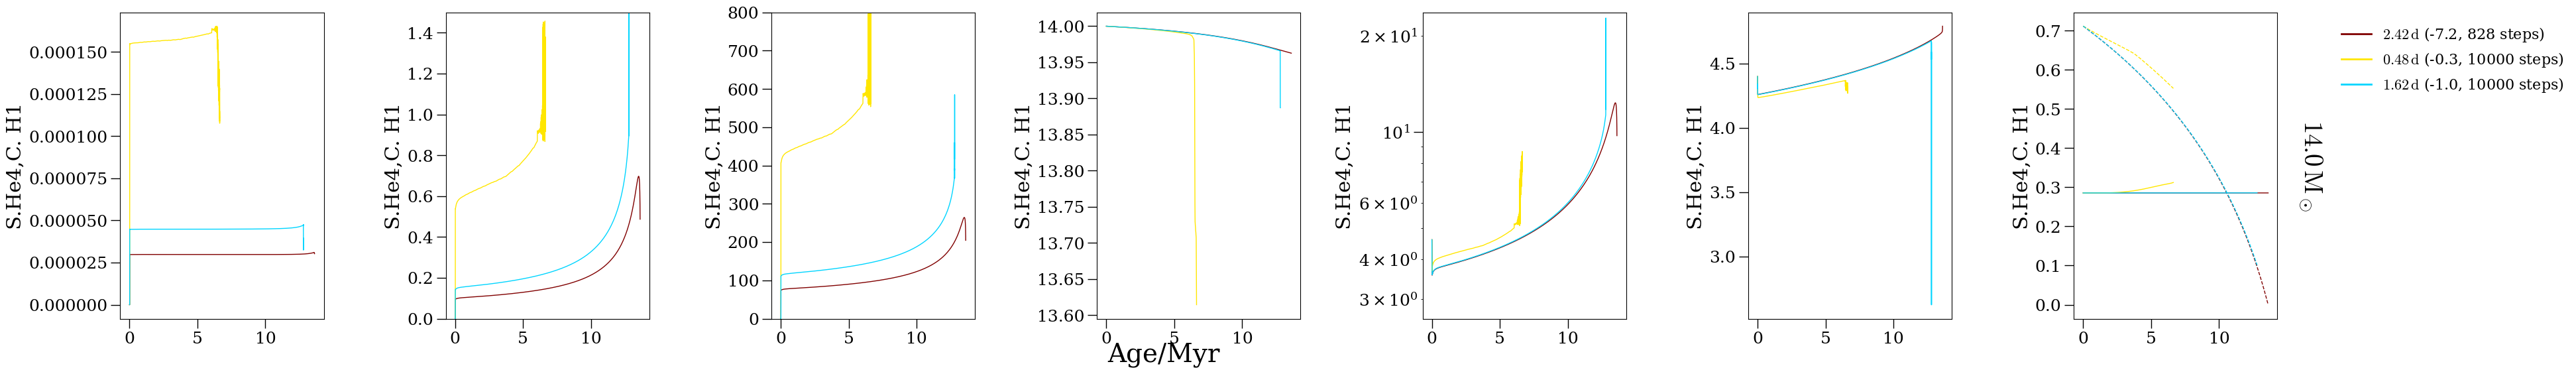

In [9]:
m_key = '14.0'

cmap = cm.jet_r
col_indices = [0, 1, 2, 3, 4, 5, 6]
col_labels = ['$\\Omega$',
              '$\\Omega/\\Omega_\\mathrm{crit}$',
              '$v_\\mathrm{rot}/\\mathrm{km}\\,\\mathrm{s}^{-1}$',
              '$M/\\mathrm{M}_\\odot$',
              '$R/\\mathrm{R}_\\odot$',
              '$\\log L/\\mathrm{L}_\\odot$',
              'S.He4,C. H1']
n_cols = len(col_labels)
fig, axes = plt.subplots(1, n_cols, figsize=(42, 6), sharex='row')
fig.subplots_adjust(wspace=0.6, hspace=0.3)

p_models = model_dict[m_key]
legend_handles = list()
for p_i, p in enumerate(list(p_models.keys())):
    c = cmap(p_i/len(list(p_models.keys())))
    model = p_models[p]
    w = 2*np.pi / (float(p) * 24 * 60 * 60)
    try:
        h = mr.MesaData(str(model/'LOGS/history.data'))
    except:
        continue
    axes, handle = monitor(w, h, axes, c=c, col_indices=col_indices)
    legend_handles.append(handle)    

axes[-1].text(1.1, 0.5, f'${float(m_key):.1f}\\,\\mathrm{{M}}_\\odot$', ha='left', va='center', 
            rotation=-90, transform=axes[-1].transAxes, fontsize=28)
axes[-1].legend(handles=legend_handles, frameon=False, loc='upper left', 
                bbox_to_anchor=(1.25, 1), fontsize=16, ncol=1)

for i, label in zip(col_indices, col_labels):
    for ax in axes:
        ax.set_ylabel(label, fontsize=22)

# stars that "blow up" due to attempting to impose hyper-critical reach 
# values so high for some of the parameters that they squeeze down the
# curves for normal evolution
# we set some convenient upper limits to allow for proper visualization
axes[col_indices[1]].set_ylim(0, min(1.5, axes[col_indices[1]].get_ylim()[1]))  # omega_div_omega_crit
axes[col_indices[2]].set_ylim(0, min(800, axes[col_indices[2]].get_ylim()[1]))  # surf_avg_v_rot
axes[col_indices[4]].set_ylim(max(1.5, axes[col_indices[4]].get_ylim()[0]), min(60, axes[col_indices[4]].get_ylim()[1]))  # radius
axes[col_indices[4]].set_yscale('log')

fig.text(0.5, 0.05, 'Age/Myr', ha='center', va='top', transform=fig.transFigure)
#fig.text(0.15, 0.9, 'All $x$ axes: Age/Myr', ha='center', va='bottom', transform=fig.transFigure)

#fig.savefig('figures/full_monitor_panel.pdf', bbox_inches='tight')
#fig.savefig('figures/full_monitor_panel.png', bbox_inches='tight')   
        

Text(0.5, 0.05, 'Age/Myr')

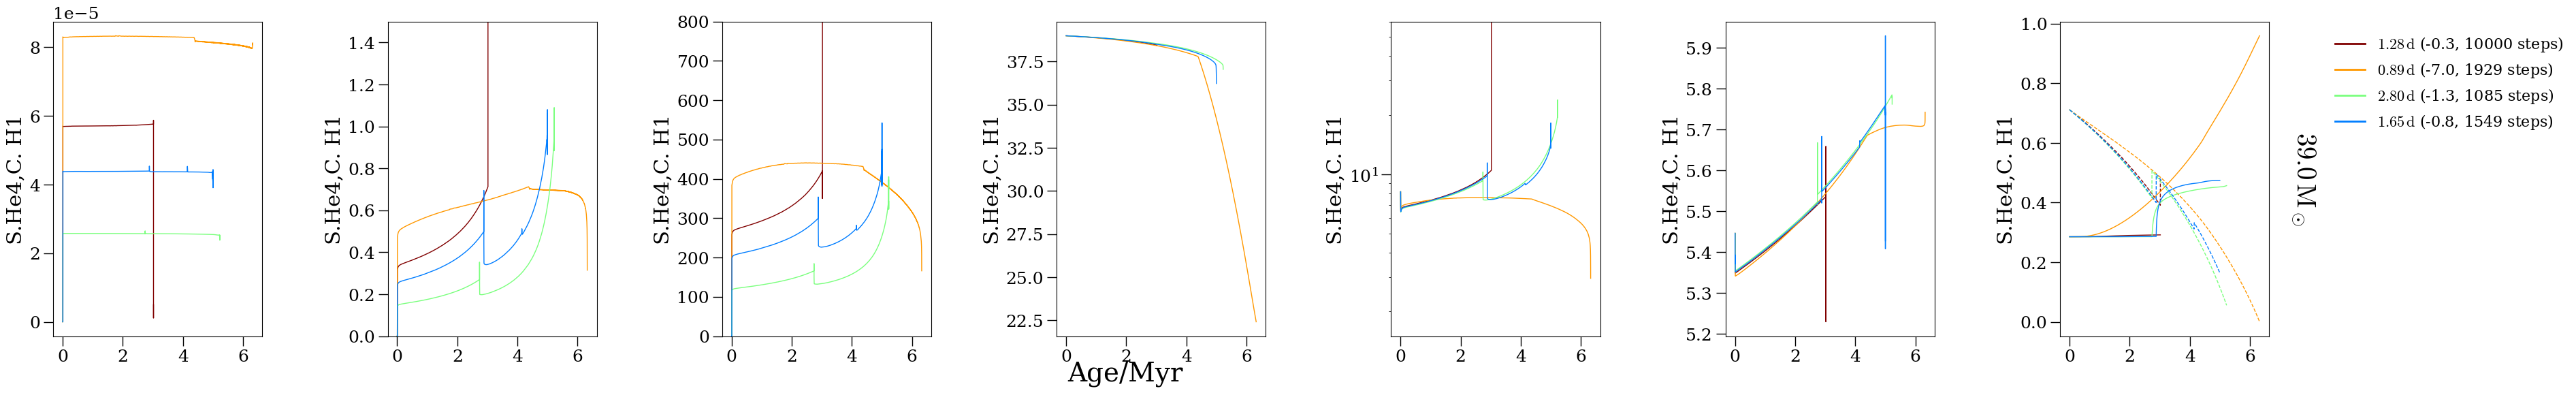

In [11]:
m_key = '39.0'

cmap = cm.jet_r
col_indices = [0, 1, 2, 3, 4, 5, 6]
col_labels = ['$\\Omega$',
              '$\\Omega/\\Omega_\\mathrm{crit}$',
              '$v_\\mathrm{rot}/\\mathrm{km}\\,\\mathrm{s}^{-1}$',
              '$M/\\mathrm{M}_\\odot$',
              '$R/\\mathrm{R}_\\odot$',
              '$\\log L/\\mathrm{L}_\\odot$',
              'S.He4,C. H1']
n_cols = len(col_labels)
fig, axes = plt.subplots(1, n_cols, figsize=(42, 6), sharex='row')
fig.subplots_adjust(wspace=0.6, hspace=0.3)

p_models = model_dict[m_key]
legend_handles = list()
for p_i, p in enumerate(list(p_models.keys())):
    c = cmap(p_i/len(list(p_models.keys())))
    model = p_models[p]
    w = 2*np.pi / (float(p) * 24 * 60 * 60)
    try:
        h = mr.MesaData(str(model/'LOGS/history.data'))
    except:
        continue
    axes, handle = monitor(w, h, axes, c=c, col_indices=col_indices)
    legend_handles.append(handle)    

axes[-1].text(1.1, 0.5, f'${float(m_key):.1f}\\,\\mathrm{{M}}_\\odot$', ha='left', va='center', 
            rotation=-90, transform=axes[-1].transAxes, fontsize=28)
axes[-1].legend(handles=legend_handles, frameon=False, loc='upper left', 
                bbox_to_anchor=(1.25, 1), fontsize=16, ncol=1)

for i, label in zip(col_indices, col_labels):
    for ax in axes:
        ax.set_ylabel(label, fontsize=22)

# stars that "blow up" due to attempting to impose hyper-critical reach 
# values so high for some of the parameters that they squeeze down the
# curves for normal evolution
# we set some convenient upper limits to allow for proper visualization
axes[col_indices[1]].set_ylim(0, min(1.5, axes[col_indices[1]].get_ylim()[1]))  # omega_div_omega_crit
axes[col_indices[2]].set_ylim(0, min(800, axes[col_indices[2]].get_ylim()[1]))  # surf_avg_v_rot
axes[col_indices[4]].set_ylim(max(1.5, axes[col_indices[4]].get_ylim()[0]), min(60, axes[col_indices[4]].get_ylim()[1]))  # radius
axes[col_indices[4]].set_yscale('log')

fig.text(0.5, 0.05, 'Age/Myr', ha='center', va='top', transform=fig.transFigure)
#fig.text(0.15, 0.9, 'All $x$ axes: Age/Myr', ha='center', va='bottom', transform=fig.transFigure)

#fig.savefig('figures/full_monitor_panel.pdf', bbox_inches='tight')
#fig.savefig('figures/full_monitor_panel.png', bbox_inches='tight')   
        

Text(0.5, 0.05, 'Age/Myr')

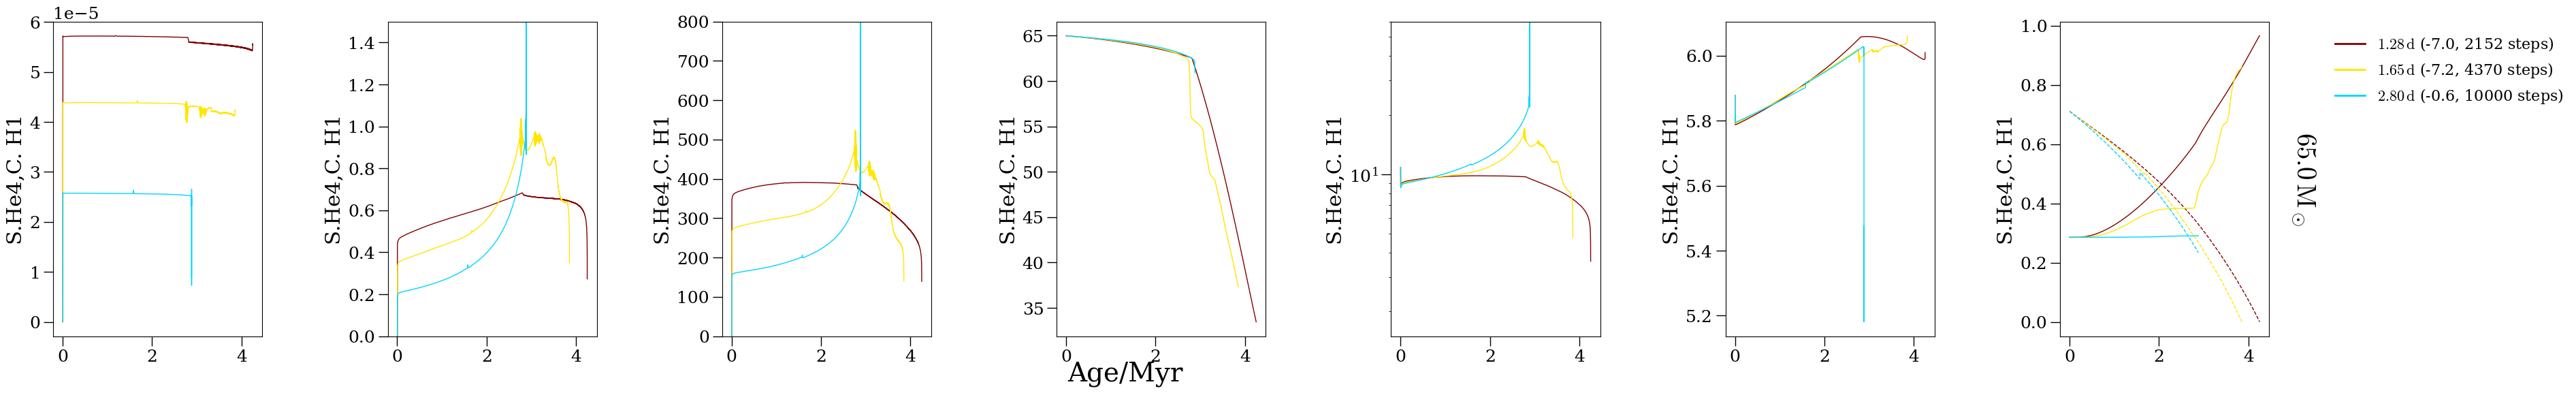

In [12]:
m_key = '65.0'

cmap = cm.jet_r
col_indices = [0, 1, 2, 3, 4, 5, 6]
col_labels = ['$\\Omega$',
              '$\\Omega/\\Omega_\\mathrm{crit}$',
              '$v_\\mathrm{rot}/\\mathrm{km}\\,\\mathrm{s}^{-1}$',
              '$M/\\mathrm{M}_\\odot$',
              '$R/\\mathrm{R}_\\odot$',
              '$\\log L/\\mathrm{L}_\\odot$',
              'S.He4,C. H1']
n_cols = len(col_labels)
fig, axes = plt.subplots(1, n_cols, figsize=(42, 6), sharex='row')
fig.subplots_adjust(wspace=0.6, hspace=0.3)

p_models = model_dict[m_key]
legend_handles = list()
for p_i, p in enumerate(list(p_models.keys())):
    c = cmap(p_i/len(list(p_models.keys())))
    model = p_models[p]
    w = 2*np.pi / (float(p) * 24 * 60 * 60)
    try:
        h = mr.MesaData(str(model/'LOGS/history.data'))
    except:
        continue
    axes, handle = monitor(w, h, axes, c=c, col_indices=col_indices)
    legend_handles.append(handle)    

axes[-1].text(1.1, 0.5, f'${float(m_key):.1f}\\,\\mathrm{{M}}_\\odot$', ha='left', va='center', 
            rotation=-90, transform=axes[-1].transAxes, fontsize=28)
axes[-1].legend(handles=legend_handles, frameon=False, loc='upper left', 
                bbox_to_anchor=(1.25, 1), fontsize=16, ncol=1)

for i, label in zip(col_indices, col_labels):
    for ax in axes:
        ax.set_ylabel(label, fontsize=22)

# stars that "blow up" due to attempting to impose hyper-critical reach 
# values so high for some of the parameters that they squeeze down the
# curves for normal evolution
# we set some convenient upper limits to allow for proper visualization
axes[col_indices[1]].set_ylim(0, min(1.5, axes[col_indices[1]].get_ylim()[1]))  # omega_div_omega_crit
axes[col_indices[2]].set_ylim(0, min(800, axes[col_indices[2]].get_ylim()[1]))  # surf_avg_v_rot
axes[col_indices[4]].set_ylim(max(1.5, axes[col_indices[4]].get_ylim()[0]), min(60, axes[col_indices[4]].get_ylim()[1]))  # radius
axes[col_indices[4]].set_yscale('log')

fig.text(0.5, 0.05, 'Age/Myr', ha='center', va='top', transform=fig.transFigure)
#fig.text(0.15, 0.9, 'All $x$ axes: Age/Myr', ha='center', va='bottom', transform=fig.transFigure)

#fig.savefig('figures/full_monitor_panel.pdf', bbox_inches='tight')
#fig.savefig('figures/full_monitor_panel.png', bbox_inches='tight')   
        

Text(0.5, 0.05, 'Age/Myr')

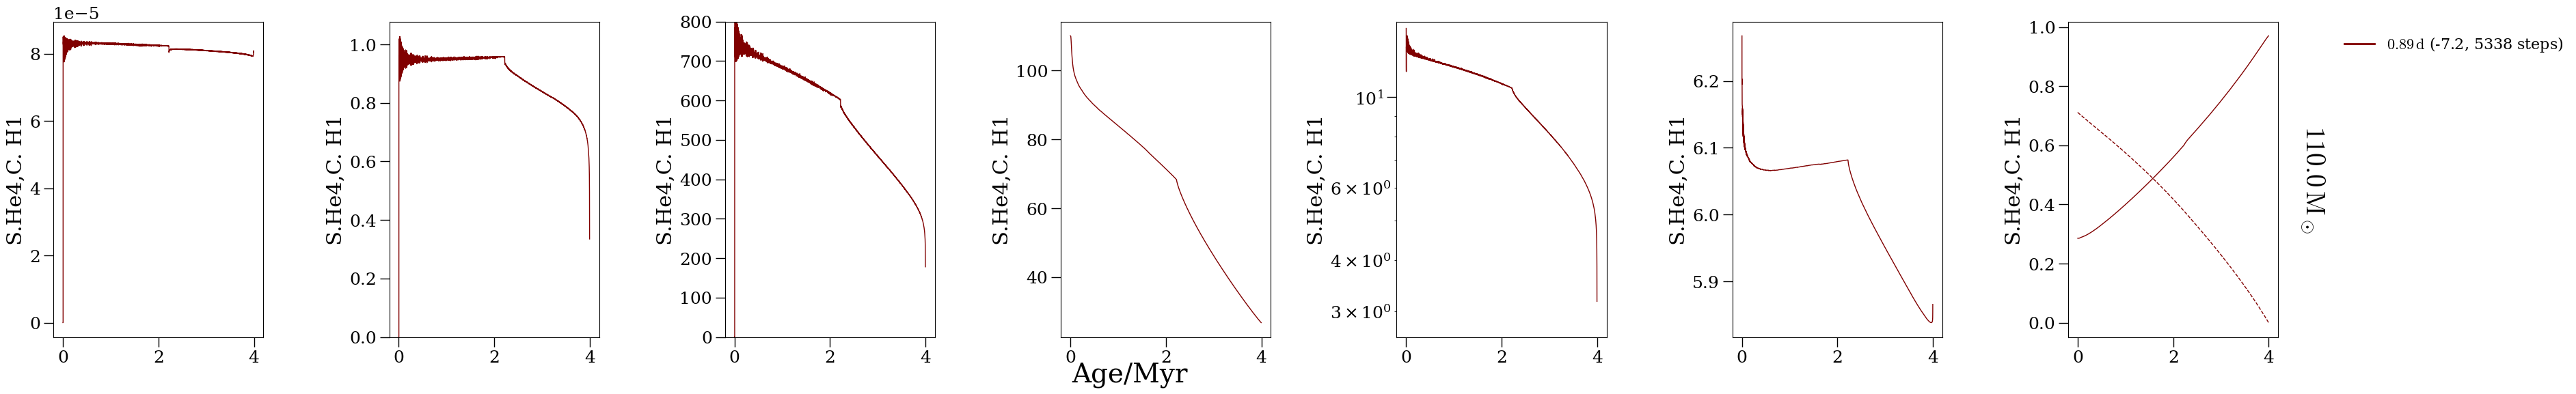

In [13]:
m_key = '110.0'

cmap = cm.jet_r
col_indices = [0, 1, 2, 3, 4, 5, 6]
col_labels = ['$\\Omega$',
              '$\\Omega/\\Omega_\\mathrm{crit}$',
              '$v_\\mathrm{rot}/\\mathrm{km}\\,\\mathrm{s}^{-1}$',
              '$M/\\mathrm{M}_\\odot$',
              '$R/\\mathrm{R}_\\odot$',
              '$\\log L/\\mathrm{L}_\\odot$',
              'S.He4,C. H1']
n_cols = len(col_labels)
fig, axes = plt.subplots(1, n_cols, figsize=(42, 6), sharex='row')
fig.subplots_adjust(wspace=0.6, hspace=0.3)

p_models = model_dict[m_key]
legend_handles = list()
for p_i, p in enumerate(list(p_models.keys())):
    c = cmap(p_i/len(list(p_models.keys())))
    model = p_models[p]
    w = 2*np.pi / (float(p) * 24 * 60 * 60)
    try:
        h = mr.MesaData(str(model/'LOGS/history.data'))
    except:
        continue
    axes, handle = monitor(w, h, axes, c=c, col_indices=col_indices)
    legend_handles.append(handle)    

axes[-1].text(1.1, 0.5, f'${float(m_key):.1f}\\,\\mathrm{{M}}_\\odot$', ha='left', va='center', 
            rotation=-90, transform=axes[-1].transAxes, fontsize=28)
axes[-1].legend(handles=legend_handles, frameon=False, loc='upper left', 
                bbox_to_anchor=(1.25, 1), fontsize=16, ncol=1)

for i, label in zip(col_indices, col_labels):
    for ax in axes:
        ax.set_ylabel(label, fontsize=22)

# stars that "blow up" due to attempting to impose hyper-critical reach 
# values so high for some of the parameters that they squeeze down the
# curves for normal evolution
# we set some convenient upper limits to allow for proper visualization
axes[col_indices[1]].set_ylim(0, min(1.5, axes[col_indices[1]].get_ylim()[1]))  # omega_div_omega_crit
axes[col_indices[2]].set_ylim(0, min(800, axes[col_indices[2]].get_ylim()[1]))  # surf_avg_v_rot
axes[col_indices[4]].set_ylim(max(1.5, axes[col_indices[4]].get_ylim()[0]), min(60, axes[col_indices[4]].get_ylim()[1]))  # radius
axes[col_indices[4]].set_yscale('log')

fig.text(0.5, 0.05, 'Age/Myr', ha='center', va='top', transform=fig.transFigure)
#fig.text(0.15, 0.9, 'All $x$ axes: Age/Myr', ha='center', va='bottom', transform=fig.transFigure)

#fig.savefig('figures/full_monitor_panel.pdf', bbox_inches='tight')
#fig.savefig('figures/full_monitor_panel.png', bbox_inches='tight')   
        

Text(0.5, 0.05, 'Age/Myr')

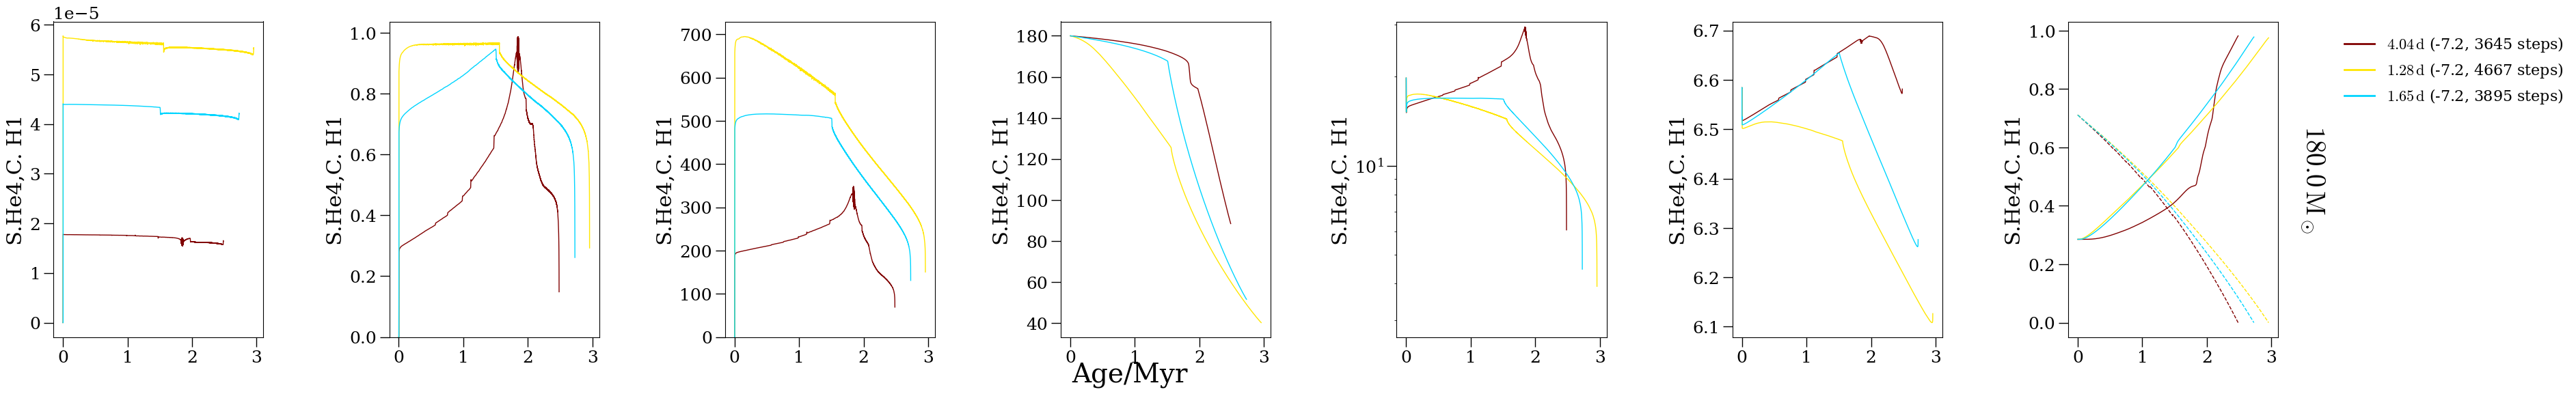

In [14]:
m_key = '180.0'

cmap = cm.jet_r
col_indices = [0, 1, 2, 3, 4, 5, 6]
col_labels = ['$\\Omega$',
              '$\\Omega/\\Omega_\\mathrm{crit}$',
              '$v_\\mathrm{rot}/\\mathrm{km}\\,\\mathrm{s}^{-1}$',
              '$M/\\mathrm{M}_\\odot$',
              '$R/\\mathrm{R}_\\odot$',
              '$\\log L/\\mathrm{L}_\\odot$',
              'S.He4,C. H1']
n_cols = len(col_labels)
fig, axes = plt.subplots(1, n_cols, figsize=(42, 6), sharex='row')
fig.subplots_adjust(wspace=0.6, hspace=0.3)

p_models = model_dict[m_key]
legend_handles = list()
for p_i, p in enumerate(list(p_models.keys())):
    c = cmap(p_i/len(list(p_models.keys())))
    model = p_models[p]
    w = 2*np.pi / (float(p) * 24 * 60 * 60)
    try:
        h = mr.MesaData(str(model/'LOGS/history.data'))
    except:
        continue
    axes, handle = monitor(w, h, axes, c=c, col_indices=col_indices)
    legend_handles.append(handle)    

axes[-1].text(1.1, 0.5, f'${float(m_key):.1f}\\,\\mathrm{{M}}_\\odot$', ha='left', va='center', 
            rotation=-90, transform=axes[-1].transAxes, fontsize=28)
axes[-1].legend(handles=legend_handles, frameon=False, loc='upper left', 
                bbox_to_anchor=(1.25, 1), fontsize=16, ncol=1)

for i, label in zip(col_indices, col_labels):
    for ax in axes:
        ax.set_ylabel(label, fontsize=22)

# stars that "blow up" due to attempting to impose hyper-critical reach 
# values so high for some of the parameters that they squeeze down the
# curves for normal evolution
# we set some convenient upper limits to allow for proper visualization
axes[col_indices[1]].set_ylim(0, min(1.5, axes[col_indices[1]].get_ylim()[1]))  # omega_div_omega_crit
axes[col_indices[2]].set_ylim(0, min(800, axes[col_indices[2]].get_ylim()[1]))  # surf_avg_v_rot
axes[col_indices[4]].set_ylim(max(1.5, axes[col_indices[4]].get_ylim()[0]), min(60, axes[col_indices[4]].get_ylim()[1]))  # radius
axes[col_indices[4]].set_yscale('log')

fig.text(0.5, 0.05, 'Age/Myr', ha='center', va='top', transform=fig.transFigure)
#fig.text(0.15, 0.9, 'All $x$ axes: Age/Myr', ha='center', va='bottom', transform=fig.transFigure)

#fig.savefig('figures/full_monitor_panel.pdf', bbox_inches='tight')
#fig.savefig('figures/full_monitor_panel.png', bbox_inches='tight')   
        

## Kippenhahn diagrams

In [16]:
m_key = '14.0'
p_key = '0.48'
model = model_dict[m_key][p_key]
h = mr.MesaData(str(model/'LOGS/history.data'))
profiles = mr.MesaLogDir(str(model/'LOGS'))

Text(0.5, 1.0, 'M=14.0, P=0.48')

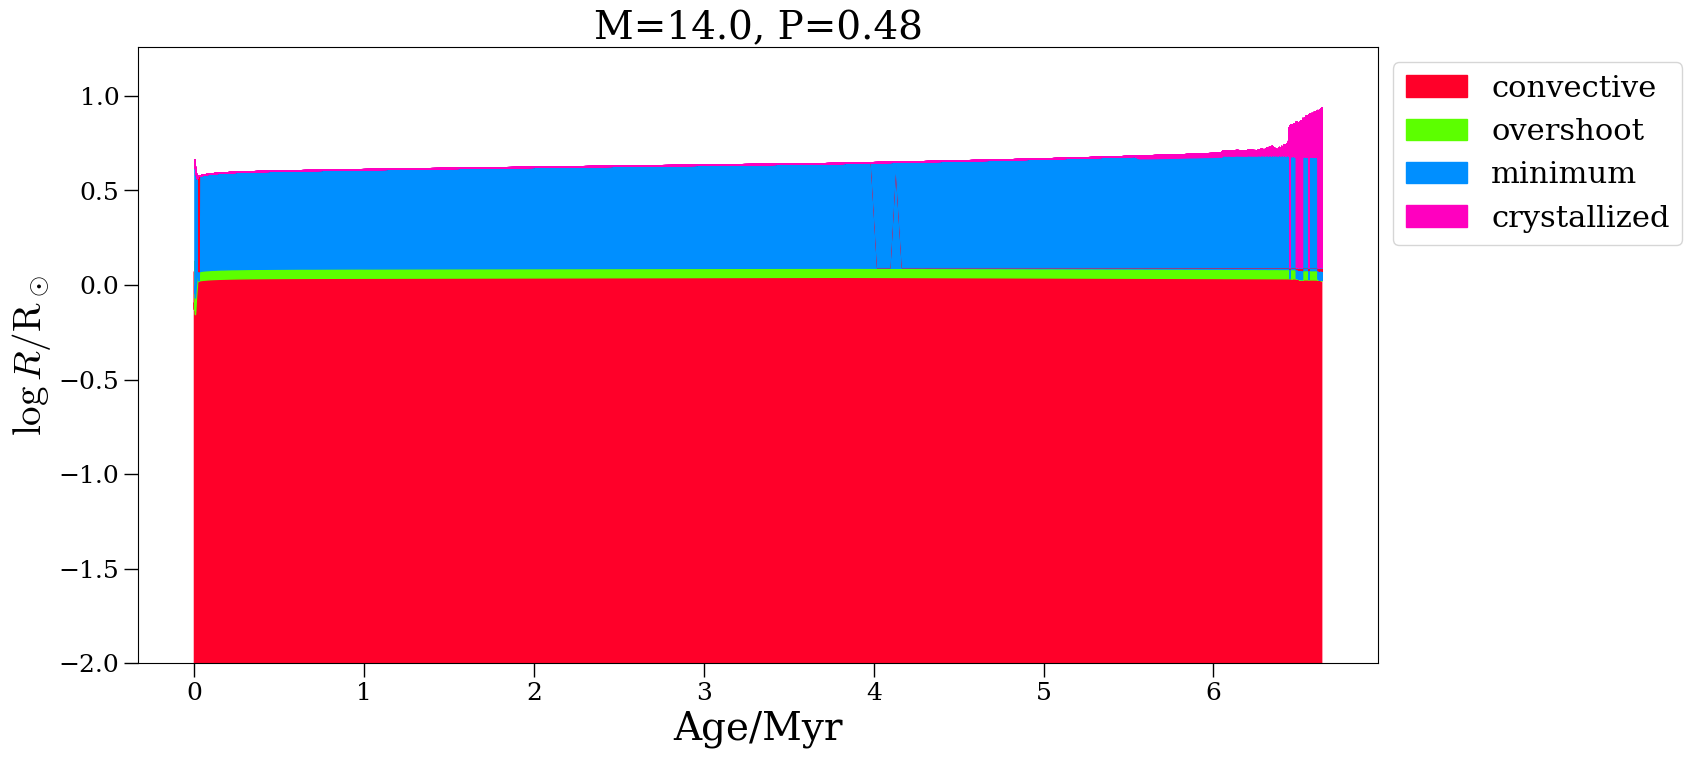

In [17]:
fig, ax = plt.subplots(figsize=(16, 8))
cmap = cm.gist_rainbow

t = h.star_age/1e6
r = h.radius
n_mix_regions = 20

types_to_label = []
for i in range(1, n_mix_regions+1):
    type_col = f'mix_relr_type_{i}'
    type_code = h.__getattr__(type_col)[0]
    if type_code not in types_to_label:
        types_to_label.append(type_code)

colors = cmap(np.linspace(0, 1, len(types_to_label)))
    
bottom = np.ones(len(r))*1e-6


for i in range(1, n_mix_regions+1):
    type_col = f'mix_relr_type_{i}'
    top_col = f'mix_relr_top_{i}'
    type_code = h.__getattr__(type_col)[0]
    typ = mix_dict[type_code]
    top = h.__getattr__(top_col)
    
    i_c = types_to_label.index(type_code)
    c = colors[i_c]
    
    #c = cmap(type_code/12)
    ax.fill_between(t, np.log10(bottom*r), np.log10(top*r), color=c)
    #ax.plot(t, np.log10(top*r), lw=0.5, alpha=0.1, c='k')
    
    bottom = top
    
    
ax.set_xlabel('Age/Myr')
ax.set_ylabel('$\\log R/\\mathrm{R}_\\odot$')
ax.set_ylim(-2)

handles = []
for type, c in zip(types_to_label, colors):
    handles.append(Patch(color=c, label=mix_dict[type]))
ax.legend(handles=handles, loc='upper left', bbox_to_anchor=(1,1))

ax.set_title(f'M={m_key}, P={p_key}')

In [19]:
print(h.bulk_names)

('model_number', 'num_zones', 'star_age', 'star_age_sec', 'log_dt', 'star_mass', 'log_xmstar', 'log_abs_mdot', 'mass_conv_core', 'mix_type_1', 'mix_qtop_1', 'mix_type_2', 'mix_qtop_2', 'mix_type_3', 'mix_qtop_3', 'mix_type_4', 'mix_qtop_4', 'mix_type_5', 'mix_qtop_5', 'mix_type_6', 'mix_qtop_6', 'mix_type_7', 'mix_qtop_7', 'mix_type_8', 'mix_qtop_8', 'mix_type_9', 'mix_qtop_9', 'mix_type_10', 'mix_qtop_10', 'mix_type_11', 'mix_qtop_11', 'mix_type_12', 'mix_qtop_12', 'mix_type_13', 'mix_qtop_13', 'mix_type_14', 'mix_qtop_14', 'mix_type_15', 'mix_qtop_15', 'mix_type_16', 'mix_qtop_16', 'mix_type_17', 'mix_qtop_17', 'mix_type_18', 'mix_qtop_18', 'mix_type_19', 'mix_qtop_19', 'mix_type_20', 'mix_qtop_20', 'burn_type_1', 'burn_qtop_1', 'burn_type_2', 'burn_qtop_2', 'burn_type_3', 'burn_qtop_3', 'burn_type_4', 'burn_qtop_4', 'burn_type_5', 'burn_qtop_5', 'burn_type_6', 'burn_qtop_6', 'burn_type_7', 'burn_qtop_7', 'burn_type_8', 'burn_qtop_8', 'burn_type_9', 'burn_qtop_9', 'burn_type_10', 'bu

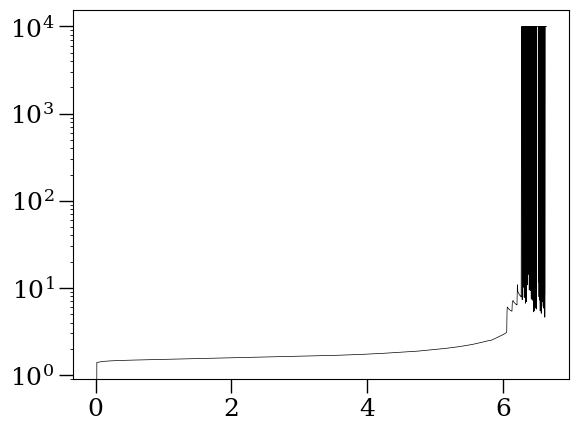

In [25]:
plt.plot(h.star_age/1e6, h.rotational_mdot_boost, 'k-', lw=0.5)
plt.yscale('log')

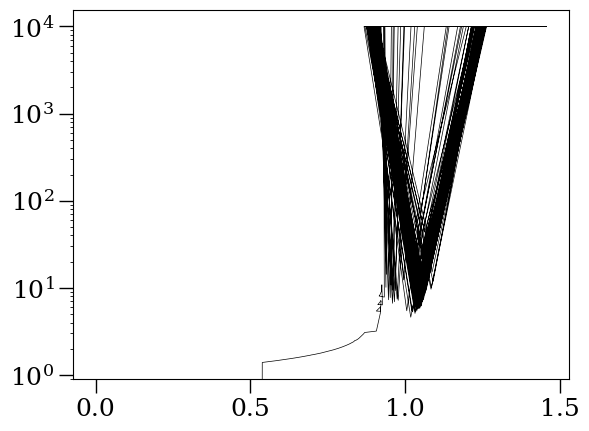

In [26]:
plt.plot(h.surf_avg_omega_div_omega_crit, h.rotational_mdot_boost, 'k-', lw=0.5)
plt.yscale('log')

Text(0.5, 1.0, 'M=39.0, P=0.89')

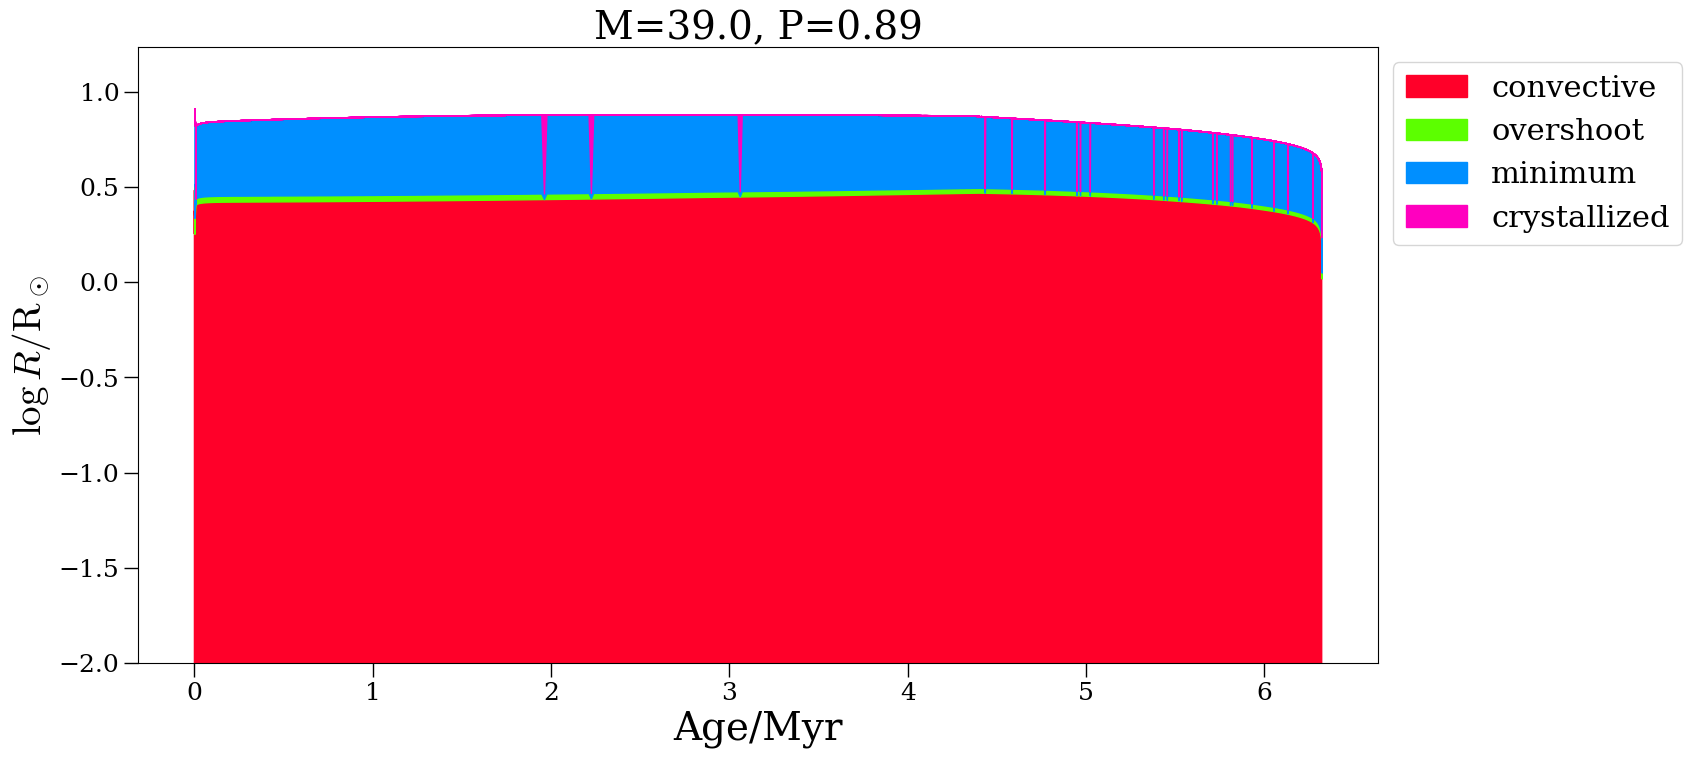

In [11]:
m_key = '39.0'
p_key = '0.89'
model = model_dict[m_key][p_key]
h = mr.MesaData(str(model/'LOGS/history.data'))
profiles = mr.MesaLogDir(str(model/'LOGS'))


fig, ax = plt.subplots(figsize=(16, 8))
cmap = cm.gist_rainbow

t = h.star_age/1e6
r = h.radius
n_mix_regions = 20

types_to_label = []
for i in range(1, n_mix_regions+1):
    type_col = f'mix_relr_type_{i}'
    type_code = h.__getattr__(type_col)[0]
    if type_code not in types_to_label:
        types_to_label.append(type_code)

colors = cmap(np.linspace(0, 1, len(types_to_label)))
    
bottom = np.ones(len(r))*1e-6


for i in range(1, n_mix_regions+1):
    type_col = f'mix_relr_type_{i}'
    top_col = f'mix_relr_top_{i}'
    type_code = h.__getattr__(type_col)[0]
    typ = mix_dict[type_code]
    top = h.__getattr__(top_col)
    
    i_c = types_to_label.index(type_code)
    c = colors[i_c]
    
    #c = cmap(type_code/12)
    ax.fill_between(t, np.log10(bottom*r), np.log10(top*r), color=c)
    #ax.plot(t, np.log10(top*r), lw=0.5, alpha=0.1, c='k')
    
    bottom = top
    
    
ax.set_xlabel('Age/Myr')
ax.set_ylabel('$\\log R/\\mathrm{R}_\\odot$')
ax.set_ylim(-2)

handles = []
for type, c in zip(types_to_label, colors):
    handles.append(Patch(color=c, label=mix_dict[type]))
ax.legend(handles=handles, loc='upper left', bbox_to_anchor=(1,1))

ax.set_title(f'M={m_key}, P={p_key}')

Text(0.5, 1.0, 'M=110.0, P=0.89')

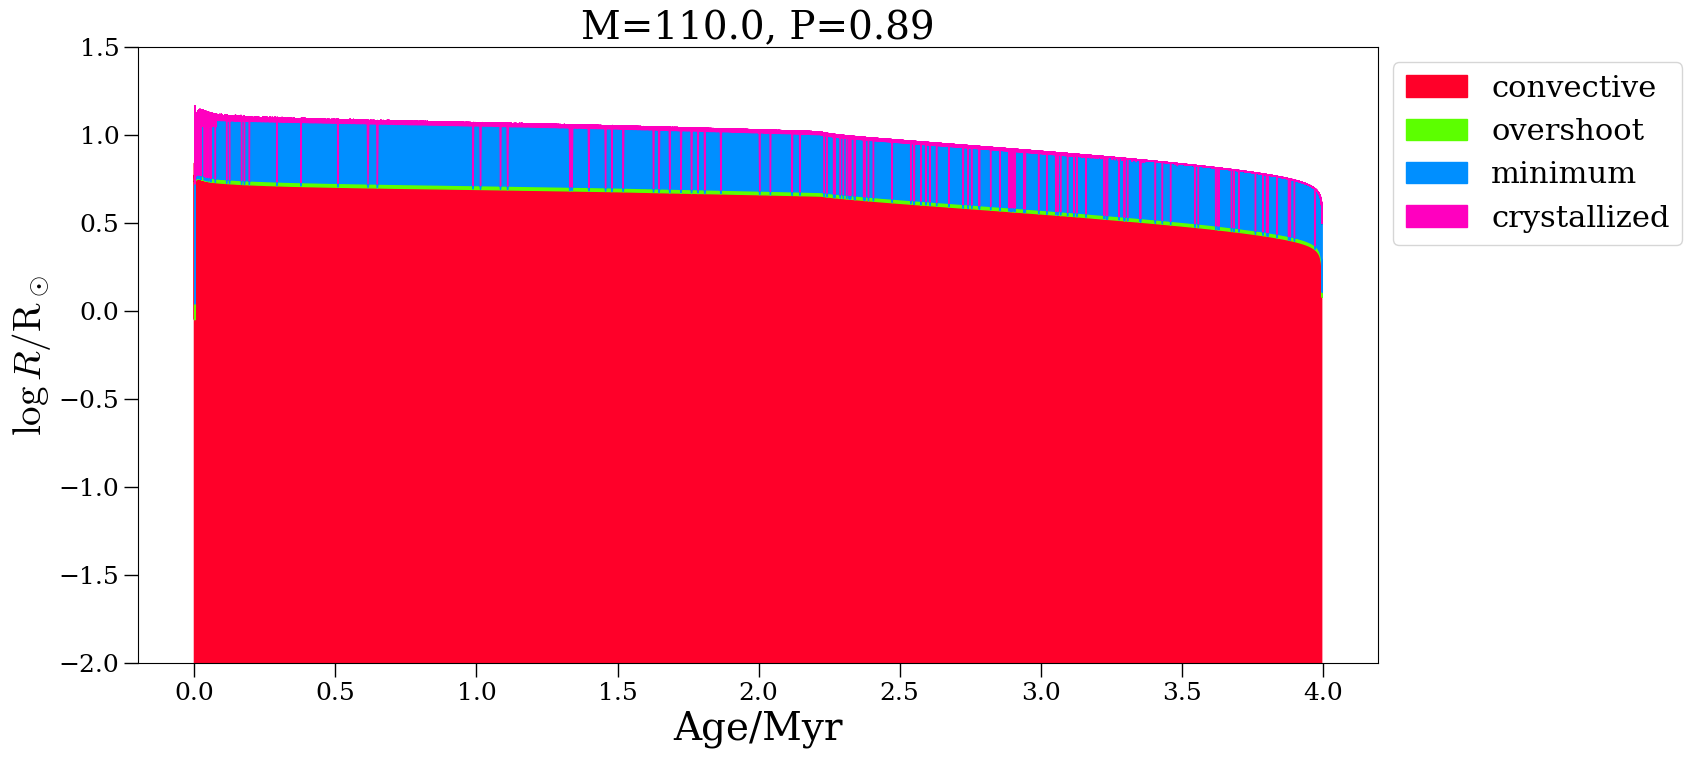

In [40]:
m_key = '110.0'
p_key = '0.89'
model = model_dict[m_key][p_key]
h = mr.MesaData(str(model/'LOGS/history.data'))
profiles = mr.MesaLogDir(str(model/'LOGS'))


fig, ax = plt.subplots(figsize=(16, 8))
cmap = cm.gist_rainbow

t = h.star_age/1e6
r = h.radius
n_mix_regions = 20

types_to_label = []
for i in range(1, n_mix_regions+1):
    type_col = f'mix_relr_type_{i}'
    type_code = h.__getattr__(type_col)[0]
    if type_code not in types_to_label:
        types_to_label.append(type_code)

colors = cmap(np.linspace(0, 1, len(types_to_label)))
    
bottom = np.ones(len(r))*1e-6


for i in range(1, n_mix_regions+1):
    type_col = f'mix_relr_type_{i}'
    top_col = f'mix_relr_top_{i}'
    type_code = h.__getattr__(type_col)[0]
    typ = mix_dict[type_code]
    top = h.__getattr__(top_col)
    
    i_c = types_to_label.index(type_code)
    c = colors[i_c]
    
    #c = cmap(type_code/12)
    ax.fill_between(t, np.log10(bottom*r), np.log10(top*r), color=c)
    #ax.plot(t, np.log10(top*r), lw=0.5, alpha=0.1, c='k')
    
    bottom = top
    
    
ax.set_xlabel('Age/Myr')
ax.set_ylabel('$\\log R/\\mathrm{R}_\\odot$')
ax.set_ylim(-2)

handles = []
for type, c in zip(types_to_label, colors):
    handles.append(Patch(color=c, label=mix_dict[type]))
ax.legend(handles=handles, loc='upper left', bbox_to_anchor=(1,1))

ax.set_title(f'M={m_key}, P={p_key}')

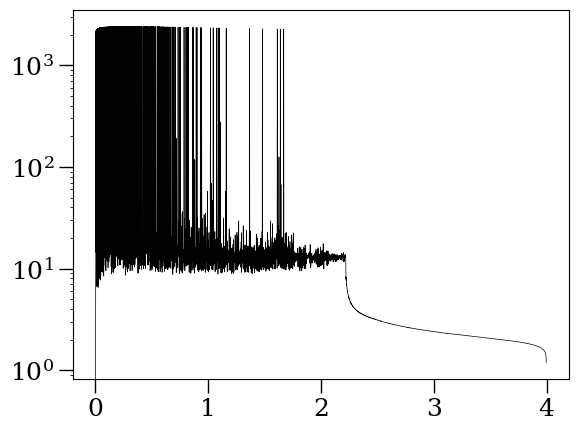

In [41]:
plt.plot(h.star_age/1e6, h.rotational_mdot_boost, 'k-', lw=0.5)
plt.yscale('log')

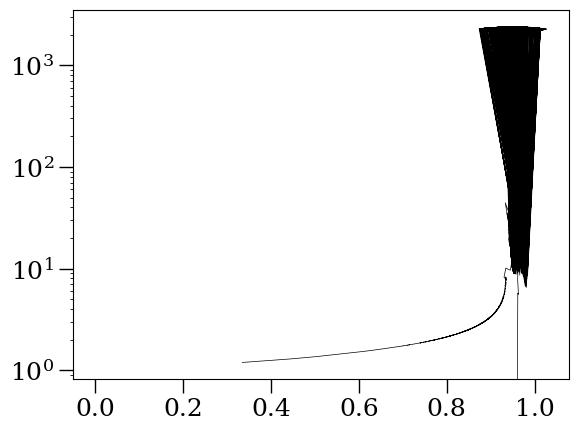

In [42]:
plt.plot(h.surf_avg_omega_div_omega_crit, h.rotational_mdot_boost, 'k-', lw=0.5)
plt.yscale('log')

Text(0.5, 1.0, 'M=180.0, P=1.28')

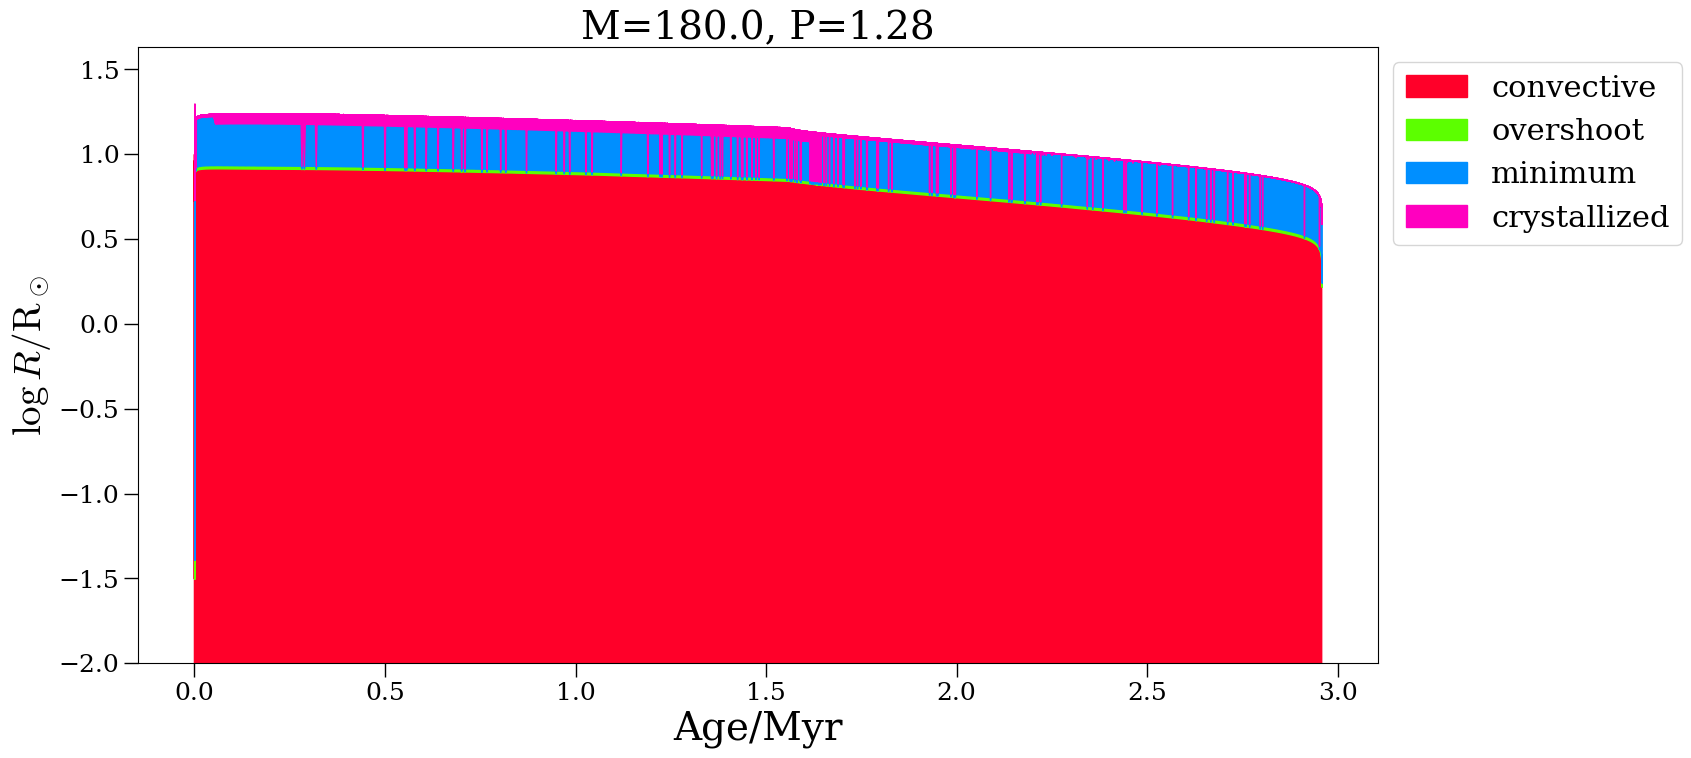

In [43]:
m_key = '180.0'
p_key = '1.28'
model = model_dict[m_key][p_key]
h = mr.MesaData(str(model/'LOGS/history.data'))
profiles = mr.MesaLogDir(str(model/'LOGS'))


fig, ax = plt.subplots(figsize=(16, 8))
cmap = cm.gist_rainbow

t = h.star_age/1e6
r = h.radius
n_mix_regions = 20

types_to_label = []
for i in range(1, n_mix_regions+1):
    type_col = f'mix_relr_type_{i}'
    type_code = h.__getattr__(type_col)[0]
    if type_code not in types_to_label:
        types_to_label.append(type_code)

colors = cmap(np.linspace(0, 1, len(types_to_label)))
    
bottom = np.ones(len(r))*1e-6


for i in range(1, n_mix_regions+1):
    type_col = f'mix_relr_type_{i}'
    top_col = f'mix_relr_top_{i}'
    type_code = h.__getattr__(type_col)[0]
    typ = mix_dict[type_code]
    top = h.__getattr__(top_col)
    
    i_c = types_to_label.index(type_code)
    c = colors[i_c]
    
    #c = cmap(type_code/12)
    ax.fill_between(t, np.log10(bottom*r), np.log10(top*r), color=c)
    #ax.plot(t, np.log10(top*r), lw=0.5, alpha=0.1, c='k')
    
    bottom = top
    
    
ax.set_xlabel('Age/Myr')
ax.set_ylabel('$\\log R/\\mathrm{R}_\\odot$')
ax.set_ylim(-2)

handles = []
for type, c in zip(types_to_label, colors):
    handles.append(Patch(color=c, label=mix_dict[type]))
ax.legend(handles=handles, loc='upper left', bbox_to_anchor=(1,1))

ax.set_title(f'M={m_key}, P={p_key}')

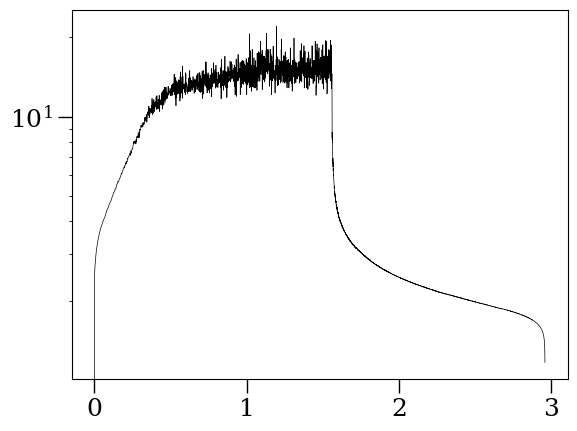

In [44]:
plt.plot(h.star_age/1e6, h.rotational_mdot_boost, 'k-', lw=0.5)
plt.yscale('log')

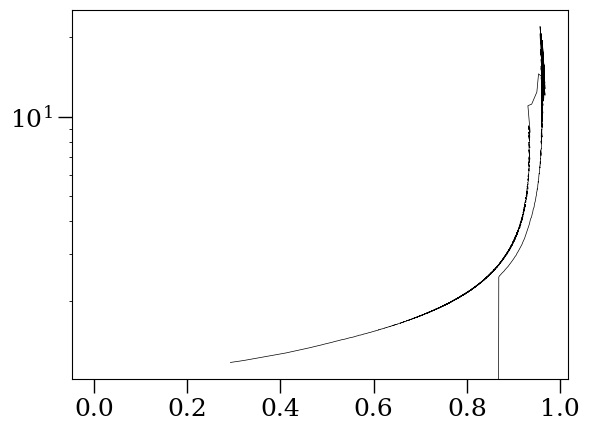

In [45]:
plt.plot(h.surf_avg_omega_div_omega_crit, h.rotational_mdot_boost, 'k-', lw=0.5)
plt.yscale('log')

Text(0.5, 1.0, 'M=180.0, P=1.65')

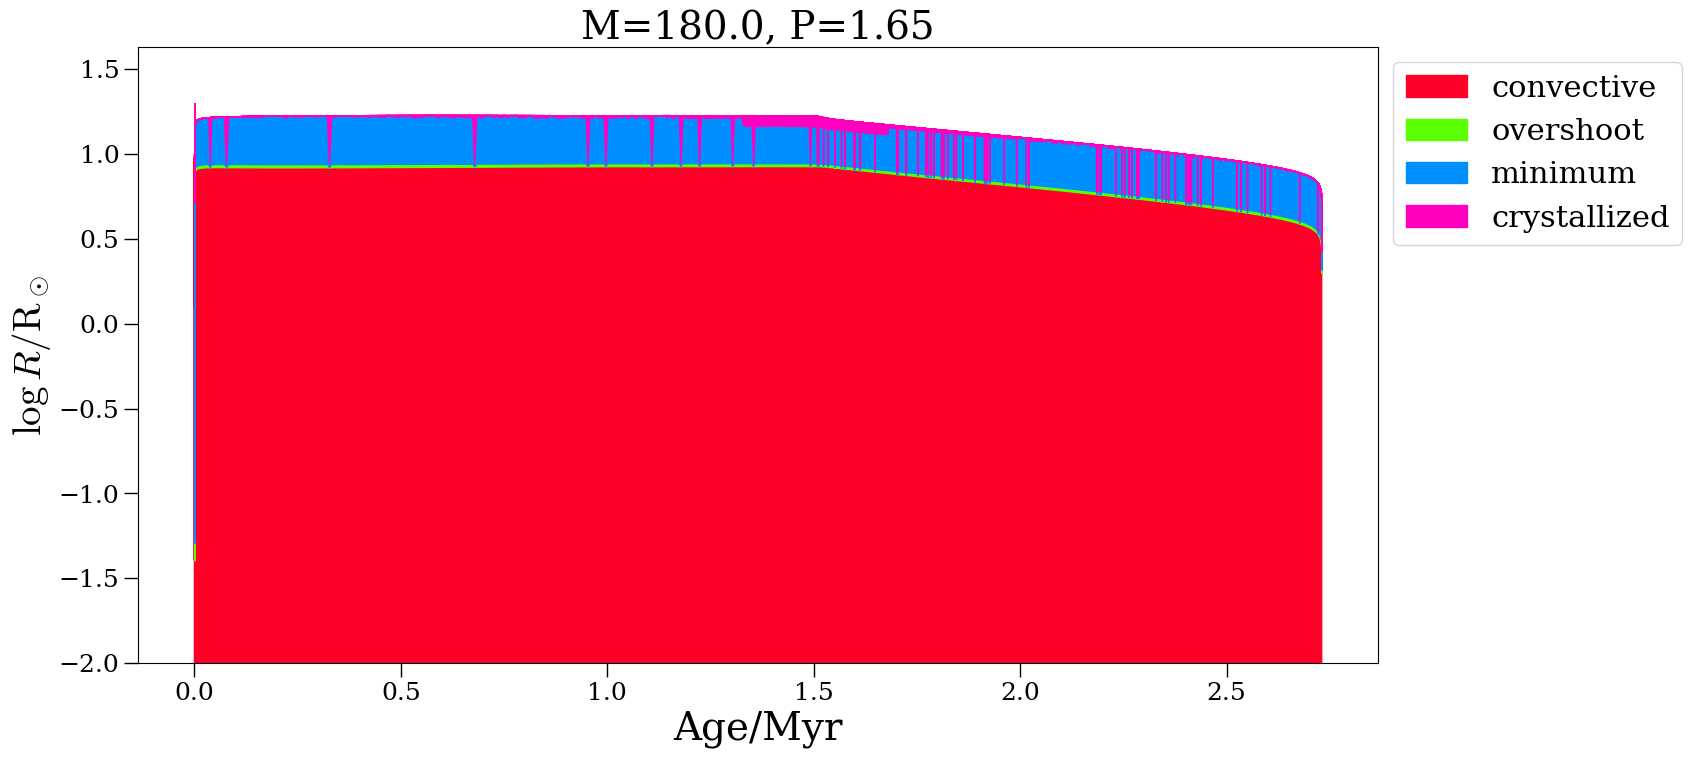

In [46]:
m_key = '180.0'
p_key = '1.65'
model = model_dict[m_key][p_key]
h = mr.MesaData(str(model/'LOGS/history.data'))
profiles = mr.MesaLogDir(str(model/'LOGS'))


fig, ax = plt.subplots(figsize=(16, 8))
cmap = cm.gist_rainbow

t = h.star_age/1e6
r = h.radius
n_mix_regions = 20

types_to_label = []
for i in range(1, n_mix_regions+1):
    type_col = f'mix_relr_type_{i}'
    type_code = h.__getattr__(type_col)[0]
    if type_code not in types_to_label:
        types_to_label.append(type_code)

colors = cmap(np.linspace(0, 1, len(types_to_label)))
    
bottom = np.ones(len(r))*1e-6


for i in range(1, n_mix_regions+1):
    type_col = f'mix_relr_type_{i}'
    top_col = f'mix_relr_top_{i}'
    type_code = h.__getattr__(type_col)[0]
    typ = mix_dict[type_code]
    top = h.__getattr__(top_col)
    
    i_c = types_to_label.index(type_code)
    c = colors[i_c]
    
    #c = cmap(type_code/12)
    ax.fill_between(t, np.log10(bottom*r), np.log10(top*r), color=c)
    #ax.plot(t, np.log10(top*r), lw=0.5, alpha=0.1, c='k')
    
    bottom = top
    
    
ax.set_xlabel('Age/Myr')
ax.set_ylabel('$\\log R/\\mathrm{R}_\\odot$')
ax.set_ylim(-2)

handles = []
for type, c in zip(types_to_label, colors):
    handles.append(Patch(color=c, label=mix_dict[type]))
ax.legend(handles=handles, loc='upper left', bbox_to_anchor=(1,1))

ax.set_title(f'M={m_key}, P={p_key}')

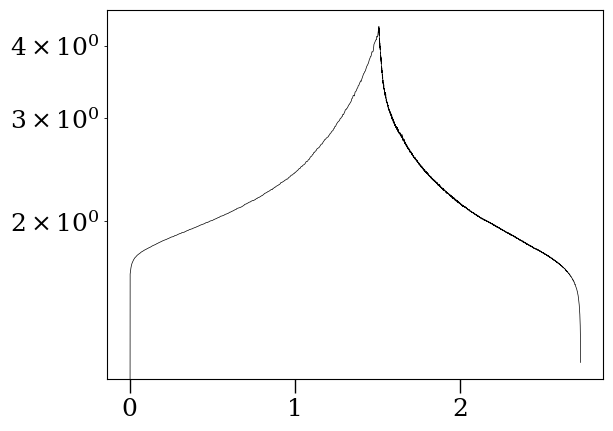

In [47]:
plt.plot(h.star_age/1e6, h.rotational_mdot_boost, 'k-', lw=0.5)
plt.yscale('log')

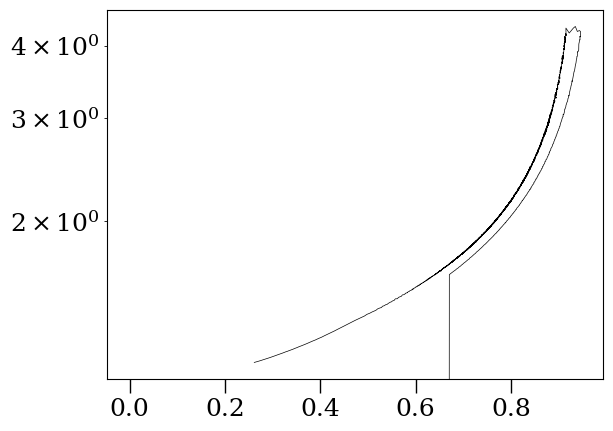

In [48]:
plt.plot(h.surf_avg_omega_div_omega_crit, h.rotational_mdot_boost, 'k-', lw=0.5)
plt.yscale('log')

Text(0.5, 1.0, 'M=180.0, P=4.04')

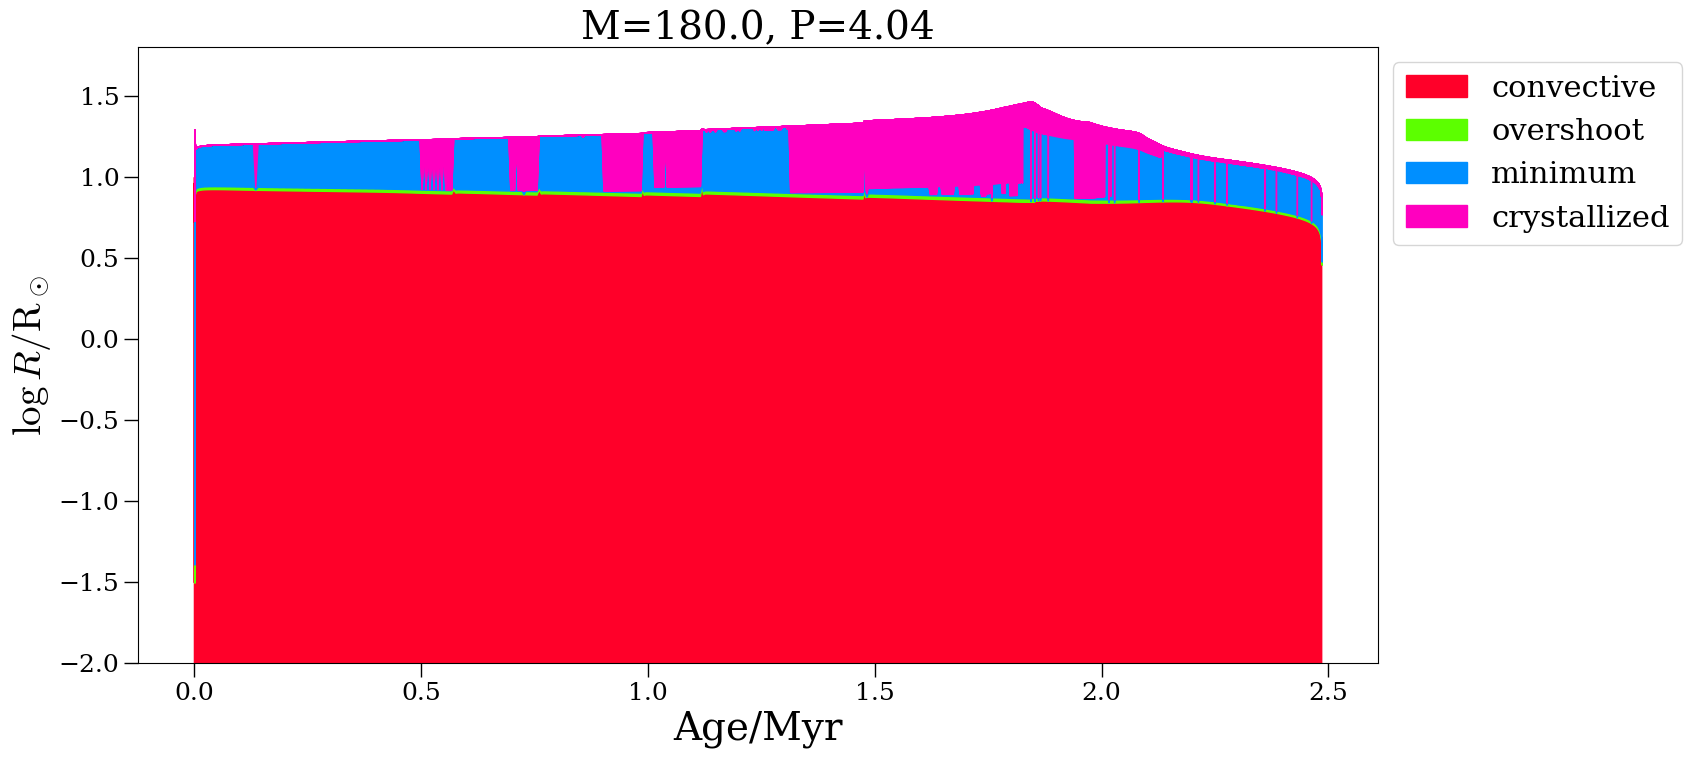

In [49]:
m_key = '180.0'
p_key = '4.04'
model = model_dict[m_key][p_key]
h = mr.MesaData(str(model/'LOGS/history.data'))
profiles = mr.MesaLogDir(str(model/'LOGS'))


fig, ax = plt.subplots(figsize=(16, 8))
cmap = cm.gist_rainbow

t = h.star_age/1e6
r = h.radius
n_mix_regions = 20

types_to_label = []
for i in range(1, n_mix_regions+1):
    type_col = f'mix_relr_type_{i}'
    type_code = h.__getattr__(type_col)[0]
    if type_code not in types_to_label:
        types_to_label.append(type_code)

colors = cmap(np.linspace(0, 1, len(types_to_label)))
    
bottom = np.ones(len(r))*1e-6


for i in range(1, n_mix_regions+1):
    type_col = f'mix_relr_type_{i}'
    top_col = f'mix_relr_top_{i}'
    type_code = h.__getattr__(type_col)[0]
    typ = mix_dict[type_code]
    top = h.__getattr__(top_col)
    
    i_c = types_to_label.index(type_code)
    c = colors[i_c]
    
    #c = cmap(type_code/12)
    ax.fill_between(t, np.log10(bottom*r), np.log10(top*r), color=c)
    #ax.plot(t, np.log10(top*r), lw=0.5, alpha=0.1, c='k')
    
    bottom = top
    
    
ax.set_xlabel('Age/Myr')
ax.set_ylabel('$\\log R/\\mathrm{R}_\\odot$')
ax.set_ylim(-2)

handles = []
for type, c in zip(types_to_label, colors):
    handles.append(Patch(color=c, label=mix_dict[type]))
ax.legend(handles=handles, loc='upper left', bbox_to_anchor=(1,1))

ax.set_title(f'M={m_key}, P={p_key}')

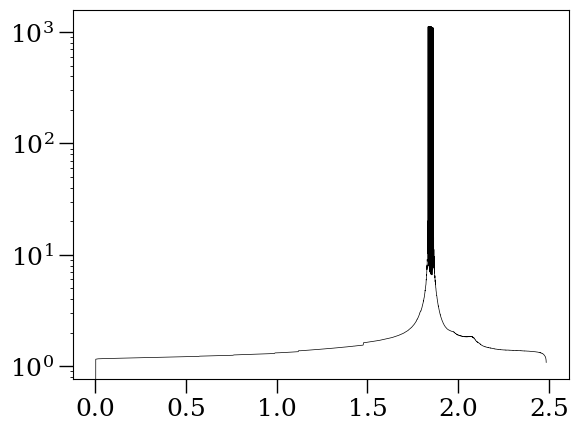

In [50]:
plt.plot(h.star_age/1e6, h.rotational_mdot_boost, 'k-', lw=0.5)
plt.yscale('log')

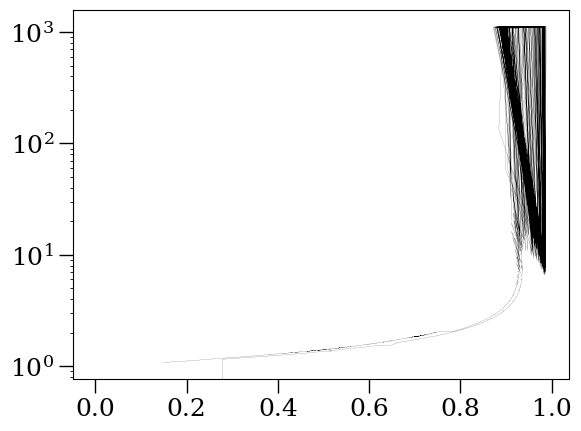

In [51]:
plt.plot(h.surf_avg_omega_div_omega_crit, h.rotational_mdot_boost, 'k-', lw=0.1)
plt.yscale('log')

## Structure and rotational winds

Text(0.5, 1.0, 'M=14.0, P=0.48')

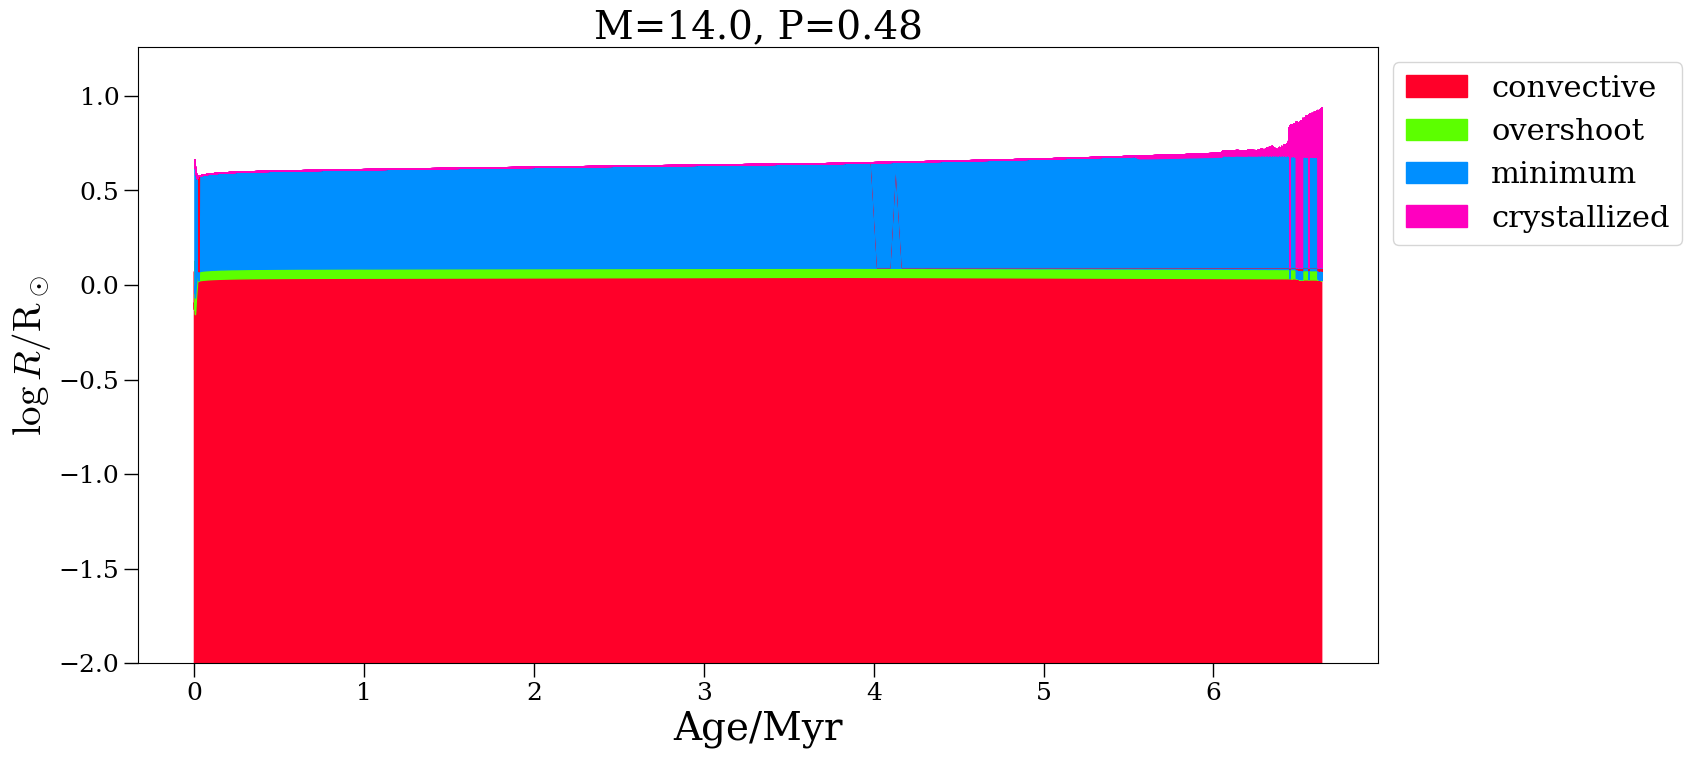

In [34]:
m_key = '14.0'
p_key = '0.48'
model = model_dict[m_key][p_key]
h = mr.MesaData(str(model/'LOGS/history.data'))
profiles = mr.MesaLogDir(str(model/'LOGS'))


fig, ax = plt.subplots(figsize=(16, 8))
cmap = cm.gist_rainbow

t = h.star_age/1e6
r = h.radius
n_mix_regions = 20

types_to_label = []
for i in range(1, n_mix_regions+1):
    type_col = f'mix_relr_type_{i}'
    type_code = h.__getattr__(type_col)[0]
    if type_code not in types_to_label:
        types_to_label.append(type_code)

colors = cmap(np.linspace(0, 1, len(types_to_label)))
    
bottom = np.ones(len(r))*1e-6


for i in range(1, n_mix_regions+1):
    type_col = f'mix_relr_type_{i}'
    top_col = f'mix_relr_top_{i}'
    type_code = h.__getattr__(type_col)[0]
    typ = mix_dict[type_code]
    top = h.__getattr__(top_col)
    
    i_c = types_to_label.index(type_code)
    c = colors[i_c]
    
    #c = cmap(type_code/12)
    ax.fill_between(t, np.log10(bottom*r), np.log10(top*r), color=c)
    #ax.plot(t, np.log10(top*r), lw=0.5, alpha=0.1, c='k')
    
    bottom = top
    
    
ax.set_xlabel('Age/Myr')
ax.set_ylabel('$\\log R/\\mathrm{R}_\\odot$')
ax.set_ylim(-2)

handles = []
for type, c in zip(types_to_label, colors):
    handles.append(Patch(color=c, label=mix_dict[type]))
ax.legend(handles=handles, loc='upper left', bbox_to_anchor=(1,1))

ax.set_title(f'M={m_key}, P={p_key}')

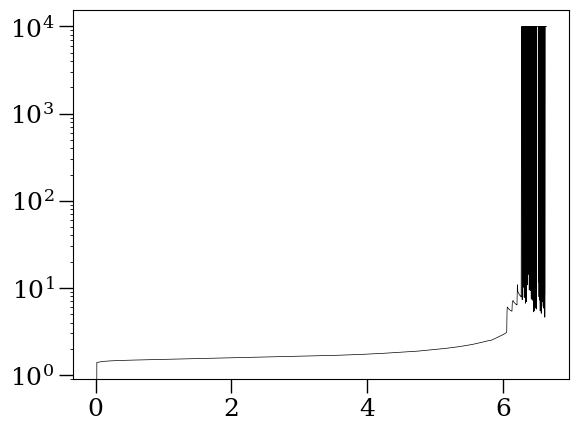

In [35]:
plt.plot(h.star_age/1e6, h.rotational_mdot_boost, 'k-', lw=0.5)
plt.yscale('log')

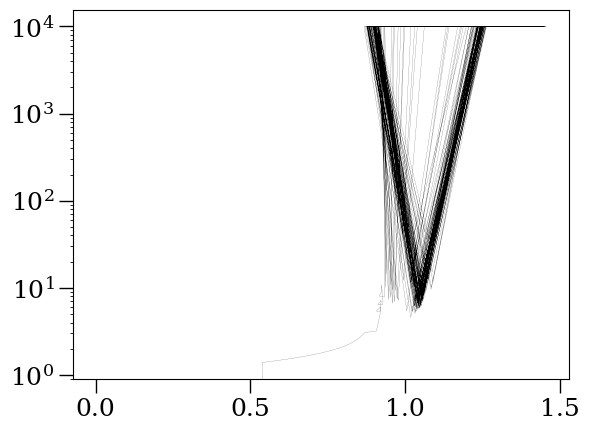

In [36]:
plt.plot(h.surf_avg_omega_div_omega_crit, h.rotational_mdot_boost, 'k-', lw=0.1)
plt.yscale('log')

In [37]:
m_key = '14.0'
p_key = '1.65'
model = model_dict[m_key][p_key]
h = mr.MesaData(str(model/'LOGS/history.data'))
profiles = mr.MesaLogDir(str(model/'LOGS'))


fig, ax = plt.subplots(figsize=(16, 8))
cmap = cm.gist_rainbow

t = h.star_age/1e6
r = h.radius
n_mix_regions = 20

types_to_label = []
for i in range(1, n_mix_regions+1):
    type_col = f'mix_relr_type_{i}'
    type_code = h.__getattr__(type_col)[0]
    if type_code not in types_to_label:
        types_to_label.append(type_code)

colors = cmap(np.linspace(0, 1, len(types_to_label)))
    
bottom = np.ones(len(r))*1e-6


for i in range(1, n_mix_regions+1):
    type_col = f'mix_relr_type_{i}'
    top_col = f'mix_relr_top_{i}'
    type_code = h.__getattr__(type_col)[0]
    typ = mix_dict[type_code]
    top = h.__getattr__(top_col)
    
    i_c = types_to_label.index(type_code)
    c = colors[i_c]
    
    #c = cmap(type_code/12)
    ax.fill_between(t, np.log10(bottom*r), np.log10(top*r), color=c)
    #ax.plot(t, np.log10(top*r), lw=0.5, alpha=0.1, c='k')
    
    bottom = top
    
    
ax.set_xlabel('Age/Myr')
ax.set_ylabel('$\\log R/\\mathrm{R}_\\odot$')
ax.set_ylim(-2)

handles = []
for type, c in zip(types_to_label, colors):
    handles.append(Patch(color=c, label=mix_dict[type]))
ax.legend(handles=handles, loc='upper left', bbox_to_anchor=(1,1))

ax.set_title(f'M={m_key}, P={p_key}')

KeyError: '1.65'

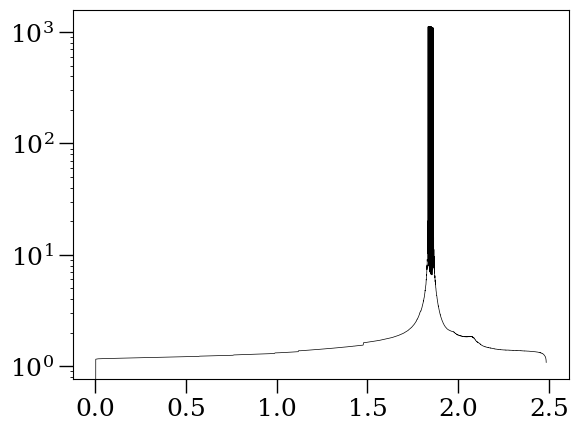

In [ ]:
plt.plot(h.star_age/1e6, h.rotational_mdot_boost, 'k-', lw=0.5)
plt.yscale('log')

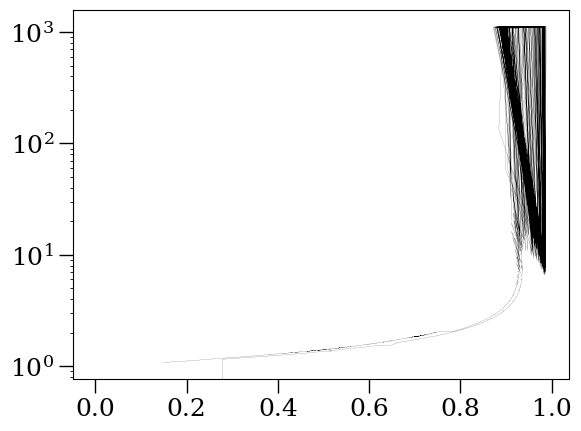

In [ ]:
plt.plot(h.surf_avg_omega_div_omega_crit, h.rotational_mdot_boost, 'k-', lw=0.1)
plt.yscale('log')

Text(0.5, 1.0, 'M=14.0, P=0.48')

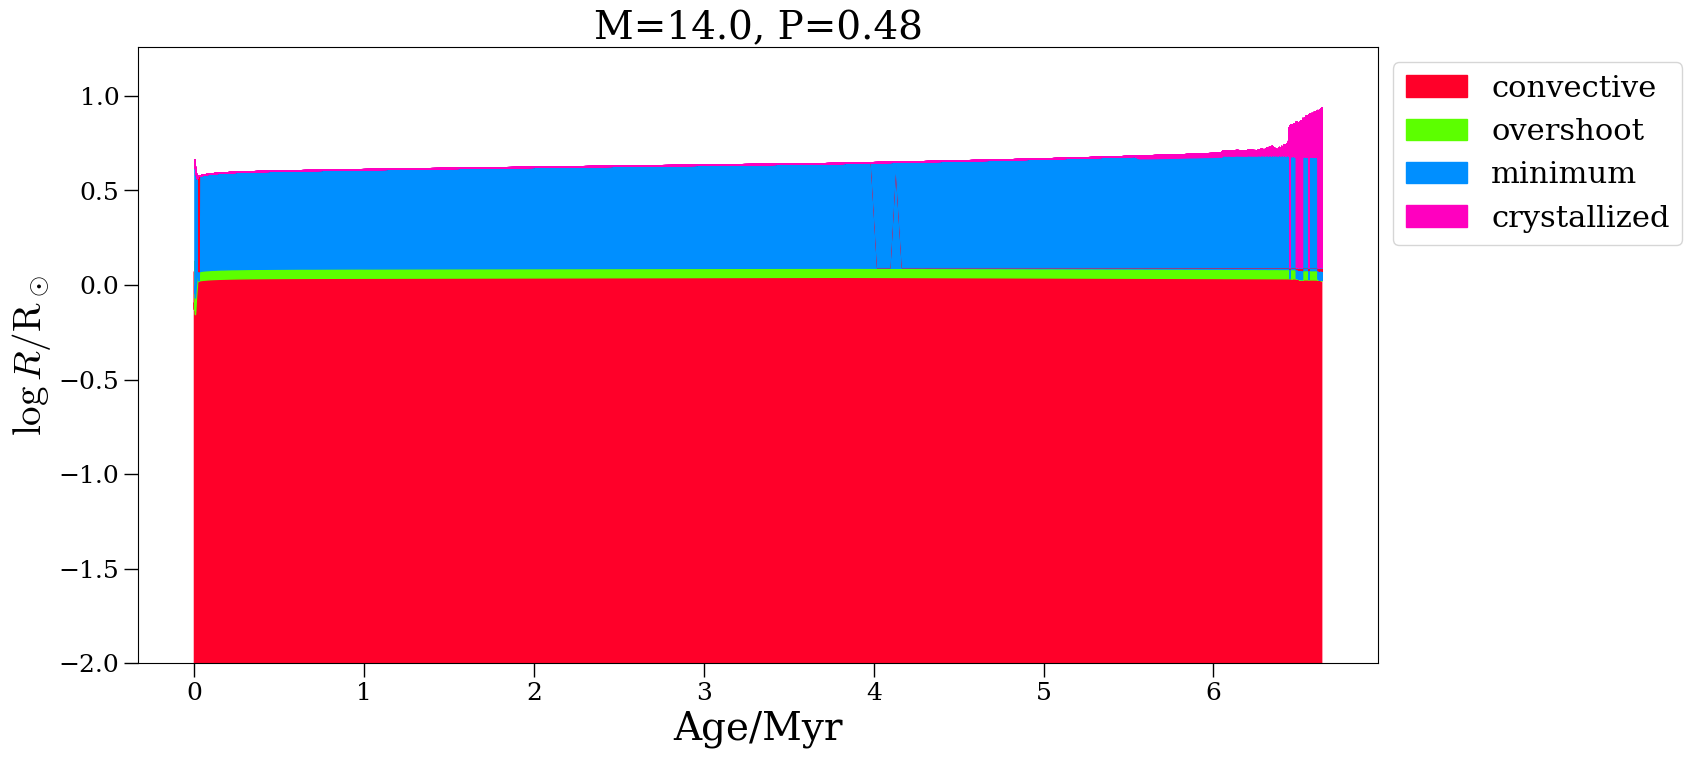

In [ ]:
m_key = '14.0'
p_key = '2.42'
model = model_dict[m_key][p_key]
h = mr.MesaData(str(model/'LOGS/history.data'))
profiles = mr.MesaLogDir(str(model/'LOGS'))


fig, ax = plt.subplots(figsize=(16, 8))
cmap = cm.gist_rainbow

t = h.star_age/1e6
r = h.radius
n_mix_regions = 20

types_to_label = []
for i in range(1, n_mix_regions+1):
    type_col = f'mix_relr_type_{i}'
    type_code = h.__getattr__(type_col)[0]
    if type_code not in types_to_label:
        types_to_label.append(type_code)

colors = cmap(np.linspace(0, 1, len(types_to_label)))
    
bottom = np.ones(len(r))*1e-6


for i in range(1, n_mix_regions+1):
    type_col = f'mix_relr_type_{i}'
    top_col = f'mix_relr_top_{i}'
    type_code = h.__getattr__(type_col)[0]
    typ = mix_dict[type_code]
    top = h.__getattr__(top_col)
    
    i_c = types_to_label.index(type_code)
    c = colors[i_c]
    
    #c = cmap(type_code/12)
    ax.fill_between(t, np.log10(bottom*r), np.log10(top*r), color=c)
    #ax.plot(t, np.log10(top*r), lw=0.5, alpha=0.1, c='k')
    
    bottom = top
    
    
ax.set_xlabel('Age/Myr')
ax.set_ylabel('$\\log R/\\mathrm{R}_\\odot$')
ax.set_ylim(-2)

handles = []
for type, c in zip(types_to_label, colors):
    handles.append(Patch(color=c, label=mix_dict[type]))
ax.legend(handles=handles, loc='upper left', bbox_to_anchor=(1,1))

ax.set_title(f'M={m_key}, P={p_key}')

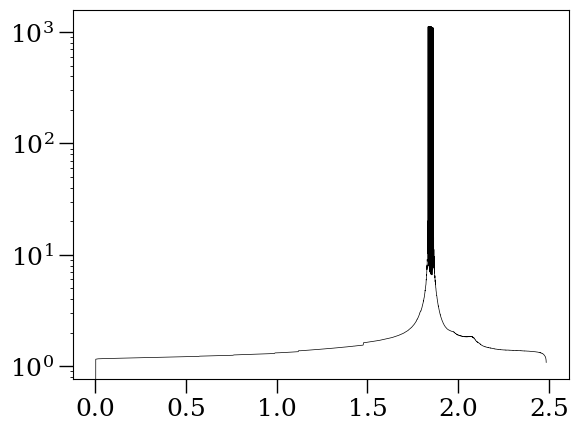

In [ ]:
plt.plot(h.star_age/1e6, h.rotational_mdot_boost, 'k-', lw=0.5)
plt.yscale('log')

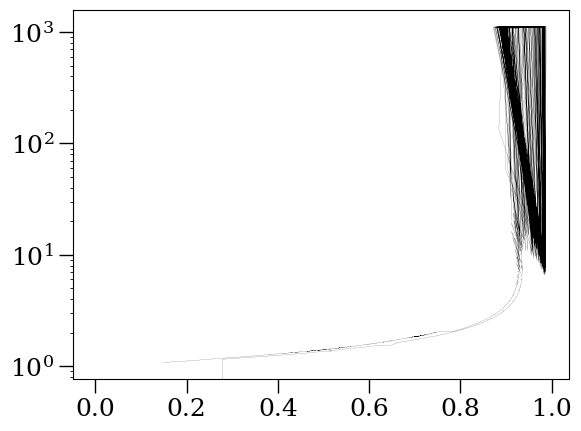

In [ ]:
plt.plot(h.surf_avg_omega_div_omega_crit, h.rotational_mdot_boost, 'k-', lw=0.1)
plt.yscale('log')

Text(0.5, 1.0, 'M=14.0, P=0.48')

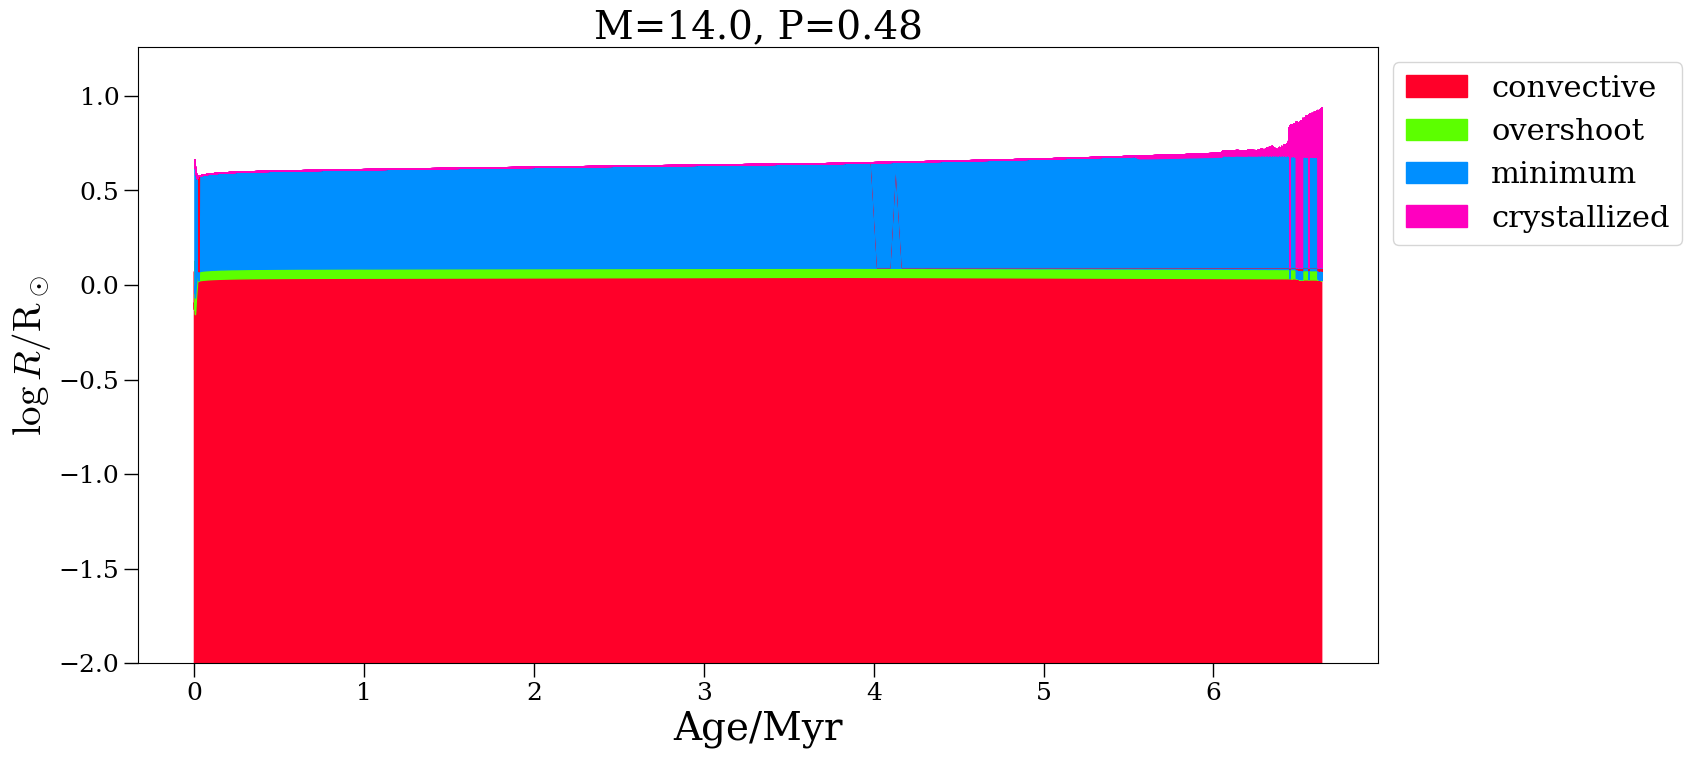

In [ ]:
m_key = '39.0'
p_key = '0.89'
model = model_dict[m_key][p_key]
h = mr.MesaData(str(model/'LOGS/history.data'))
profiles = mr.MesaLogDir(str(model/'LOGS'))


fig, ax = plt.subplots(figsize=(16, 8))
cmap = cm.gist_rainbow

t = h.star_age/1e6
r = h.radius
n_mix_regions = 20

types_to_label = []
for i in range(1, n_mix_regions+1):
    type_col = f'mix_relr_type_{i}'
    type_code = h.__getattr__(type_col)[0]
    if type_code not in types_to_label:
        types_to_label.append(type_code)

colors = cmap(np.linspace(0, 1, len(types_to_label)))
    
bottom = np.ones(len(r))*1e-6


for i in range(1, n_mix_regions+1):
    type_col = f'mix_relr_type_{i}'
    top_col = f'mix_relr_top_{i}'
    type_code = h.__getattr__(type_col)[0]
    typ = mix_dict[type_code]
    top = h.__getattr__(top_col)
    
    i_c = types_to_label.index(type_code)
    c = colors[i_c]
    
    #c = cmap(type_code/12)
    ax.fill_between(t, np.log10(bottom*r), np.log10(top*r), color=c)
    #ax.plot(t, np.log10(top*r), lw=0.5, alpha=0.1, c='k')
    
    bottom = top
    
    
ax.set_xlabel('Age/Myr')
ax.set_ylabel('$\\log R/\\mathrm{R}_\\odot$')
ax.set_ylim(-2)

handles = []
for type, c in zip(types_to_label, colors):
    handles.append(Patch(color=c, label=mix_dict[type]))
ax.legend(handles=handles, loc='upper left', bbox_to_anchor=(1,1))

ax.set_title(f'M={m_key}, P={p_key}')

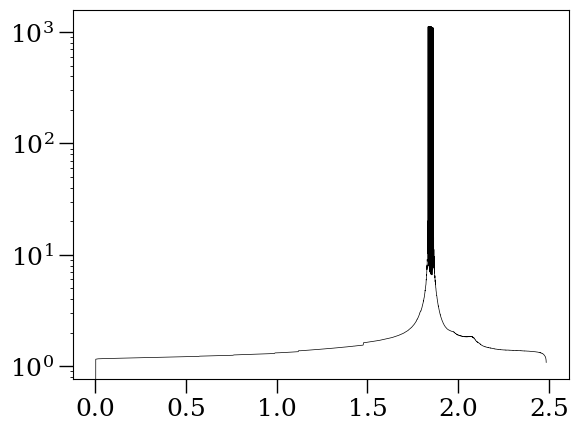

In [ ]:
plt.plot(h.star_age/1e6, h.rotational_mdot_boost, 'k-', lw=0.5)
plt.yscale('log')

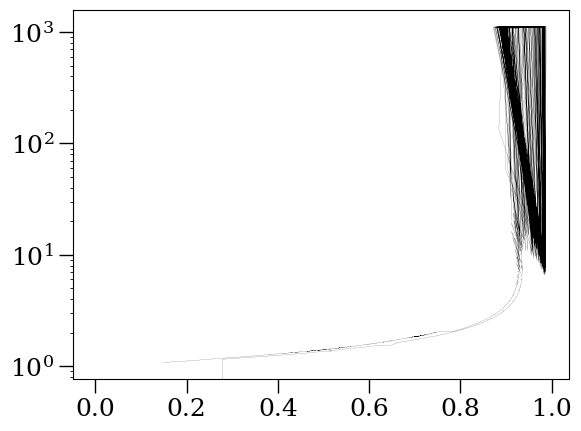

In [ ]:
plt.plot(h.surf_avg_omega_div_omega_crit, h.rotational_mdot_boost, 'k-', lw=0.1)
plt.yscale('log')

Text(0.5, 1.0, 'M=14.0, P=0.48')

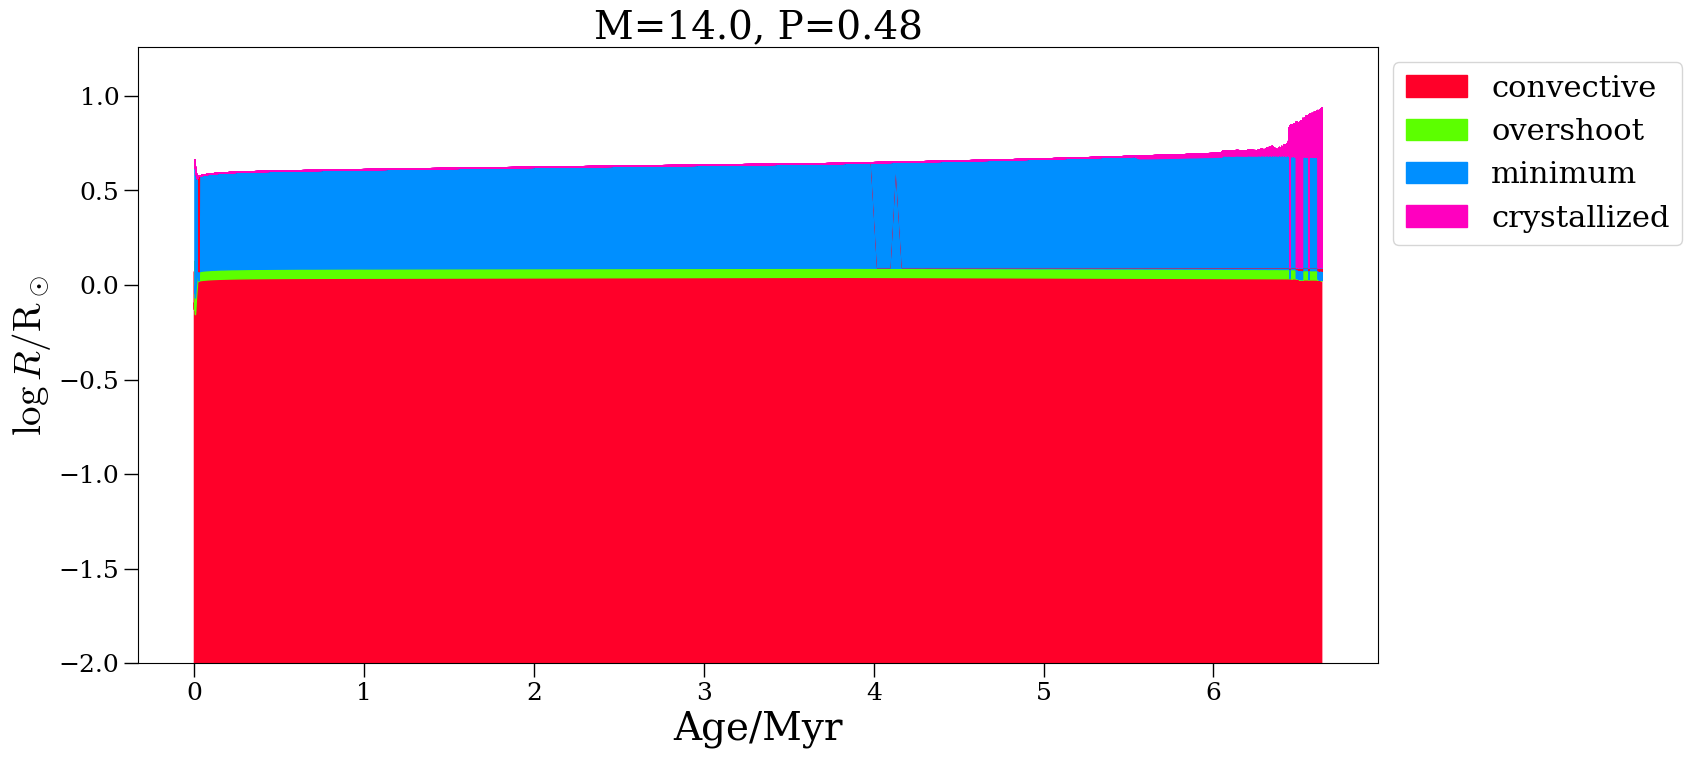

In [ ]:
m_key = '39.0'
p_key = '1.28'
model = model_dict[m_key][p_key]
h = mr.MesaData(str(model/'LOGS/history.data'))
profiles = mr.MesaLogDir(str(model/'LOGS'))


fig, ax = plt.subplots(figsize=(16, 8))
cmap = cm.gist_rainbow

t = h.star_age/1e6
r = h.radius
n_mix_regions = 20

types_to_label = []
for i in range(1, n_mix_regions+1):
    type_col = f'mix_relr_type_{i}'
    type_code = h.__getattr__(type_col)[0]
    if type_code not in types_to_label:
        types_to_label.append(type_code)

colors = cmap(np.linspace(0, 1, len(types_to_label)))
    
bottom = np.ones(len(r))*1e-6


for i in range(1, n_mix_regions+1):
    type_col = f'mix_relr_type_{i}'
    top_col = f'mix_relr_top_{i}'
    type_code = h.__getattr__(type_col)[0]
    typ = mix_dict[type_code]
    top = h.__getattr__(top_col)
    
    i_c = types_to_label.index(type_code)
    c = colors[i_c]
    
    #c = cmap(type_code/12)
    ax.fill_between(t, np.log10(bottom*r), np.log10(top*r), color=c)
    #ax.plot(t, np.log10(top*r), lw=0.5, alpha=0.1, c='k')
    
    bottom = top
    
    
ax.set_xlabel('Age/Myr')
ax.set_ylabel('$\\log R/\\mathrm{R}_\\odot$')
ax.set_ylim(-2)

handles = []
for type, c in zip(types_to_label, colors):
    handles.append(Patch(color=c, label=mix_dict[type]))
ax.legend(handles=handles, loc='upper left', bbox_to_anchor=(1,1))

ax.set_title(f'M={m_key}, P={p_key}')

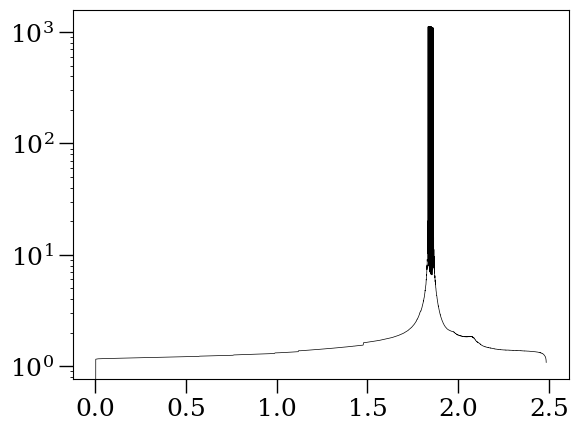

In [ ]:
plt.plot(h.star_age/1e6, h.rotational_mdot_boost, 'k-', lw=0.5)
plt.yscale('log')

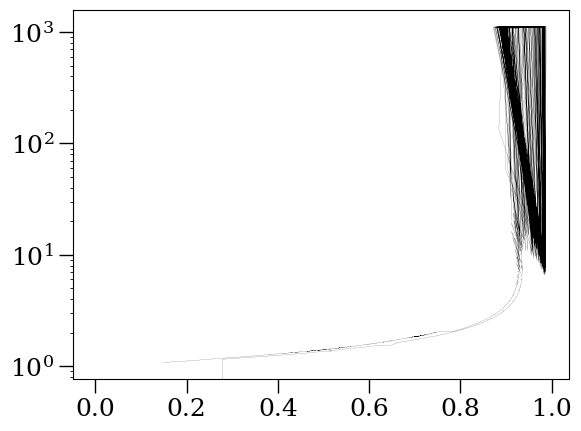

In [ ]:
plt.plot(h.surf_avg_omega_div_omega_crit, h.rotational_mdot_boost, 'k-', lw=0.1)
plt.yscale('log')

Text(0.5, 1.0, 'M=14.0, P=0.48')

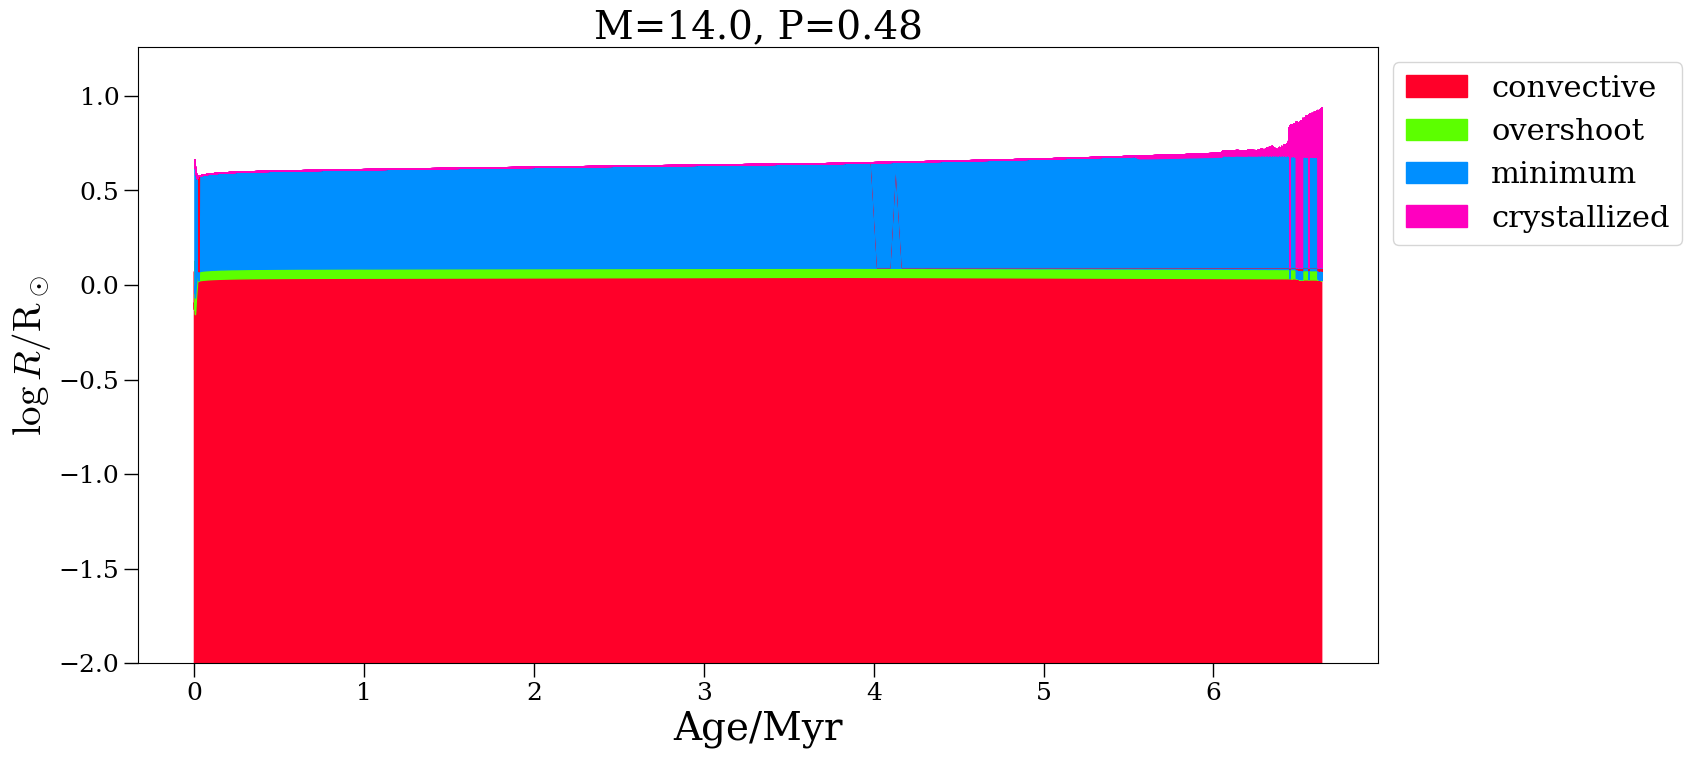

In [ ]:
m_key = '39.0'
p_key = '1.65'
model = model_dict[m_key][p_key]
h = mr.MesaData(str(model/'LOGS/history.data'))
profiles = mr.MesaLogDir(str(model/'LOGS'))


fig, ax = plt.subplots(figsize=(16, 8))
cmap = cm.gist_rainbow

t = h.star_age/1e6
r = h.radius
n_mix_regions = 20

types_to_label = []
for i in range(1, n_mix_regions+1):
    type_col = f'mix_relr_type_{i}'
    type_code = h.__getattr__(type_col)[0]
    if type_code not in types_to_label:
        types_to_label.append(type_code)

colors = cmap(np.linspace(0, 1, len(types_to_label)))
    
bottom = np.ones(len(r))*1e-6


for i in range(1, n_mix_regions+1):
    type_col = f'mix_relr_type_{i}'
    top_col = f'mix_relr_top_{i}'
    type_code = h.__getattr__(type_col)[0]
    typ = mix_dict[type_code]
    top = h.__getattr__(top_col)
    
    i_c = types_to_label.index(type_code)
    c = colors[i_c]
    
    #c = cmap(type_code/12)
    ax.fill_between(t, np.log10(bottom*r), np.log10(top*r), color=c)
    #ax.plot(t, np.log10(top*r), lw=0.5, alpha=0.1, c='k')
    
    bottom = top
    
    
ax.set_xlabel('Age/Myr')
ax.set_ylabel('$\\log R/\\mathrm{R}_\\odot$')
ax.set_ylim(-2)

handles = []
for type, c in zip(types_to_label, colors):
    handles.append(Patch(color=c, label=mix_dict[type]))
ax.legend(handles=handles, loc='upper left', bbox_to_anchor=(1,1))

ax.set_title(f'M={m_key}, P={p_key}')

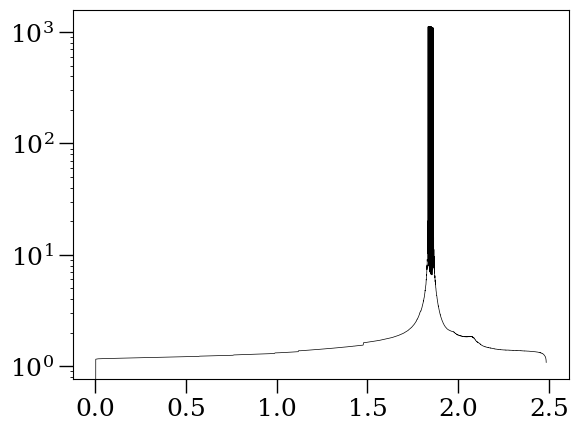

In [ ]:
plt.plot(h.star_age/1e6, h.rotational_mdot_boost, 'k-', lw=0.5)
plt.yscale('log')

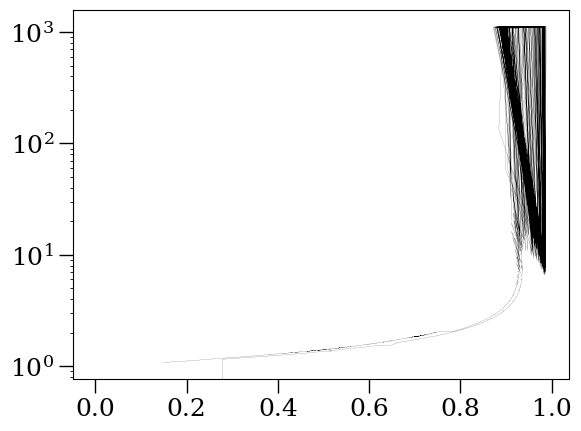

In [ ]:
plt.plot(h.surf_avg_omega_div_omega_crit, h.rotational_mdot_boost, 'k-', lw=0.1)
plt.yscale('log')

Text(0.5, 1.0, 'M=39.0, P=2.80')

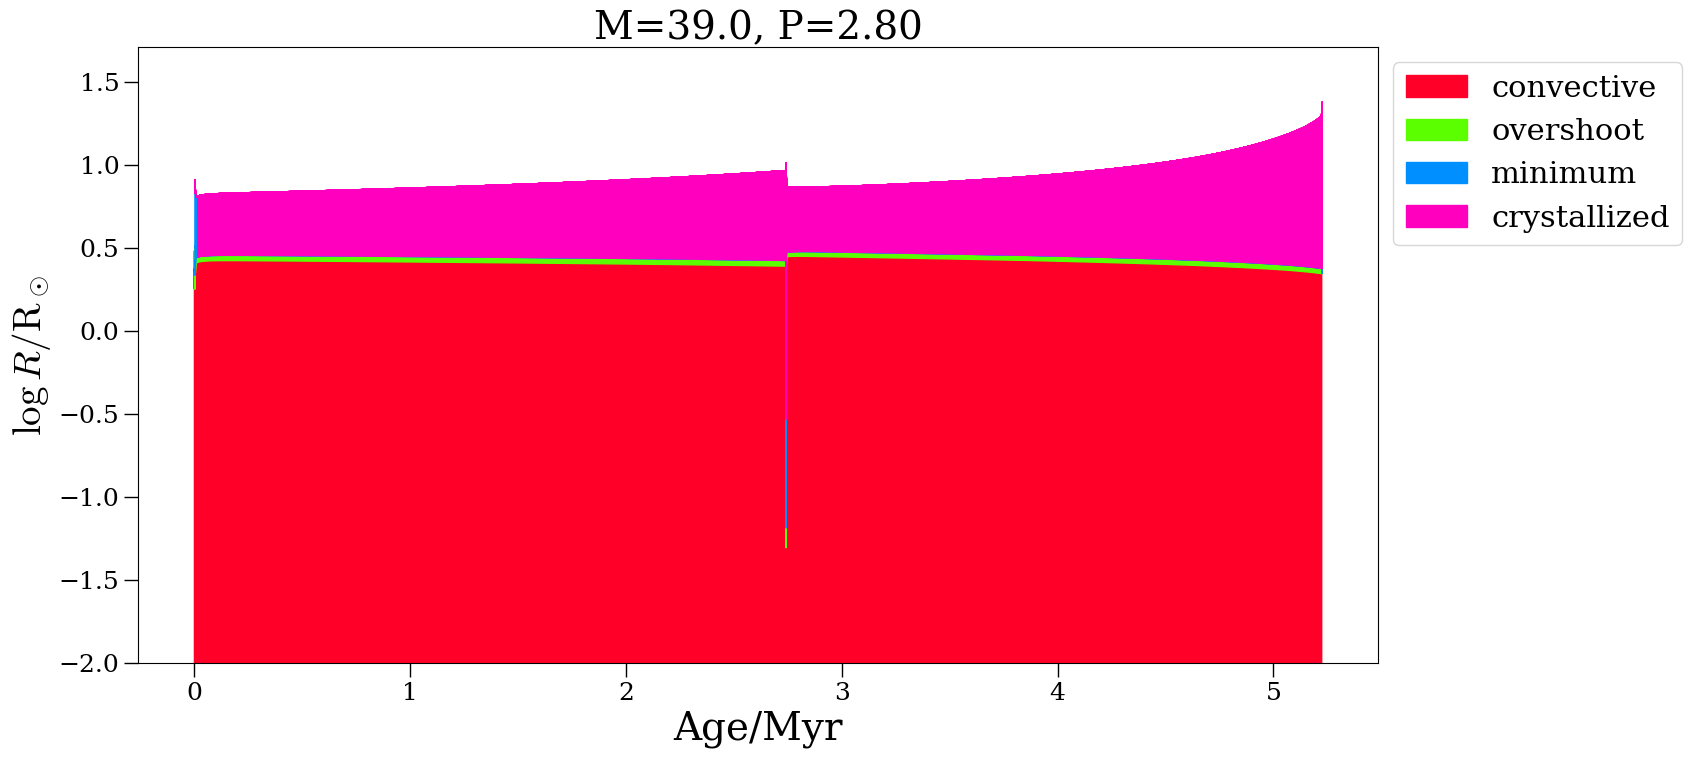

In [38]:
m_key = '39.0'
p_key = '2.80'
model = model_dict[m_key][p_key]
h = mr.MesaData(str(model/'LOGS/history.data'))
profiles = mr.MesaLogDir(str(model/'LOGS'))


fig, ax = plt.subplots(figsize=(16, 8))
cmap = cm.gist_rainbow

t = h.star_age/1e6
r = h.radius
n_mix_regions = 20

types_to_label = []
for i in range(1, n_mix_regions+1):
    type_col = f'mix_relr_type_{i}'
    type_code = h.__getattr__(type_col)[0]
    if type_code not in types_to_label:
        types_to_label.append(type_code)

colors = cmap(np.linspace(0, 1, len(types_to_label)))
    
bottom = np.ones(len(r))*1e-6


for i in range(1, n_mix_regions+1):
    type_col = f'mix_relr_type_{i}'
    top_col = f'mix_relr_top_{i}'
    type_code = h.__getattr__(type_col)[0]
    typ = mix_dict[type_code]
    top = h.__getattr__(top_col)
    
    i_c = types_to_label.index(type_code)
    c = colors[i_c]
    
    #c = cmap(type_code/12)
    ax.fill_between(t, np.log10(bottom*r), np.log10(top*r), color=c)
    #ax.plot(t, np.log10(top*r), lw=0.5, alpha=0.1, c='k')
    
    bottom = top
    
    
ax.set_xlabel('Age/Myr')
ax.set_ylabel('$\\log R/\\mathrm{R}_\\odot$')
ax.set_ylim(-2)

handles = []
for type, c in zip(types_to_label, colors):
    handles.append(Patch(color=c, label=mix_dict[type]))
ax.legend(handles=handles, loc='upper left', bbox_to_anchor=(1,1))

ax.set_title(f'M={m_key}, P={p_key}')

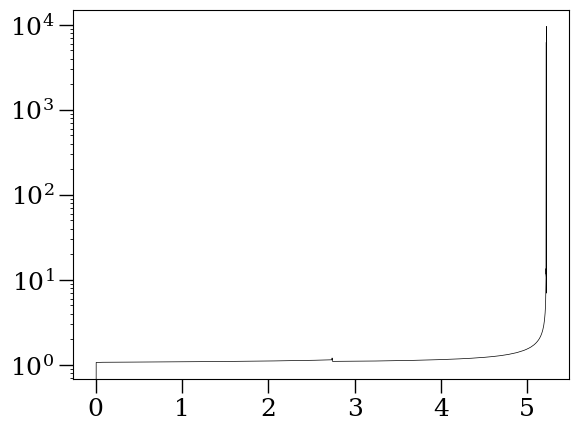

In [39]:
plt.plot(h.star_age/1e6, h.rotational_mdot_boost, 'k-', lw=0.5)
plt.yscale('log')

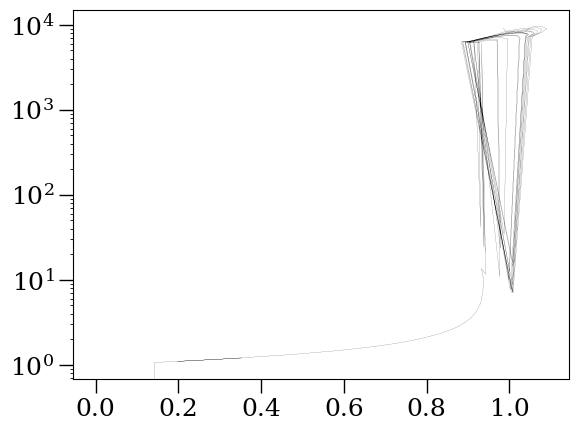

In [40]:
plt.plot(h.surf_avg_omega_div_omega_crit, h.rotational_mdot_boost, 'k-', lw=0.1)
plt.yscale('log')

Text(0.5, 1.0, 'M=65.0, P=1.28')

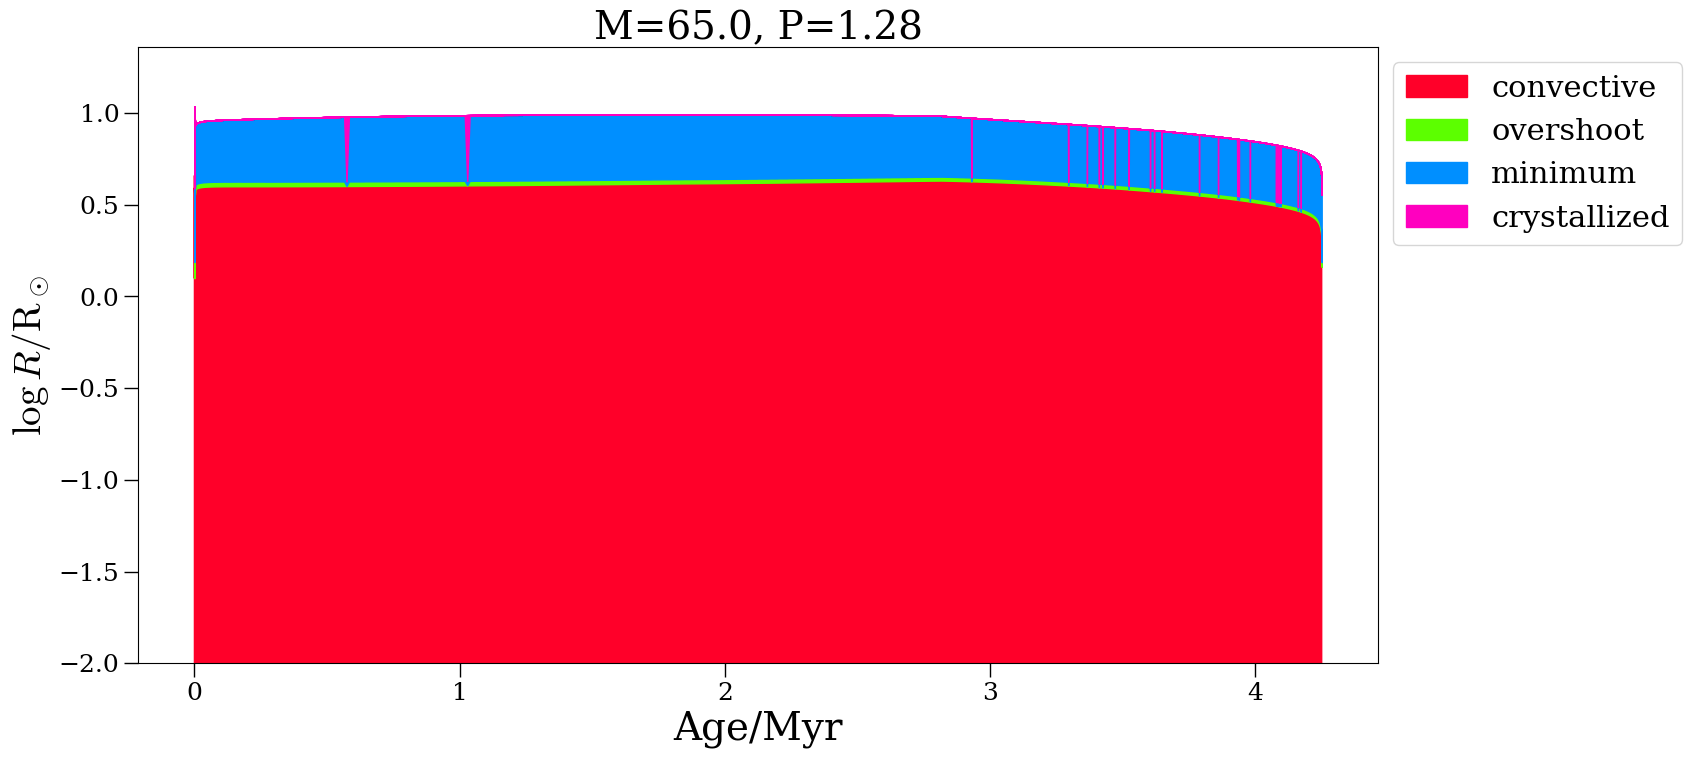

In [41]:
m_key = '65.0'
p_key = '1.28'
model = model_dict[m_key][p_key]
h = mr.MesaData(str(model/'LOGS/history.data'))
profiles = mr.MesaLogDir(str(model/'LOGS'))


fig, ax = plt.subplots(figsize=(16, 8))
cmap = cm.gist_rainbow

t = h.star_age/1e6
r = h.radius
n_mix_regions = 20

types_to_label = []
for i in range(1, n_mix_regions+1):
    type_col = f'mix_relr_type_{i}'
    type_code = h.__getattr__(type_col)[0]
    if type_code not in types_to_label:
        types_to_label.append(type_code)

colors = cmap(np.linspace(0, 1, len(types_to_label)))
    
bottom = np.ones(len(r))*1e-6


for i in range(1, n_mix_regions+1):
    type_col = f'mix_relr_type_{i}'
    top_col = f'mix_relr_top_{i}'
    type_code = h.__getattr__(type_col)[0]
    typ = mix_dict[type_code]
    top = h.__getattr__(top_col)
    
    i_c = types_to_label.index(type_code)
    c = colors[i_c]
    
    #c = cmap(type_code/12)
    ax.fill_between(t, np.log10(bottom*r), np.log10(top*r), color=c)
    #ax.plot(t, np.log10(top*r), lw=0.5, alpha=0.1, c='k')
    
    bottom = top
    
    
ax.set_xlabel('Age/Myr')
ax.set_ylabel('$\\log R/\\mathrm{R}_\\odot$')
ax.set_ylim(-2)

handles = []
for type, c in zip(types_to_label, colors):
    handles.append(Patch(color=c, label=mix_dict[type]))
ax.legend(handles=handles, loc='upper left', bbox_to_anchor=(1,1))

ax.set_title(f'M={m_key}, P={p_key}')

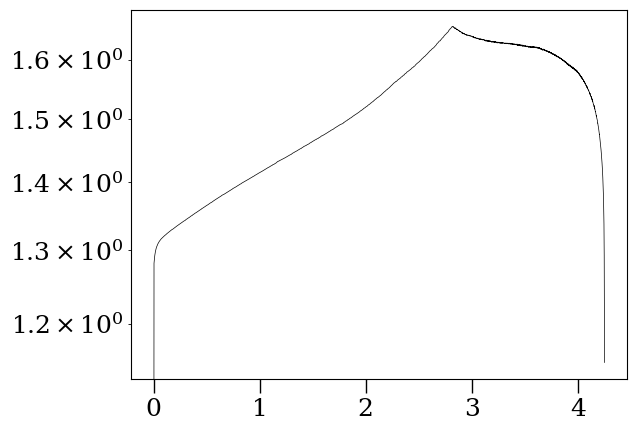

In [42]:
plt.plot(h.star_age/1e6, h.rotational_mdot_boost, 'k-', lw=0.5)
plt.yscale('log')

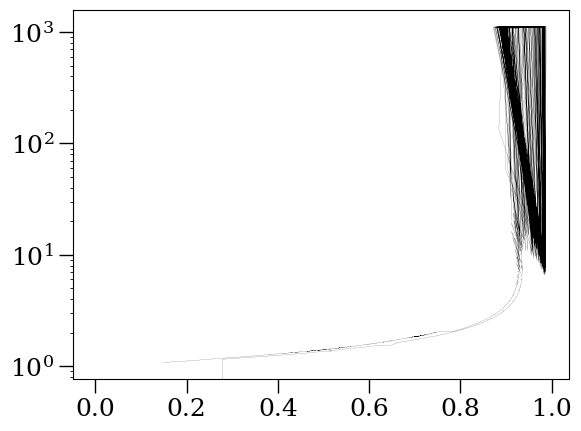

In [ ]:
plt.plot(h.surf_avg_omega_div_omega_crit, h.rotational_mdot_boost, 'k-', lw=0.1)
plt.yscale('log')

Text(0.5, 1.0, 'M=65.0, P=1.65')

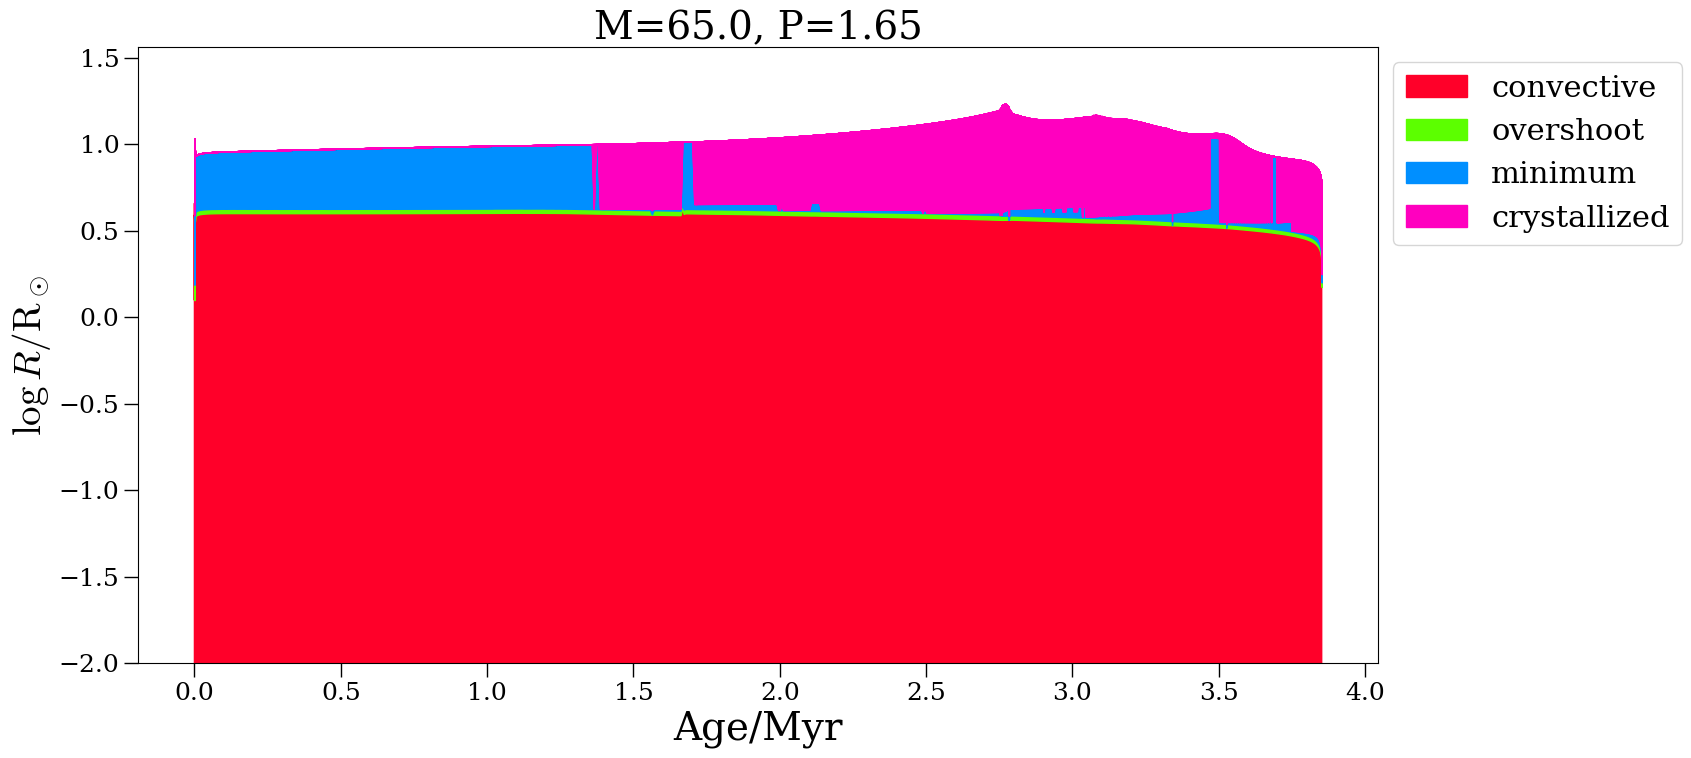

In [43]:
m_key = '65.0'
p_key = '1.65'
model = model_dict[m_key][p_key]
h = mr.MesaData(str(model/'LOGS/history.data'))
profiles = mr.MesaLogDir(str(model/'LOGS'))


fig, ax = plt.subplots(figsize=(16, 8))
cmap = cm.gist_rainbow

t = h.star_age/1e6
r = h.radius
n_mix_regions = 20

types_to_label = []
for i in range(1, n_mix_regions+1):
    type_col = f'mix_relr_type_{i}'
    type_code = h.__getattr__(type_col)[0]
    if type_code not in types_to_label:
        types_to_label.append(type_code)

colors = cmap(np.linspace(0, 1, len(types_to_label)))
    
bottom = np.ones(len(r))*1e-6


for i in range(1, n_mix_regions+1):
    type_col = f'mix_relr_type_{i}'
    top_col = f'mix_relr_top_{i}'
    type_code = h.__getattr__(type_col)[0]
    typ = mix_dict[type_code]
    top = h.__getattr__(top_col)
    
    i_c = types_to_label.index(type_code)
    c = colors[i_c]
    
    #c = cmap(type_code/12)
    ax.fill_between(t, np.log10(bottom*r), np.log10(top*r), color=c)
    #ax.plot(t, np.log10(top*r), lw=0.5, alpha=0.1, c='k')
    
    bottom = top
    
    
ax.set_xlabel('Age/Myr')
ax.set_ylabel('$\\log R/\\mathrm{R}_\\odot$')
ax.set_ylim(-2)

handles = []
for type, c in zip(types_to_label, colors):
    handles.append(Patch(color=c, label=mix_dict[type]))
ax.legend(handles=handles, loc='upper left', bbox_to_anchor=(1,1))

ax.set_title(f'M={m_key}, P={p_key}')

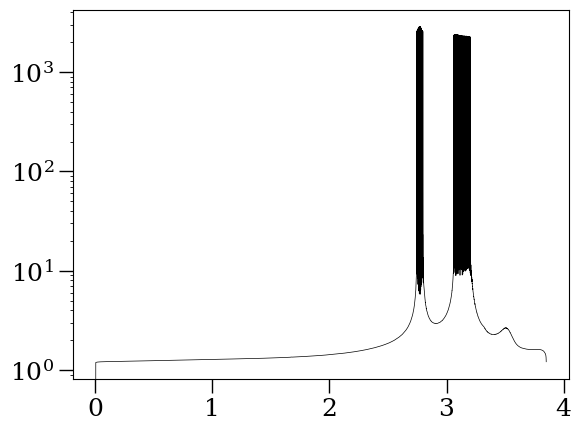

In [44]:
plt.plot(h.star_age/1e6, h.rotational_mdot_boost, 'k-', lw=0.5)
plt.yscale('log')

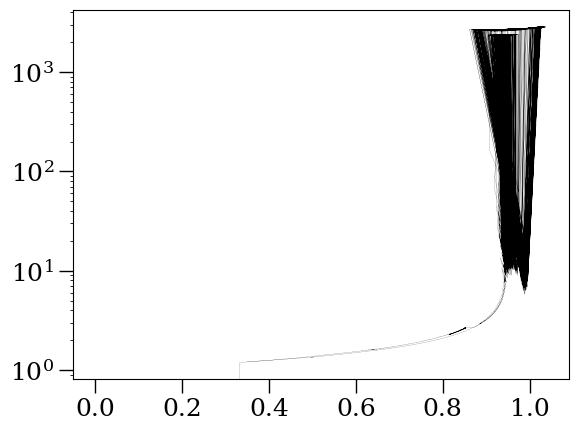

In [45]:
plt.plot(h.surf_avg_omega_div_omega_crit, h.rotational_mdot_boost, 'k-', lw=0.1)
plt.yscale('log')

Text(0.5, 1.0, 'M=65.0, P=2.80')

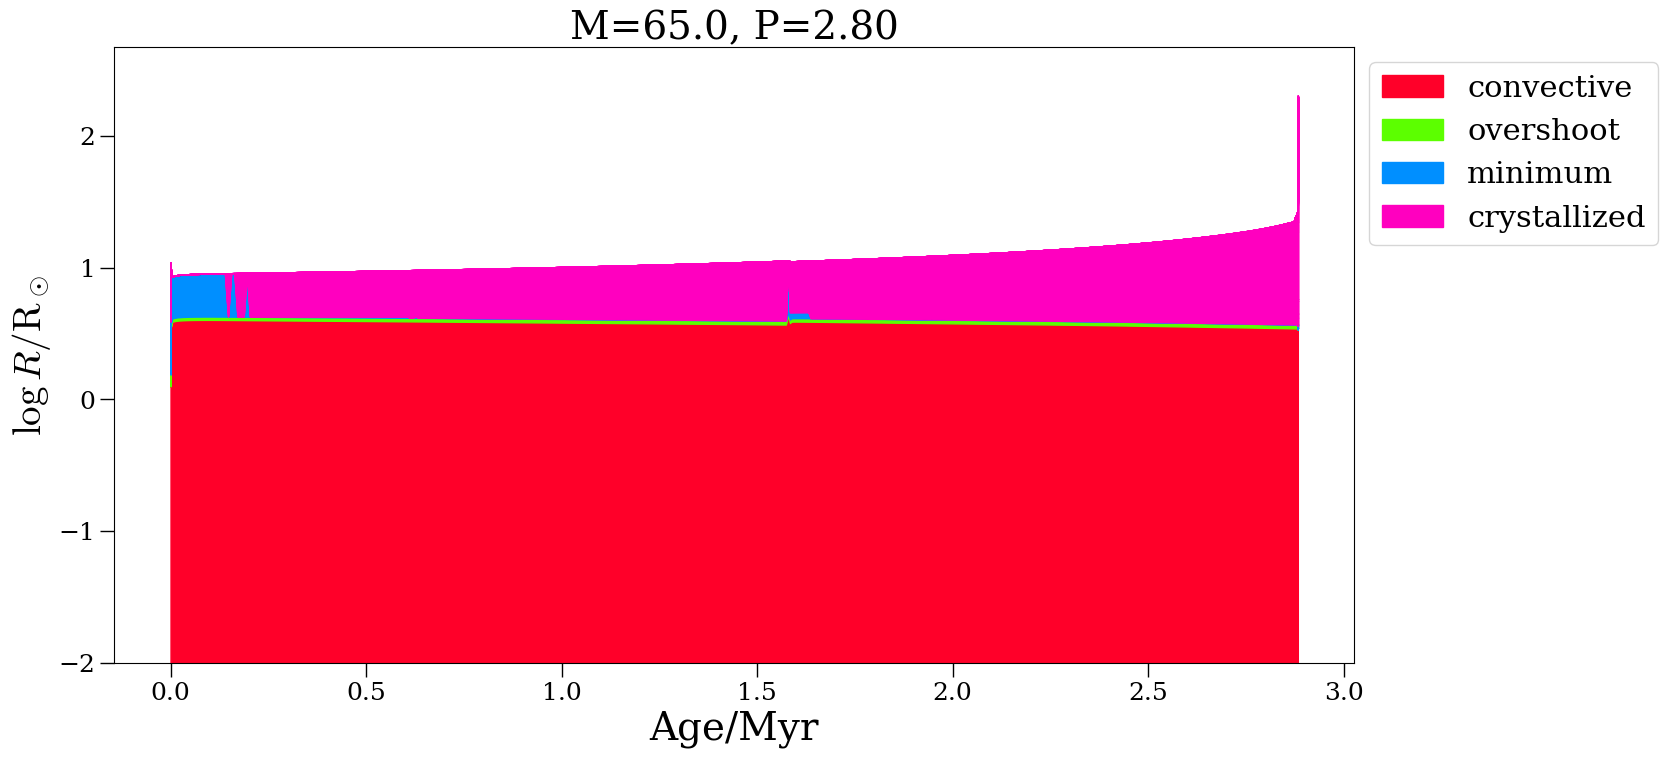

In [46]:
m_key = '65.0'
p_key = '2.80'
model = model_dict[m_key][p_key]
h = mr.MesaData(str(model/'LOGS/history.data'))
profiles = mr.MesaLogDir(str(model/'LOGS'))


fig, ax = plt.subplots(figsize=(16, 8))
cmap = cm.gist_rainbow

t = h.star_age/1e6
r = h.radius
n_mix_regions = 20

types_to_label = []
for i in range(1, n_mix_regions+1):
    type_col = f'mix_relr_type_{i}'
    type_code = h.__getattr__(type_col)[0]
    if type_code not in types_to_label:
        types_to_label.append(type_code)

colors = cmap(np.linspace(0, 1, len(types_to_label)))
    
bottom = np.ones(len(r))*1e-6


for i in range(1, n_mix_regions+1):
    type_col = f'mix_relr_type_{i}'
    top_col = f'mix_relr_top_{i}'
    type_code = h.__getattr__(type_col)[0]
    typ = mix_dict[type_code]
    top = h.__getattr__(top_col)
    
    i_c = types_to_label.index(type_code)
    c = colors[i_c]
    
    #c = cmap(type_code/12)
    ax.fill_between(t, np.log10(bottom*r), np.log10(top*r), color=c)
    #ax.plot(t, np.log10(top*r), lw=0.5, alpha=0.1, c='k')
    
    bottom = top
    
    
ax.set_xlabel('Age/Myr')
ax.set_ylabel('$\\log R/\\mathrm{R}_\\odot$')
ax.set_ylim(-2)

handles = []
for type, c in zip(types_to_label, colors):
    handles.append(Patch(color=c, label=mix_dict[type]))
ax.legend(handles=handles, loc='upper left', bbox_to_anchor=(1,1))

ax.set_title(f'M={m_key}, P={p_key}')

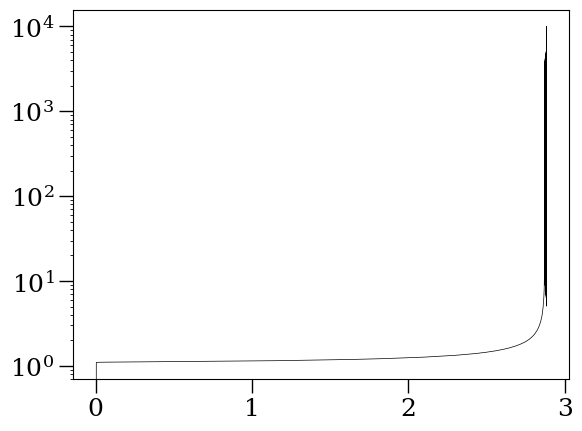

In [47]:
plt.plot(h.star_age/1e6, h.rotational_mdot_boost, 'k-', lw=0.5)
plt.yscale('log')

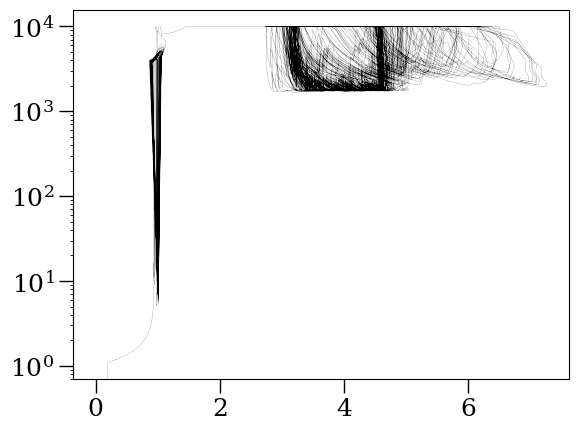

In [48]:
plt.plot(h.surf_avg_omega_div_omega_crit, h.rotational_mdot_boost, 'k-', lw=0.1)
plt.yscale('log')

Text(0.5, 1.0, 'M=110.0, P=0.89')

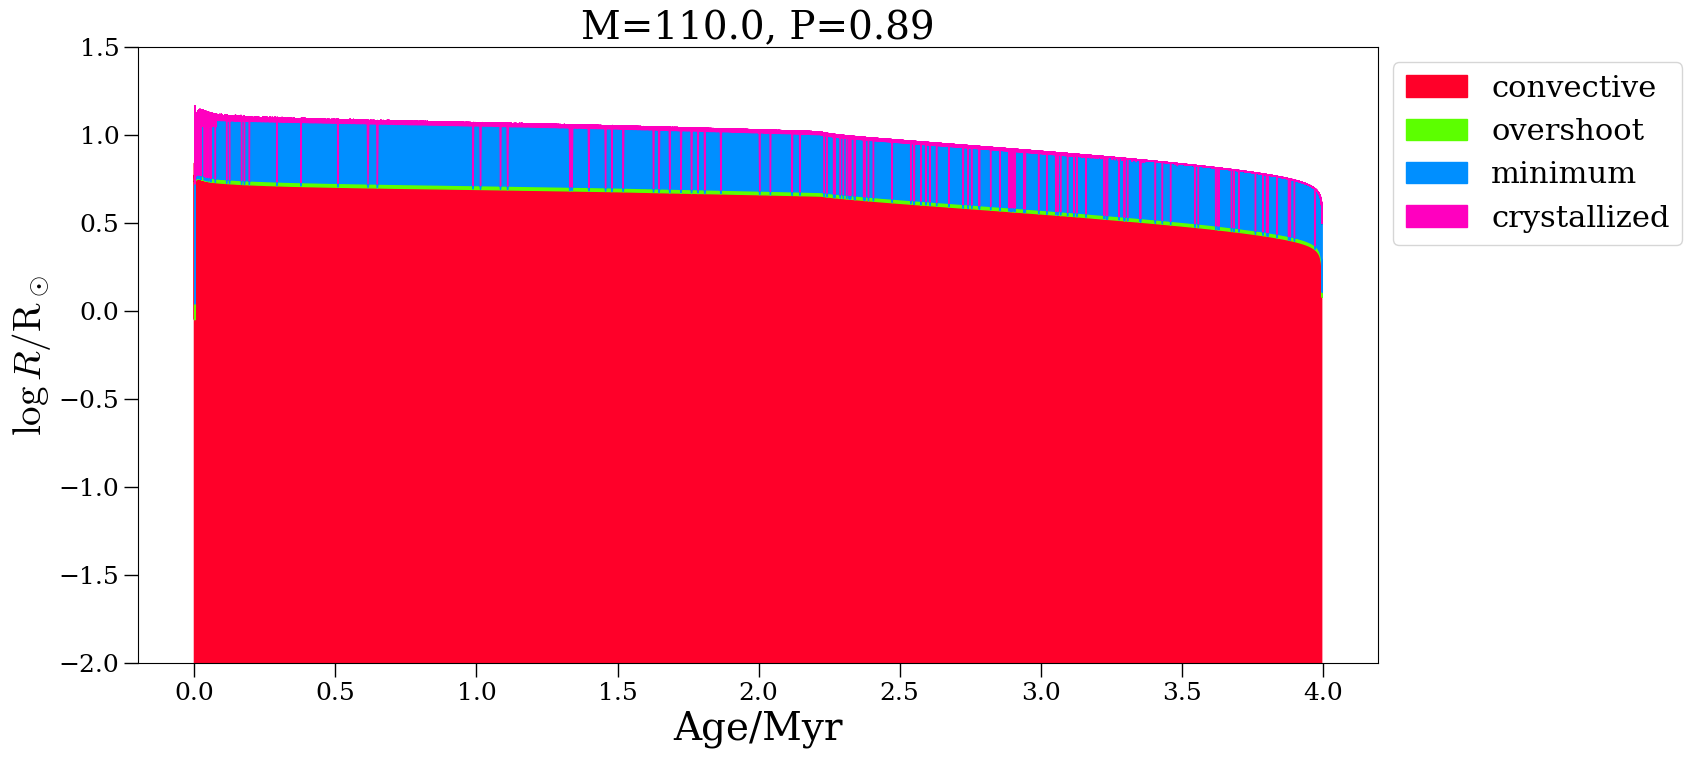

In [49]:
m_key = '110.0'
p_key = '0.89'
model = model_dict[m_key][p_key]
h = mr.MesaData(str(model/'LOGS/history.data'))
profiles = mr.MesaLogDir(str(model/'LOGS'))


fig, ax = plt.subplots(figsize=(16, 8))
cmap = cm.gist_rainbow

t = h.star_age/1e6
r = h.radius
n_mix_regions = 20

types_to_label = []
for i in range(1, n_mix_regions+1):
    type_col = f'mix_relr_type_{i}'
    type_code = h.__getattr__(type_col)[0]
    if type_code not in types_to_label:
        types_to_label.append(type_code)

colors = cmap(np.linspace(0, 1, len(types_to_label)))
    
bottom = np.ones(len(r))*1e-6


for i in range(1, n_mix_regions+1):
    type_col = f'mix_relr_type_{i}'
    top_col = f'mix_relr_top_{i}'
    type_code = h.__getattr__(type_col)[0]
    typ = mix_dict[type_code]
    top = h.__getattr__(top_col)
    
    i_c = types_to_label.index(type_code)
    c = colors[i_c]
    
    #c = cmap(type_code/12)
    ax.fill_between(t, np.log10(bottom*r), np.log10(top*r), color=c)
    #ax.plot(t, np.log10(top*r), lw=0.5, alpha=0.1, c='k')
    
    bottom = top
    
    
ax.set_xlabel('Age/Myr')
ax.set_ylabel('$\\log R/\\mathrm{R}_\\odot$')
ax.set_ylim(-2)

handles = []
for type, c in zip(types_to_label, colors):
    handles.append(Patch(color=c, label=mix_dict[type]))
ax.legend(handles=handles, loc='upper left', bbox_to_anchor=(1,1))

ax.set_title(f'M={m_key}, P={p_key}')

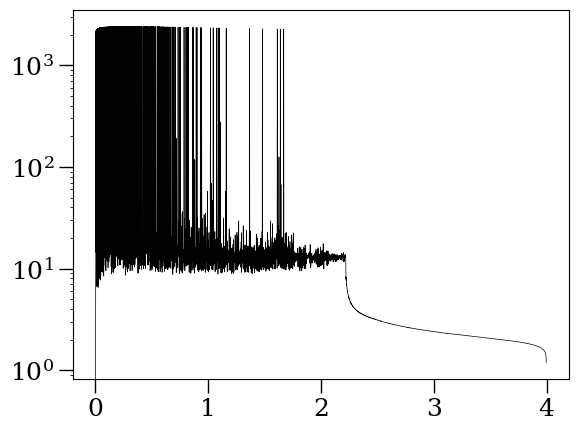

In [50]:
plt.plot(h.star_age/1e6, h.rotational_mdot_boost, 'k-', lw=0.5)
plt.yscale('log')

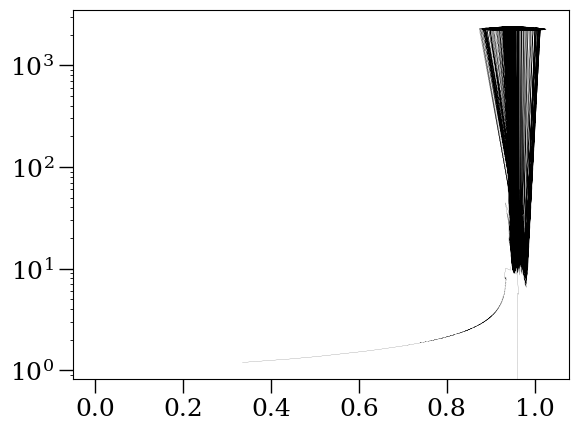

In [51]:
plt.plot(h.surf_avg_omega_div_omega_crit, h.rotational_mdot_boost, 'k-', lw=0.1)
plt.yscale('log')

Text(0.5, 1.0, 'M=180.0, P=1.28')

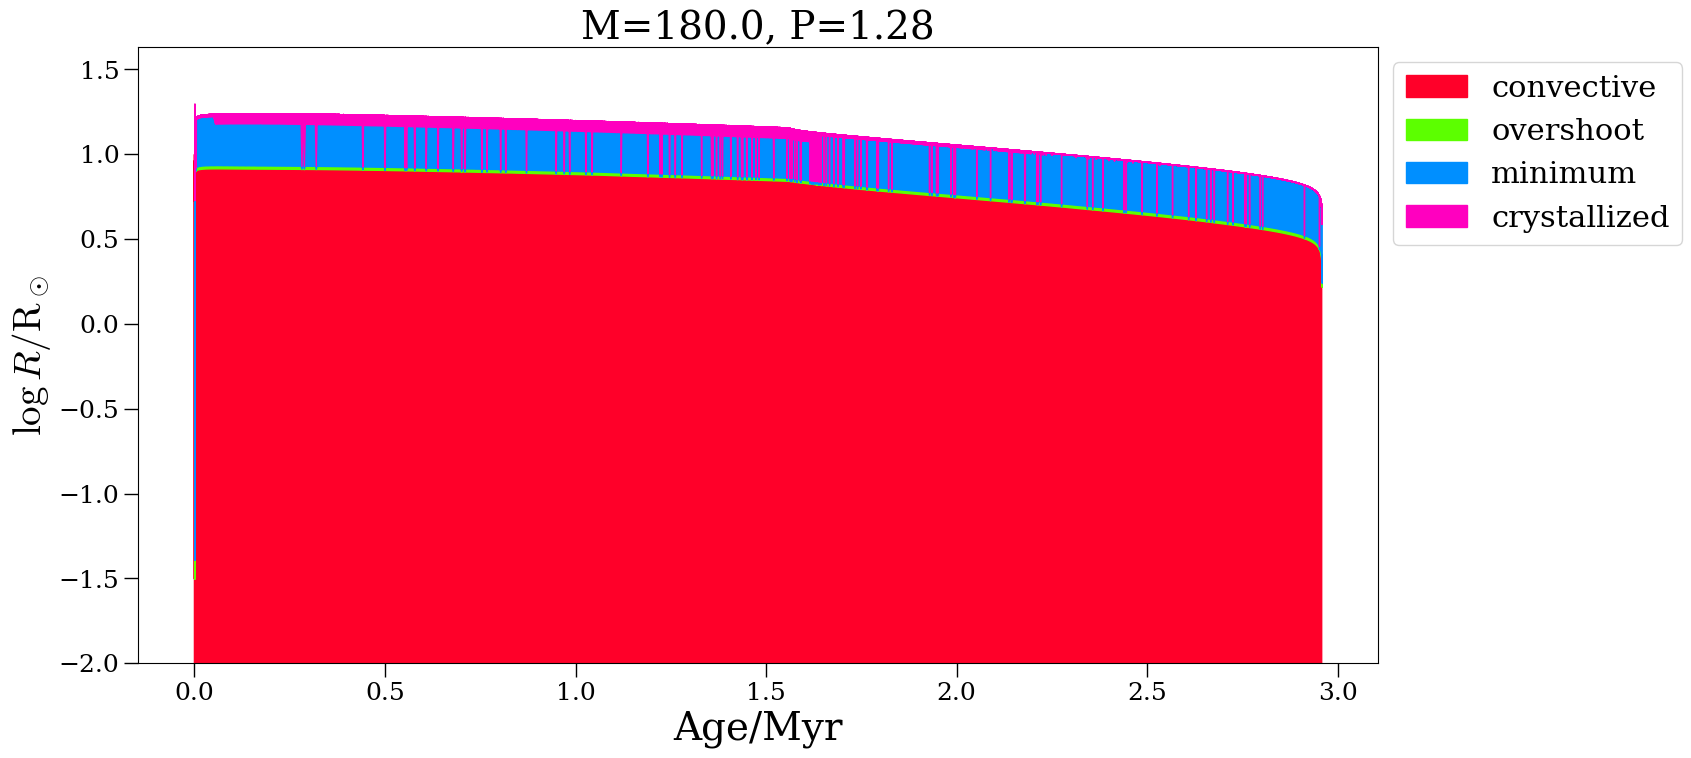

In [52]:
m_key = '180.0'
p_key = '1.28'
model = model_dict[m_key][p_key]
h = mr.MesaData(str(model/'LOGS/history.data'))
profiles = mr.MesaLogDir(str(model/'LOGS'))


fig, ax = plt.subplots(figsize=(16, 8))
cmap = cm.gist_rainbow

t = h.star_age/1e6
r = h.radius
n_mix_regions = 20

types_to_label = []
for i in range(1, n_mix_regions+1):
    type_col = f'mix_relr_type_{i}'
    type_code = h.__getattr__(type_col)[0]
    if type_code not in types_to_label:
        types_to_label.append(type_code)

colors = cmap(np.linspace(0, 1, len(types_to_label)))
    
bottom = np.ones(len(r))*1e-6


for i in range(1, n_mix_regions+1):
    type_col = f'mix_relr_type_{i}'
    top_col = f'mix_relr_top_{i}'
    type_code = h.__getattr__(type_col)[0]
    typ = mix_dict[type_code]
    top = h.__getattr__(top_col)
    
    i_c = types_to_label.index(type_code)
    c = colors[i_c]
    
    #c = cmap(type_code/12)
    ax.fill_between(t, np.log10(bottom*r), np.log10(top*r), color=c)
    #ax.plot(t, np.log10(top*r), lw=0.5, alpha=0.1, c='k')
    
    bottom = top
    
    
ax.set_xlabel('Age/Myr')
ax.set_ylabel('$\\log R/\\mathrm{R}_\\odot$')
ax.set_ylim(-2)

handles = []
for type, c in zip(types_to_label, colors):
    handles.append(Patch(color=c, label=mix_dict[type]))
ax.legend(handles=handles, loc='upper left', bbox_to_anchor=(1,1))

ax.set_title(f'M={m_key}, P={p_key}')

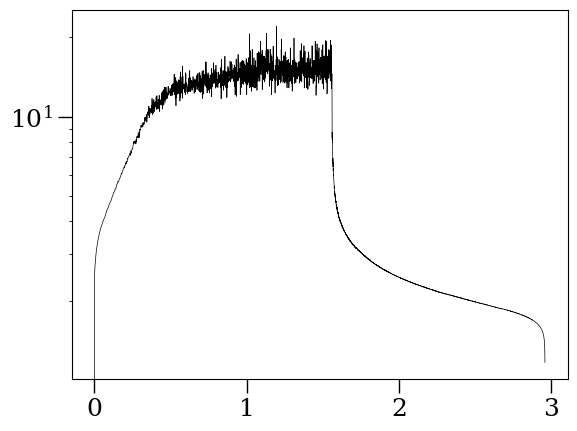

In [53]:
plt.plot(h.star_age/1e6, h.rotational_mdot_boost, 'k-', lw=0.5)
plt.yscale('log')

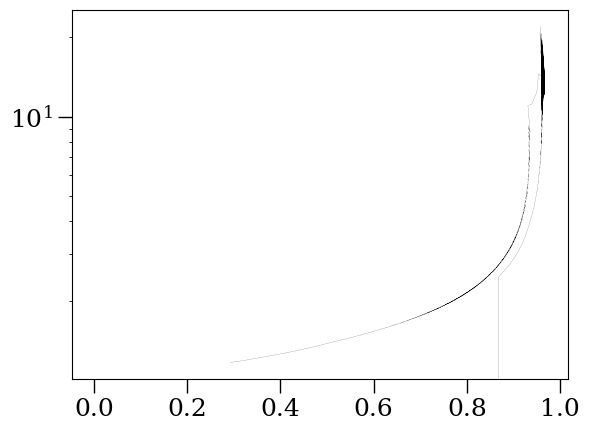

In [54]:
plt.plot(h.surf_avg_omega_div_omega_crit, h.rotational_mdot_boost, 'k-', lw=0.1)
plt.yscale('log')

Text(0.5, 1.0, 'M=180.0, P=1.65')

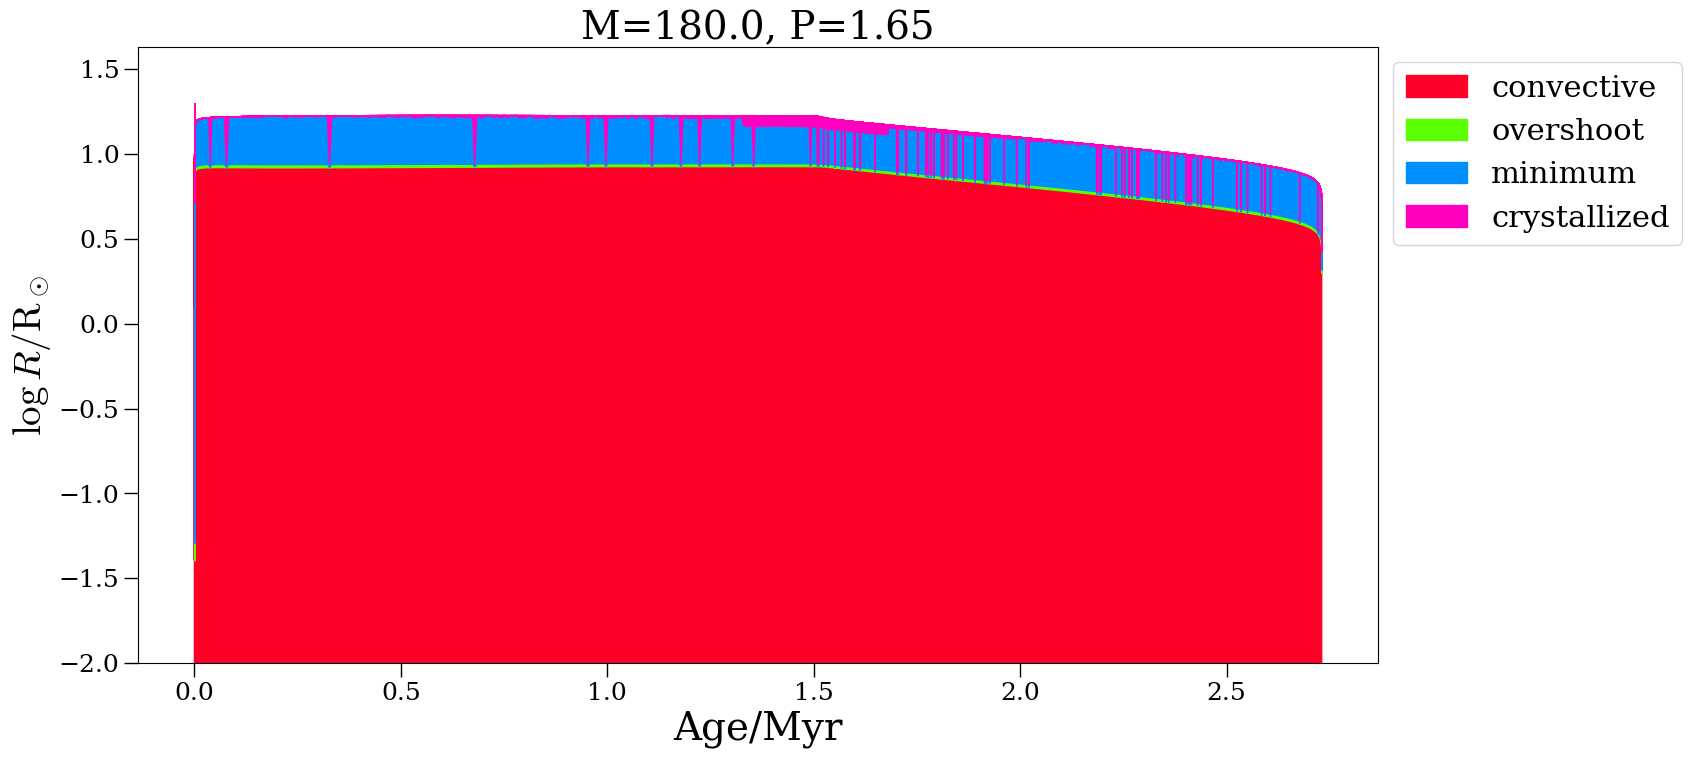

In [55]:
m_key = '180.0'
p_key = '1.65'
model = model_dict[m_key][p_key]
h = mr.MesaData(str(model/'LOGS/history.data'))
profiles = mr.MesaLogDir(str(model/'LOGS'))


fig, ax = plt.subplots(figsize=(16, 8))
cmap = cm.gist_rainbow

t = h.star_age/1e6
r = h.radius
n_mix_regions = 20

types_to_label = []
for i in range(1, n_mix_regions+1):
    type_col = f'mix_relr_type_{i}'
    type_code = h.__getattr__(type_col)[0]
    if type_code not in types_to_label:
        types_to_label.append(type_code)

colors = cmap(np.linspace(0, 1, len(types_to_label)))
    
bottom = np.ones(len(r))*1e-6


for i in range(1, n_mix_regions+1):
    type_col = f'mix_relr_type_{i}'
    top_col = f'mix_relr_top_{i}'
    type_code = h.__getattr__(type_col)[0]
    typ = mix_dict[type_code]
    top = h.__getattr__(top_col)
    
    i_c = types_to_label.index(type_code)
    c = colors[i_c]
    
    #c = cmap(type_code/12)
    ax.fill_between(t, np.log10(bottom*r), np.log10(top*r), color=c)
    #ax.plot(t, np.log10(top*r), lw=0.5, alpha=0.1, c='k')
    
    bottom = top
    
    
ax.set_xlabel('Age/Myr')
ax.set_ylabel('$\\log R/\\mathrm{R}_\\odot$')
ax.set_ylim(-2)

handles = []
for type, c in zip(types_to_label, colors):
    handles.append(Patch(color=c, label=mix_dict[type]))
ax.legend(handles=handles, loc='upper left', bbox_to_anchor=(1,1))

ax.set_title(f'M={m_key}, P={p_key}')

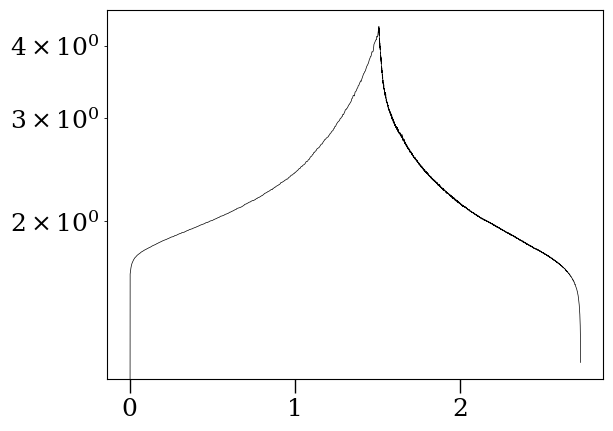

In [56]:
plt.plot(h.star_age/1e6, h.rotational_mdot_boost, 'k-', lw=0.5)
plt.yscale('log')

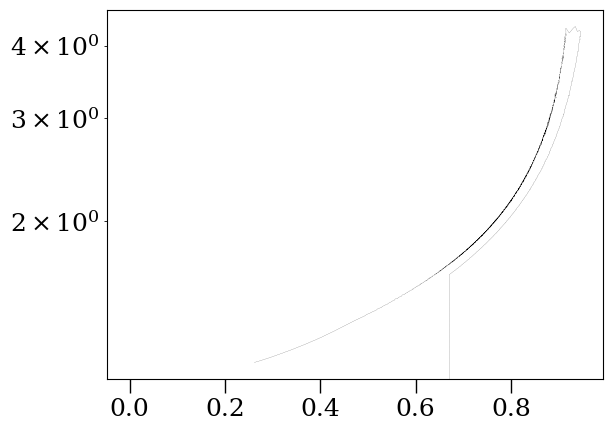

In [57]:
plt.plot(h.surf_avg_omega_div_omega_crit, h.rotational_mdot_boost, 'k-', lw=0.1)
plt.yscale('log')

In [58]:
m_key = '110.0'
p_key = '4.04'
model = model_dict[m_key][p_key]
h = mr.MesaData(str(model/'LOGS/history.data'))
profiles = mr.MesaLogDir(str(model/'LOGS'))


fig, ax = plt.subplots(figsize=(16, 8))
cmap = cm.gist_rainbow

t = h.star_age/1e6
r = h.radius
n_mix_regions = 20

types_to_label = []
for i in range(1, n_mix_regions+1):
    type_col = f'mix_relr_type_{i}'
    type_code = h.__getattr__(type_col)[0]
    if type_code not in types_to_label:
        types_to_label.append(type_code)

colors = cmap(np.linspace(0, 1, len(types_to_label)))
    
bottom = np.ones(len(r))*1e-6


for i in range(1, n_mix_regions+1):
    type_col = f'mix_relr_type_{i}'
    top_col = f'mix_relr_top_{i}'
    type_code = h.__getattr__(type_col)[0]
    typ = mix_dict[type_code]
    top = h.__getattr__(top_col)
    
    i_c = types_to_label.index(type_code)
    c = colors[i_c]
    
    #c = cmap(type_code/12)
    ax.fill_between(t, np.log10(bottom*r), np.log10(top*r), color=c)
    #ax.plot(t, np.log10(top*r), lw=0.5, alpha=0.1, c='k')
    
    bottom = top
    
    
ax.set_xlabel('Age/Myr')
ax.set_ylabel('$\\log R/\\mathrm{R}_\\odot$')
ax.set_ylim(-2)

handles = []
for type, c in zip(types_to_label, colors):
    handles.append(Patch(color=c, label=mix_dict[type]))
ax.legend(handles=handles, loc='upper left', bbox_to_anchor=(1,1))

ax.set_title(f'M={m_key}, P={p_key}')

KeyError: '4.04'

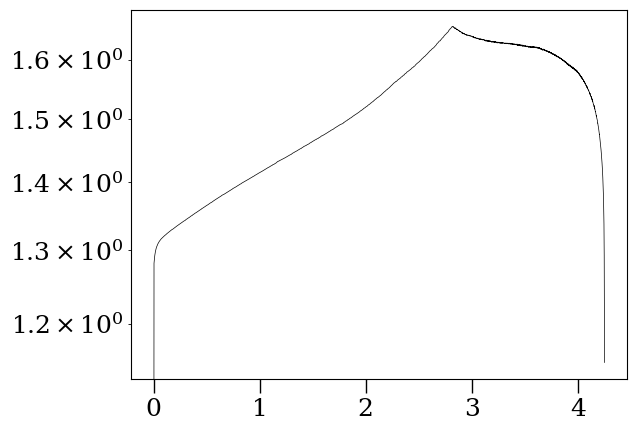

In [ ]:
plt.plot(h.star_age/1e6, h.rotational_mdot_boost, 'k-', lw=0.5)
plt.yscale('log')

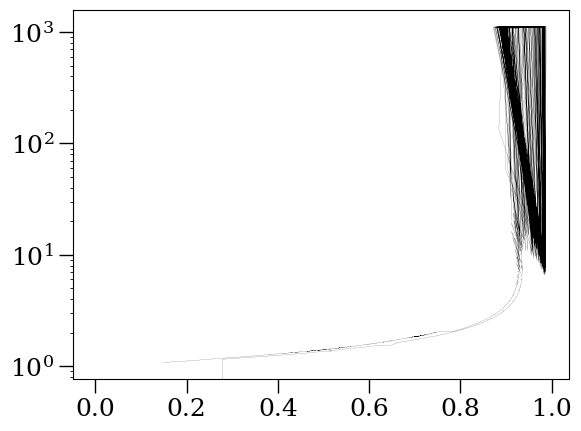

In [ ]:
plt.plot(h.surf_avg_omega_div_omega_crit, h.rotational_mdot_boost, 'k-', lw=0.1)
plt.yscale('log')

### Time resolution

/tmp/ipykernel_2601044/254204014.py:11: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0)


Text(0.5, 1.0, '$M=14.0\\,\\mathrm{M}_\\odot,\\,P=0.48\\,\\mathrm{d}$')

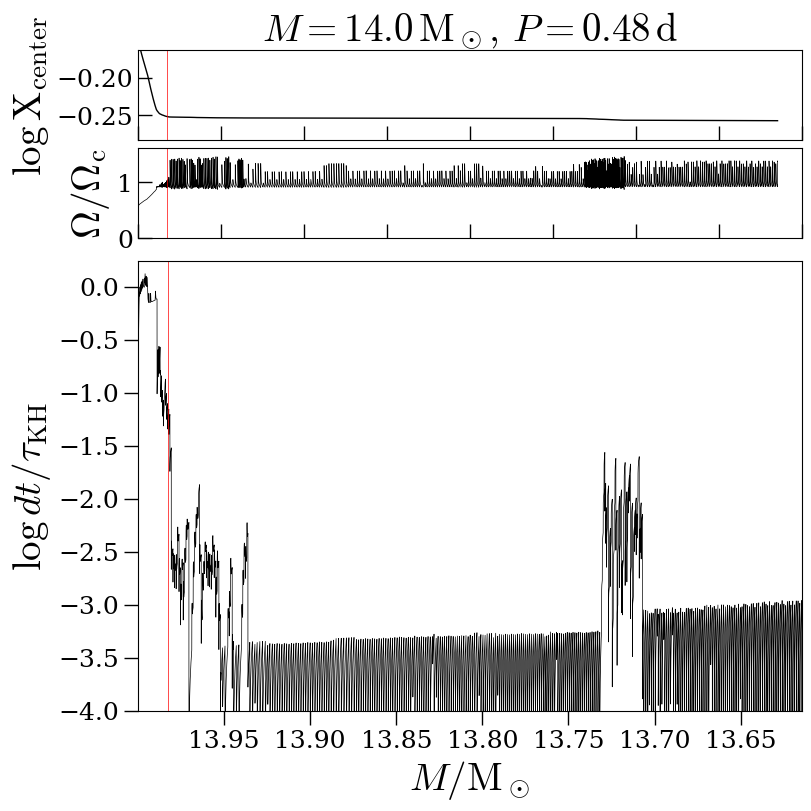

In [83]:
m_key = '14.0'
p_key = '0.48'
model = model_dict[m_key][p_key]
h = mr.MesaData(str(model/'LOGS/history.data'))

fig = plt.figure(figsize=(8, 8), layout='constrained')
gs = fig.add_gridspec(ncols=1, nrows=3, height_ratios=[0.2, 0.2, 1], hspace=0)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[1,0])
ax2 = fig.add_subplot(gs[2,0])
fig.subplots_adjust(hspace=0)

crit_i = np.argmax(h.surf_avg_omega_div_omega_crit>=1)
crit_age = h.star_age[crit_i]
crit_mass = h.star_mass[crit_i]
time_ratio = np.log10(10**h.log_dt/h.kh_timescale)
ax2.plot(h.star_mass, time_ratio,'k-', lw=0.5)
ax2.vlines(crit_mass, min(time_ratio)*1.5, max(time_ratio)*2, color='r', linestyle='-', 
          linewidth=0.5)
ax2.set_ylim(-4, max(time_ratio)*2)
ax2.set_xlim(h.star_mass[0], h.star_mass[-1])
ax2.set_xlabel('$M/\\mathrm{M}_\\odot$')
ax2.set_ylabel('$\\log dt/\\tau_\\mathrm{KH}$')

ax1.plot(h.star_mass, h.surf_avg_omega_div_omega_crit, 'k-', lw=0.5)
ax1.set_ylabel('$\\Omega/\\Omega_\\mathrm{c}$')
ax1.set_xlim(h.star_mass[0], h.star_mass[-1])
ax1.set_xticks(ax2.get_xticks())
ax1.tick_params(direction='in')
ax1.set_xticklabels([])

ax1.vlines(crit_mass, min(h.surf_avg_omega_div_omega_crit)*1.1, max(h.surf_avg_omega_div_omega_crit)*1.1, color='r', linestyle='-', 
          linewidth=0.5)
ax1.set_ylim(min(h.surf_avg_omega_div_omega_crit)*1.1, max(h.surf_avg_omega_div_omega_crit)*1.1)

ax0.plot(h.star_mass, np.log10(h.center_h1), 'k-', lw=1)
ax0.set_xlim(h.star_mass[0], h.star_mass[-1])
ax0.set_xticks(ax2.get_xticks())
ax0.tick_params(direction='in')
ax0.set_xticklabels([])
ax0.vlines(crit_mass, min(np.log10(h.center_h1))*1.1, max(np.log10(h.center_h1))*1.1, color='r', linestyle='-',
           linewidth=0.5)
ax0.set_ylim(min(np.log10(h.center_h1))*1.1, max(np.log10(h.center_h1))*1.1)
ax0.set_ylabel('$\\log\\mathrm{X}_\\mathrm{center}$')

ax0.set_title(f'$M={m_key}\\,\\mathrm{{M}}_\\odot,\\,P={p_key}\\,\\mathrm{{d}}$')

/tmp/ipykernel_2601044/1801450920.py:11: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0)


Text(0.5, 1.0, '$M=39.0\\,\\mathrm{M}_\\odot,\\,P=0.89\\,\\mathrm{d}$')

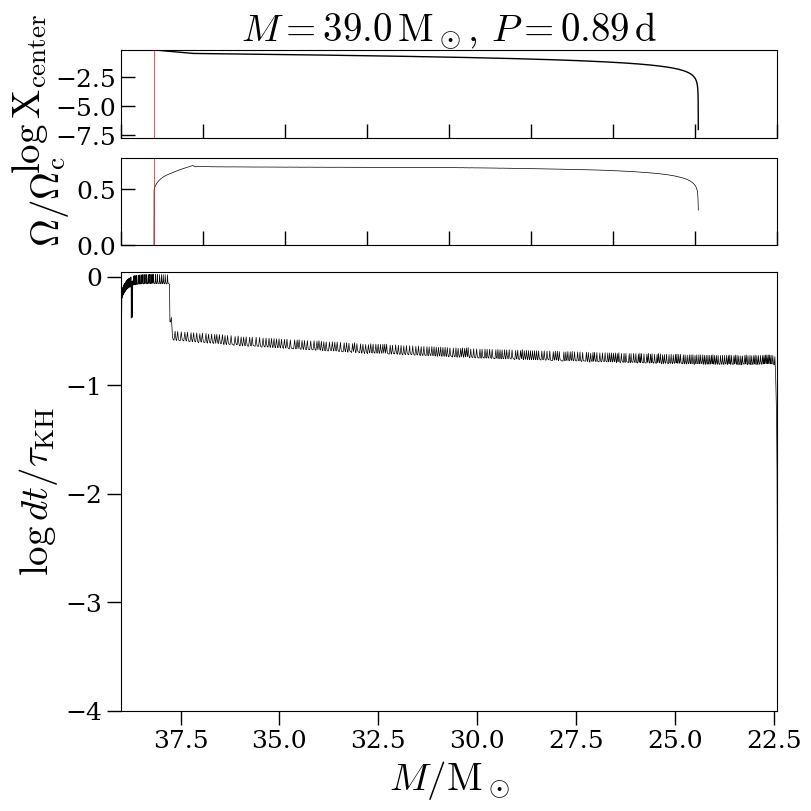

In [84]:
m_key = '39.0'
p_key = '0.89'
model = model_dict[m_key][p_key]
h = mr.MesaData(str(model/'LOGS/history.data'))

fig = plt.figure(figsize=(8, 8), layout='constrained')
gs = fig.add_gridspec(ncols=1, nrows=3, height_ratios=[0.2, 0.2, 1], hspace=0)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[1,0])
ax2 = fig.add_subplot(gs[2,0])
fig.subplots_adjust(hspace=0)

crit_i = np.argmax(h.surf_avg_omega_div_omega_crit>=1)
crit_age = h.star_age[crit_i]
crit_mass = h.star_mass[crit_i]
time_ratio = np.log10(10**h.log_dt/h.kh_timescale)
ax2.plot(h.star_mass, time_ratio,'k-', lw=0.5)
ax2.vlines(crit_mass, min(time_ratio)*1.5, max(time_ratio)*2, color='r', linestyle='-', 
          linewidth=0.5)
ax2.set_ylim(-4, max(time_ratio)*2)
ax2.set_xlim(h.star_mass[0], h.star_mass[-1])
ax2.set_xlabel('$M/\\mathrm{M}_\\odot$')
ax2.set_ylabel('$\\log dt/\\tau_\\mathrm{KH}$')

ax1.plot(h.star_mass, h.surf_avg_omega_div_omega_crit, 'k-', lw=0.5)
ax1.set_ylabel('$\\Omega/\\Omega_\\mathrm{c}$')
ax1.set_xlim(h.star_mass[0], h.star_mass[-1])
ax1.set_xticks(ax2.get_xticks())
ax1.tick_params(direction='in')
ax1.set_xticklabels([])

ax1.vlines(crit_mass, min(h.surf_avg_omega_div_omega_crit)*1.1, max(h.surf_avg_omega_div_omega_crit)*1.1, color='r', linestyle='-', 
          linewidth=0.5)
ax1.set_ylim(min(h.surf_avg_omega_div_omega_crit)*1.1, max(h.surf_avg_omega_div_omega_crit)*1.1)

ax0.plot(h.star_mass, np.log10(h.center_h1), 'k-', lw=1)
ax0.set_xlim(h.star_mass[0], h.star_mass[-1])
ax0.set_xticks(ax2.get_xticks())
ax0.tick_params(direction='in')
ax0.set_xticklabels([])
ax0.vlines(crit_mass, min(np.log10(h.center_h1))*1.1, max(np.log10(h.center_h1))*1.1, color='r', linestyle='-',
           linewidth=0.5)
ax0.set_ylim(min(np.log10(h.center_h1))*1.1, max(np.log10(h.center_h1))*1.1)
ax0.set_ylabel('$\\log\\mathrm{X}_\\mathrm{center}$')

ax0.set_title(f'$M={m_key}\\,\\mathrm{{M}}_\\odot,\\,P={p_key}\\,\\mathrm{{d}}$')

/tmp/ipykernel_2601044/2769825327.py:11: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0)


Text(0.5, 1.0, '$M=65.0\\,\\mathrm{M}_\\odot,\\,P=1.28\\,\\mathrm{d}$')

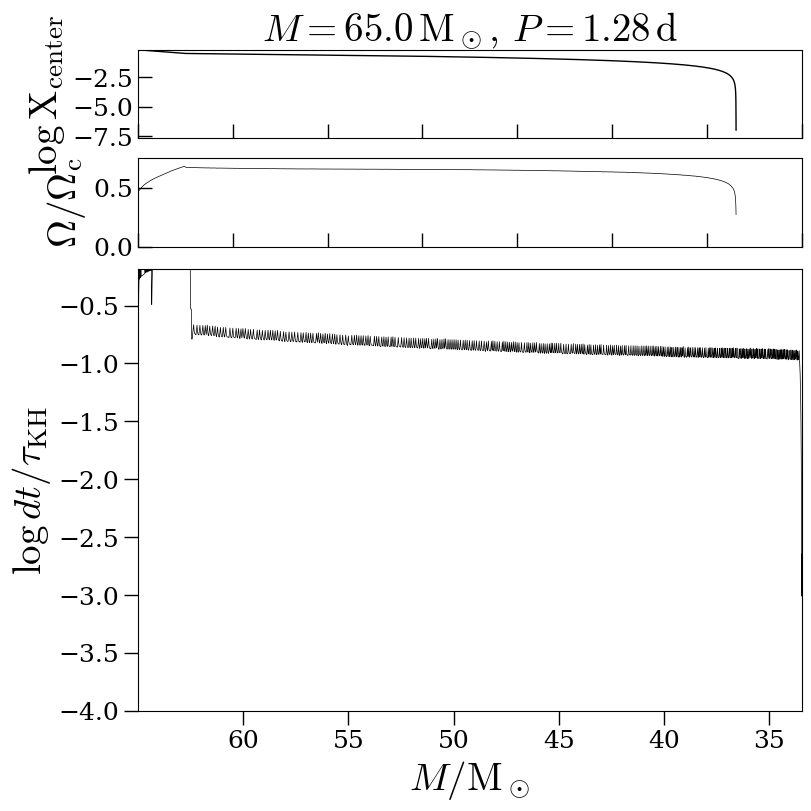

In [85]:
m_key = '65.0'
p_key = '1.28'
model = model_dict[m_key][p_key]
h = mr.MesaData(str(model/'LOGS/history.data'))

fig = plt.figure(figsize=(8, 8), layout='constrained')
gs = fig.add_gridspec(ncols=1, nrows=3, height_ratios=[0.2, 0.2, 1], hspace=0)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[1,0])
ax2 = fig.add_subplot(gs[2,0])
fig.subplots_adjust(hspace=0)

crit_i = np.argmax(h.surf_avg_omega_div_omega_crit>=1)
crit_age = h.star_age[crit_i]
crit_mass = h.star_mass[crit_i]
time_ratio = np.log10(10**h.log_dt/h.kh_timescale)
ax2.plot(h.star_mass, time_ratio,'k-', lw=0.5)
ax2.vlines(crit_mass, min(time_ratio)*1.5, max(time_ratio)*2, color='r', linestyle='-', 
          linewidth=0.5)
ax2.set_ylim(-4, max(time_ratio)*2)
ax2.set_xlim(h.star_mass[0], h.star_mass[-1])
ax2.set_xlabel('$M/\\mathrm{M}_\\odot$')
ax2.set_ylabel('$\\log dt/\\tau_\\mathrm{KH}$')

ax1.plot(h.star_mass, h.surf_avg_omega_div_omega_crit, 'k-', lw=0.5)
ax1.set_ylabel('$\\Omega/\\Omega_\\mathrm{c}$')
ax1.set_xlim(h.star_mass[0], h.star_mass[-1])
ax1.set_xticks(ax2.get_xticks())
ax1.tick_params(direction='in')
ax1.set_xticklabels([])

ax1.vlines(crit_mass, min(h.surf_avg_omega_div_omega_crit)*1.1, max(h.surf_avg_omega_div_omega_crit)*1.1, color='r', linestyle='-', 
          linewidth=0.5)
ax1.set_ylim(min(h.surf_avg_omega_div_omega_crit)*1.1, max(h.surf_avg_omega_div_omega_crit)*1.1)

ax0.plot(h.star_mass, np.log10(h.center_h1), 'k-', lw=1)
ax0.set_xlim(h.star_mass[0], h.star_mass[-1])
ax0.set_xticks(ax2.get_xticks())
ax0.tick_params(direction='in')
ax0.set_xticklabels([])
ax0.vlines(crit_mass, min(np.log10(h.center_h1))*1.1, max(np.log10(h.center_h1))*1.1, color='r', linestyle='-',
           linewidth=0.5)
ax0.set_ylim(min(np.log10(h.center_h1))*1.1, max(np.log10(h.center_h1))*1.1)
ax0.set_ylabel('$\\log\\mathrm{X}_\\mathrm{center}$')

ax0.set_title(f'$M={m_key}\\,\\mathrm{{M}}_\\odot,\\,P={p_key}\\,\\mathrm{{d}}$')

/tmp/ipykernel_2601044/1512955857.py:11: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0)


Text(0.5, 1.0, '$M=65.0\\,\\mathrm{M}_\\odot,\\,P=2.80\\,\\mathrm{d}$')

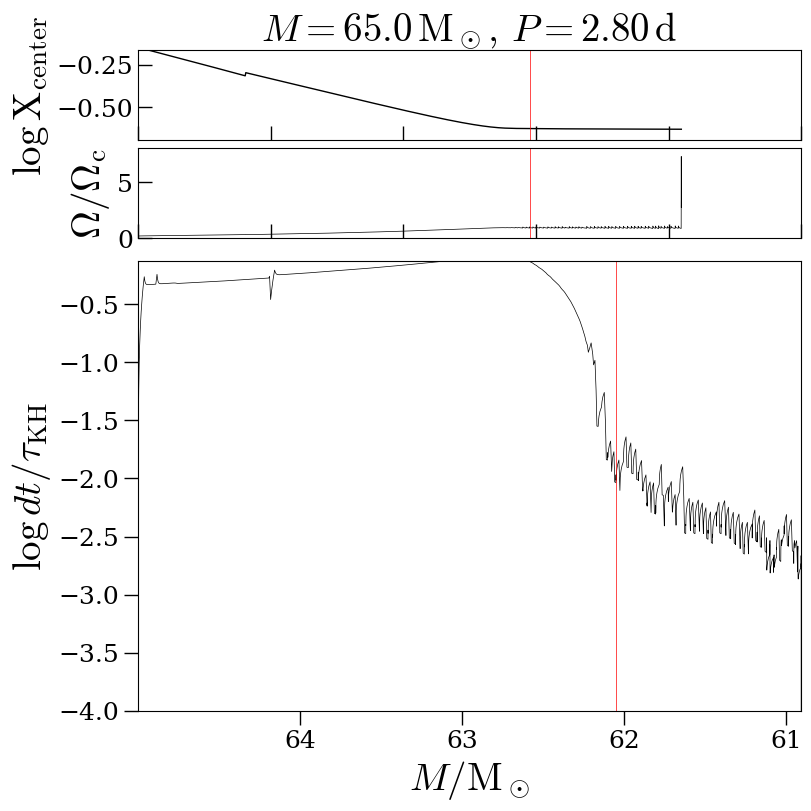

In [86]:
m_key = '65.0'
p_key = '2.80'
model = model_dict[m_key][p_key]
h = mr.MesaData(str(model/'LOGS/history.data'))

fig = plt.figure(figsize=(8, 8), layout='constrained')
gs = fig.add_gridspec(ncols=1, nrows=3, height_ratios=[0.2, 0.2, 1], hspace=0)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[1,0])
ax2 = fig.add_subplot(gs[2,0])
fig.subplots_adjust(hspace=0)

crit_i = np.argmax(h.surf_avg_omega_div_omega_crit>=1)
crit_age = h.star_age[crit_i]
crit_mass = h.star_mass[crit_i]
time_ratio = np.log10(10**h.log_dt/h.kh_timescale)
ax2.plot(h.star_mass, time_ratio,'k-', lw=0.5)
ax2.vlines(crit_mass, min(time_ratio)*1.5, max(time_ratio)*2, color='r', linestyle='-', 
          linewidth=0.5)
ax2.set_ylim(-4, max(time_ratio)*2)
ax2.set_xlim(h.star_mass[0], h.star_mass[-1])
ax2.set_xlabel('$M/\\mathrm{M}_\\odot$')
ax2.set_ylabel('$\\log dt/\\tau_\\mathrm{KH}$')

ax1.plot(h.star_mass, h.surf_avg_omega_div_omega_crit, 'k-', lw=0.5)
ax1.set_ylabel('$\\Omega/\\Omega_\\mathrm{c}$')
ax1.set_xlim(h.star_mass[0], h.star_mass[-1])
ax1.set_xticks(ax2.get_xticks())
ax1.tick_params(direction='in')
ax1.set_xticklabels([])

ax1.vlines(crit_mass, min(h.surf_avg_omega_div_omega_crit)*1.1, max(h.surf_avg_omega_div_omega_crit)*1.1, color='r', linestyle='-', 
          linewidth=0.5)
ax1.set_ylim(min(h.surf_avg_omega_div_omega_crit)*1.1, max(h.surf_avg_omega_div_omega_crit)*1.1)

ax0.plot(h.star_mass, np.log10(h.center_h1), 'k-', lw=1)
ax0.set_xlim(h.star_mass[0], h.star_mass[-1])
ax0.set_xticks(ax2.get_xticks())
ax0.tick_params(direction='in')
ax0.set_xticklabels([])
ax0.vlines(crit_mass, min(np.log10(h.center_h1))*1.1, max(np.log10(h.center_h1))*1.1, color='r', linestyle='-',
           linewidth=0.5)
ax0.set_ylim(min(np.log10(h.center_h1))*1.1, max(np.log10(h.center_h1))*1.1)
ax0.set_ylabel('$\\log\\mathrm{X}_\\mathrm{center}$')

ax0.set_title(f'$M={m_key}\\,\\mathrm{{M}}_\\odot,\\,P={p_key}\\,\\mathrm{{d}}$')

/tmp/ipykernel_3584668/557198215.py:11: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0)


Text(0.5, 1.0, '$M=110.0\\,\\mathrm{M}_\\odot,\\,P=0.89\\,\\mathrm{d}$')

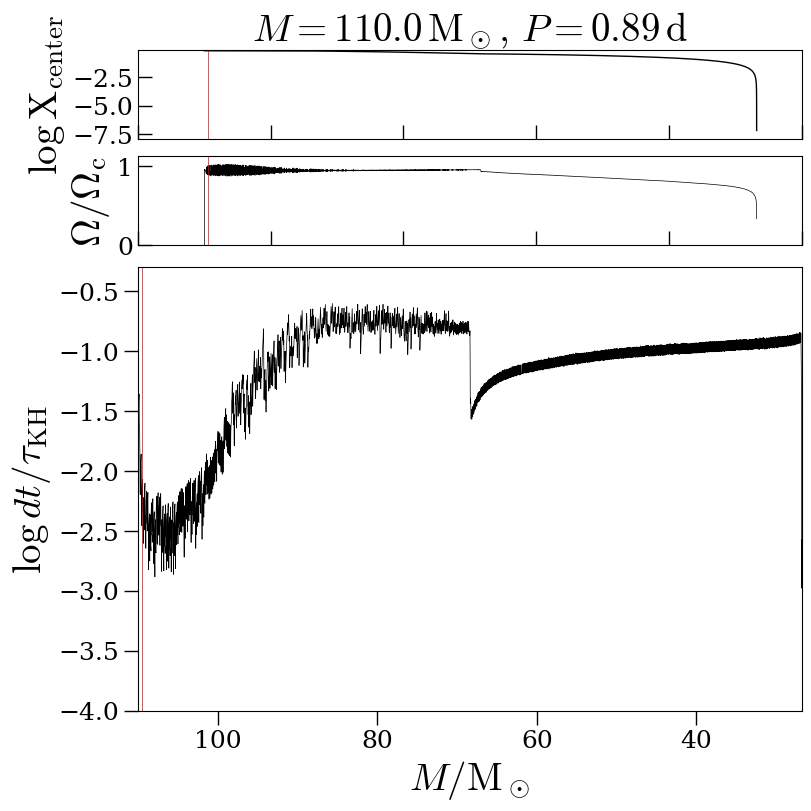

In [14]:
m_key = '110.0'
p_key = '0.89'
model = model_dict[m_key][p_key]
h = mr.MesaData(str(model/'LOGS/history.data'))

fig = plt.figure(figsize=(8, 8), layout='constrained')
gs = fig.add_gridspec(ncols=1, nrows=3, height_ratios=[0.2, 0.2, 1], hspace=0)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[1,0])
ax2 = fig.add_subplot(gs[2,0])
fig.subplots_adjust(hspace=0)

crit_i = np.argmax(h.surf_avg_omega_div_omega_crit>=1)
crit_age = h.star_age[crit_i]
crit_mass = h.star_mass[crit_i]
time_ratio = np.log10(10**h.log_dt/h.kh_timescale)
ax2.plot(h.star_mass, time_ratio,'k-', lw=0.5)
ax2.vlines(crit_mass, min(time_ratio)*1.5, max(time_ratio)/2, color='r', linestyle='-', 
          linewidth=0.5)
ax2.set_ylim(-4, max(time_ratio)/2)
ax2.set_xlim(h.star_mass[0], h.star_mass[-1])
ax2.set_xlabel('$M/\\mathrm{M}_\\odot$')
ax2.set_ylabel('$\\log dt/\\tau_\\mathrm{KH}$')

ax1.plot(h.star_mass, h.surf_avg_omega_div_omega_crit, 'k-', lw=0.5)
ax1.set_ylabel('$\\Omega/\\Omega_\\mathrm{c}$')
ax1.set_xlim(h.star_mass[0], h.star_mass[-1])
ax1.set_xticks(ax2.get_xticks())
ax1.tick_params(direction='in')
ax1.set_xticklabels([])

ax1.vlines(crit_mass, min(h.surf_avg_omega_div_omega_crit)*1.1, max(h.surf_avg_omega_div_omega_crit)*1.1, color='r', linestyle='-', 
          linewidth=0.5)
ax1.set_ylim(min(h.surf_avg_omega_div_omega_crit)*1.1, max(h.surf_avg_omega_div_omega_crit)*1.1)

ax0.plot(h.star_mass, np.log10(h.center_h1), 'k-', lw=1)
ax0.set_xlim(h.star_mass[0], h.star_mass[-1])
ax0.set_xticks(ax2.get_xticks())
ax0.tick_params(direction='in')
ax0.set_xticklabels([])
ax0.vlines(crit_mass, min(np.log10(h.center_h1))*1.1, max(np.log10(h.center_h1))/2, color='r', linestyle='-',
           linewidth=0.5)
ax0.set_ylim(min(np.log10(h.center_h1))*1.1, max(np.log10(h.center_h1))/2)
ax0.set_ylabel('$\\log\\mathrm{X}_\\mathrm{center}$')

ax0.set_title(f'$M={m_key}\\,\\mathrm{{M}}_\\odot,\\,P={p_key}\\,\\mathrm{{d}}$')

## REF

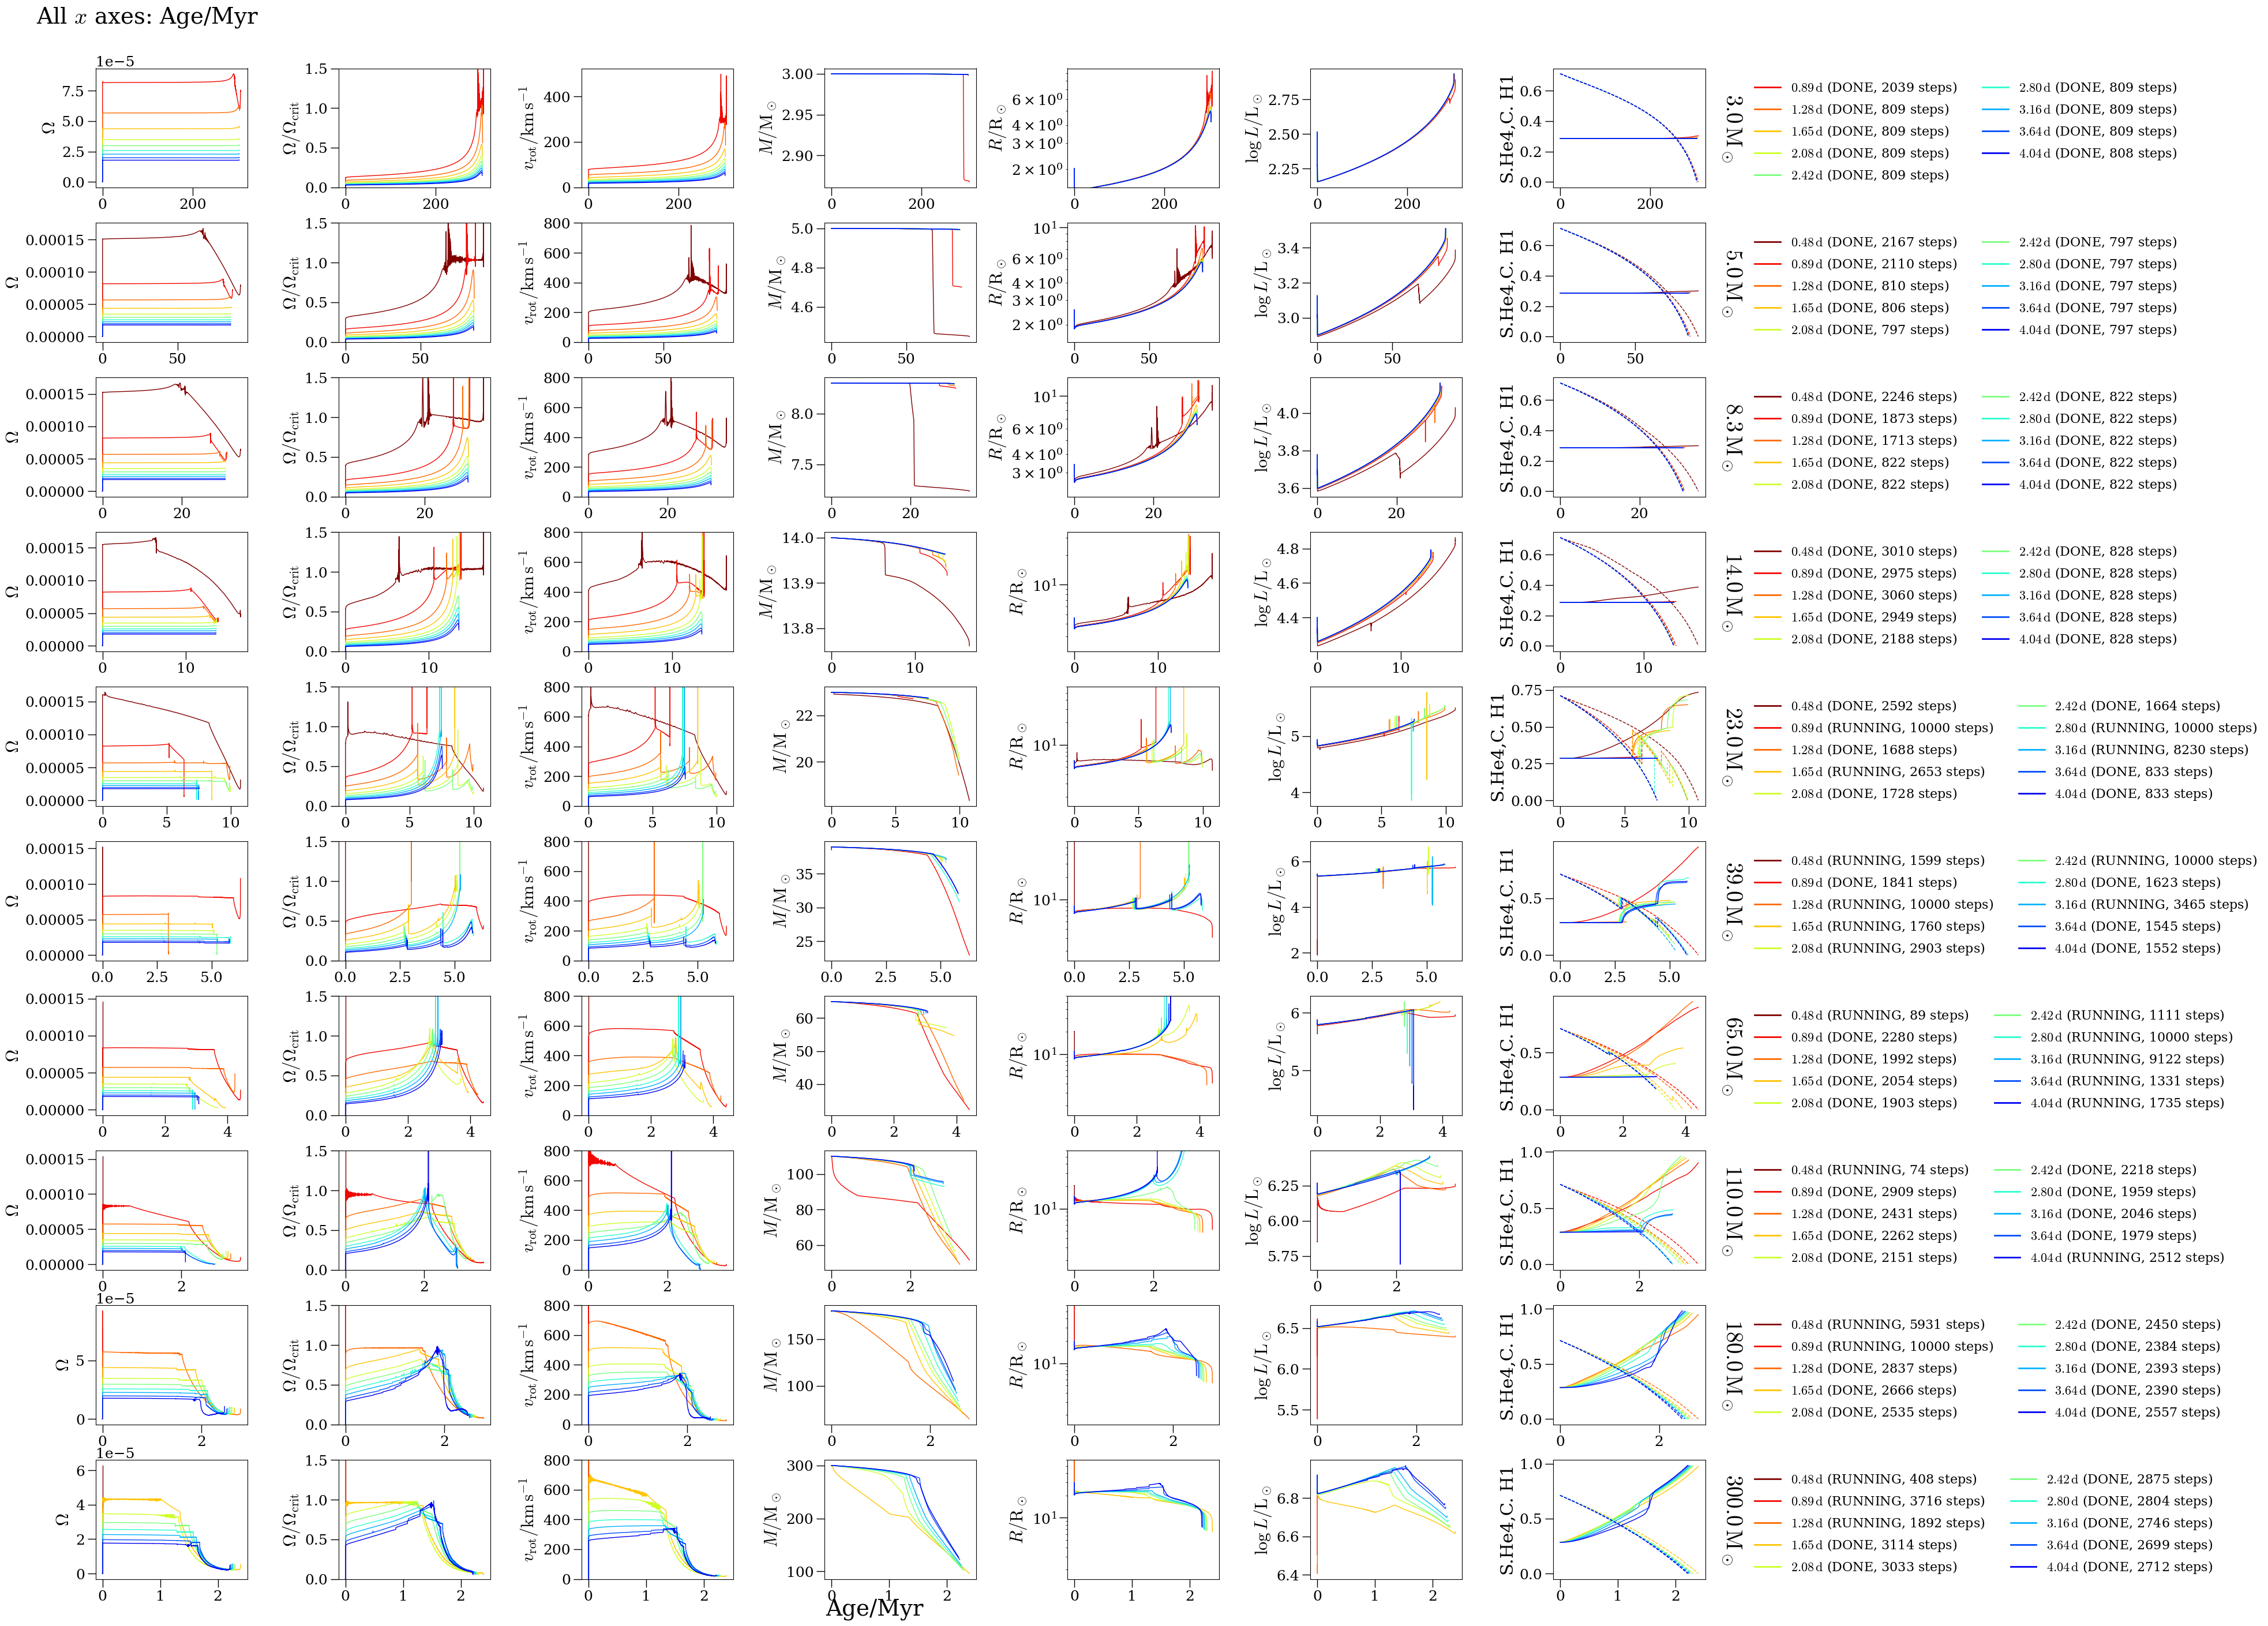

In [9]:
cmap = cm.jet_r
col_indices = [0, 1, 2, 3, 4, 5, 6]
col_labels = ['$\\Omega$',
              '$\\Omega/\\Omega_\\mathrm{crit}$',
              '$v_\\mathrm{rot}/\\mathrm{km}\\,\\mathrm{s}^{-1}$',
              '$M/\\mathrm{M}_\\odot$',
              '$R/\\mathrm{R}_\\odot$',
              '$\\log L/\\mathrm{L}_\\odot$',
              'S.He4,C. H1']
n_cols = len(col_labels)
fig, axes = plt.subplots(len(model_ms), n_cols, figsize=(36, 34), sharex='row')
fig.subplots_adjust(wspace=0.6, hspace=0.3)

for m_key, ax_row in zip(model_ms, axes):
    w_models = model_dict[m_key]
    legend_handles = list()
    for w_i, w in enumerate(model_ws[::-1]):
        c = cmap(w_i/len(model_ws))
        model = w_models[w]
        try:
            h = mr.MesaData(str(model/'LOGS/history.data'))
        except:
            continue
        ax_row, handle = monitor(w, h, ax_row, c=c, col_indices=col_indices)
        legend_handles.append(handle)
    ax_row[-1].text(1.1, 0.5, f'${float(m_key):.1f}\\,\\mathrm{{M}}_\\odot$', ha='left', va='center', 
                   rotation=-90, transform=ax_row[-1].transAxes, fontsize=28)
    ax_row[-1].legend(handles=legend_handles, frameon=False, loc='upper left', 
                      bbox_to_anchor=(1.25, 1), fontsize=16, ncol=2)
    
for i, label in zip(col_indices, col_labels):
    for ax_row in axes:
        ax = ax_row[i]
        ax.set_ylabel(label, fontsize=22)
        #ax.text(0.5, 1.1, label, ha='center', va='bottom', transform=ax.transAxes)
        

# stars that "blow up" due to attempting to impose hyper-critical reach 
# values so high for some of the parameters that they squeeze down the
# curves for normal evolution
# we set some convenient upper limits to allow for proper visualization
for ax_row in axes:
    ax_row[col_indices[1]].set_ylim(0, min(1.5, ax_row[col_indices[1]].get_ylim()[1]))  # omega_div_omega_crit
    ax_row[col_indices[2]].set_ylim(0, min(800, ax_row[col_indices[2]].get_ylim()[1]))  # surf_avg_v_rot
    ax_row[col_indices[4]].set_ylim(max(1.5, ax_row[col_indices[4]].get_ylim()[0]), min(60, ax_row[col_indices[4]].get_ylim()[1]))  # radius
    ax_row[col_indices[4]].set_yscale('log')
        
# xlabel
fig.text(0.5, 0.1, 'Age/Myr', ha='center', va='top', transform=fig.transFigure)
fig.text(0.15, 0.9, 'All $x$ axes: Age/Myr', ha='center', va='bottom', transform=fig.transFigure)

fig.savefig('figures/full_monitor_panel.pdf', bbox_inches='tight')
fig.savefig('figures/full_monitor_panel.png', bbox_inches='tight')    

1 of 90
2 of 90
3 of 90
4 of 90
5 of 90
6 of 90
7 of 90
8 of 90
9 of 90
10 of 90
11 of 90
12 of 90
13 of 90
14 of 90
15 of 90
16 of 90
17 of 90
18 of 90
19 of 90
20 of 90
21 of 90
22 of 90
23 of 90
24 of 90
25 of 90
26 of 90
27 of 90
28 of 90
29 of 90
30 of 90
31 of 90
32 of 90
33 of 90
34 of 90
35 of 90
36 of 90
37 of 90
38 of 90
39 of 90
40 of 90
41 of 90
42 of 90
43 of 90
44 of 90
45 of 90
46 of 90
47 of 90
48 of 90
49 of 90
50 of 90
51 of 90
52 of 90
53 of 90
54 of 90
55 of 90
56 of 90
57 of 90
58 of 90
59 of 90
60 of 90
61 of 90
62 of 90
63 of 90
64 of 90
65 of 90
66 of 90
67 of 90
68 of 90
69 of 90
70 of 90
71 of 90
72 of 90
73 of 90
74 of 90
75 of 90
76 of 90
77 of 90
78 of 90
79 of 90
80 of 90
81 of 90
82 of 90
83 of 90
84 of 90
85 of 90
86 of 90
87 of 90
88 of 90
89 of 90
90 of 90


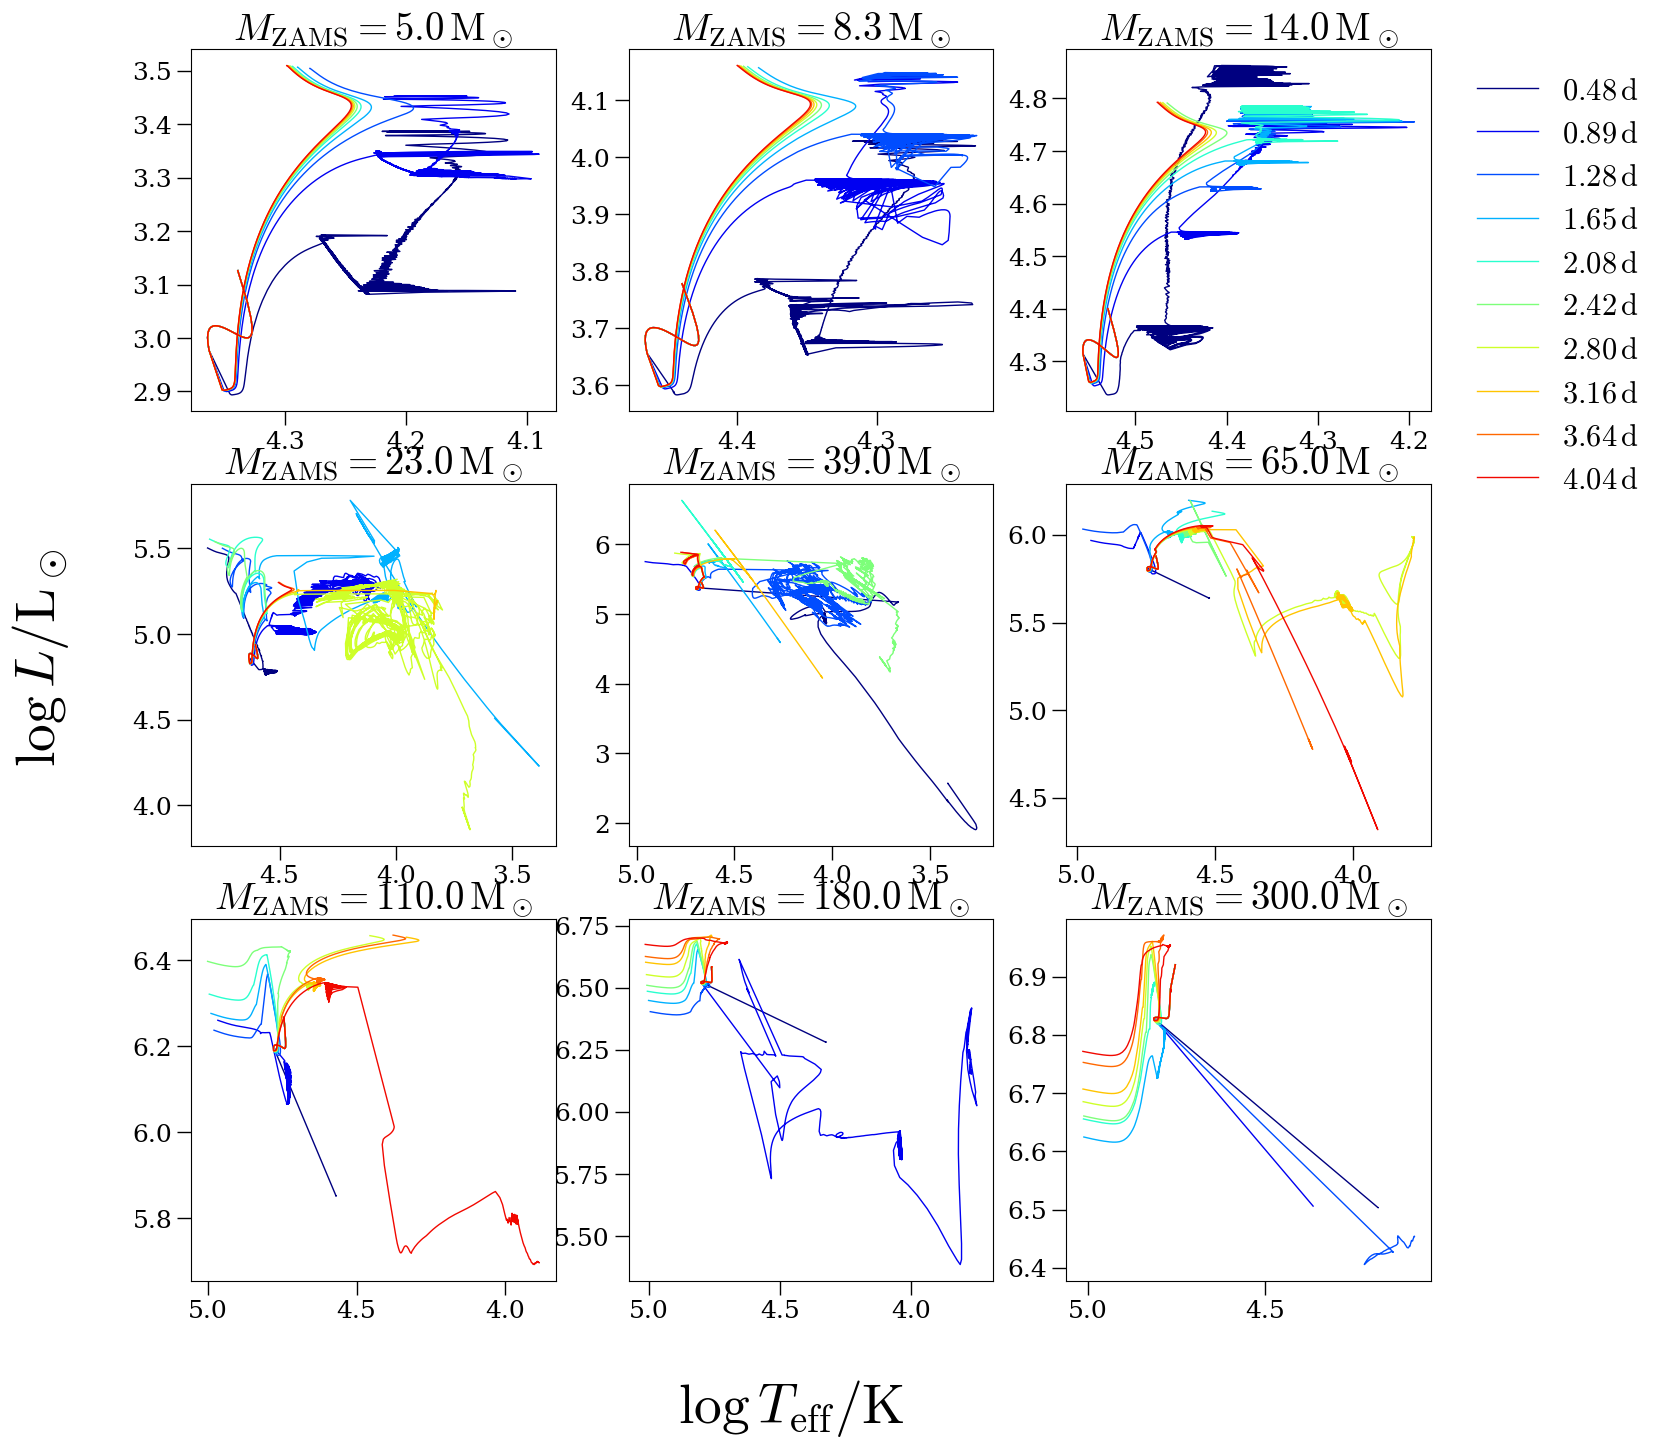

In [25]:
fig, axes = plt.subplots(3, 3, figsize=(16, 16))
cmap = cm.jet

counter = 1
for ax, m_key in zip(axes.flatten(), model_ms[1:]):
    m = float(m_key)
    w_models = model_dict[m_key]
    for w_i, w_key in enumerate(model_ws[::-1]):
        print(f'{counter} of 90')
        counter += 1
        c = cmap(w_i/len(model_ws))
        model = w_models[w_key]
        w = float(w_key)
        p = 2*np.pi / float(w) / (24*60*60)
        try:
            h = mr.MesaData(str(model/'LOGS/history.data'))
        except:
            continue
        
        ax.plot(h.log_Teff, h.log_L, c=c, lw=1, label=f'${p:.2f}\\,\\mathrm{{d}}$')
        ax.set_title(f'$M_\\mathrm{{ZAMS}}={m:.1f}\\,\\mathrm{{M}}_\\odot$')


handles, labels = axes[0, 0].get_legend_handles_labels()
axes[0, -1].legend(handles=handles, frameon=False, ncol=1, loc='upper left', bbox_to_anchor=(1.05, 1))
        
for ax in axes.flatten():
    ax.invert_xaxis()
    
fig.text(0.05, 0.5, '$\\log L/\\mathrm{L}_\\odot$', rotation=90, ha='right', va='center', fontsize=40,
         transform=fig.transFigure)
fig.text(0.5, 0.05, '$\\log T_\\mathrm{eff}/\\mathrm{K}$', ha='center', va='top', fontsize=40,
         transform=fig.transFigure)

fig_title = 'HR_panel'
fig.savefig(f'figures/{fig_title}.png', bbox_inches='tight')
fig.savefig(f'figures/{fig_title}.png', bbox_inches='tight')
fig.savefig(f'figures/{fig_title}.png', bbox_inches='tight')

In [10]:
from src.star import tau_es, fix_unit

In [11]:
def tau_es(tau_kh, m, r, w):
    tau_kh = fix_unit(tau_kh, u.yr)
    m = fix_unit(m, u.Msun)
    r = fix_unit(r, u.Rsun)
    w = fix_unit(w, 1/u.s)
    
    tes = tau_kh * ct.G * m / w**2 / r**3
    return tes.to(u.yr).value

3.0e+00 1.8e-05


2.022249034249082 1.3599130009494278 19.397717107423723
3.0e+00 2.0e-05
2.022249034249082 1.359975094767286 18.081965141245277
3.0e+00 2.3e-05
2.022249034249082 1.3600794625003596 16.47329215591006
3.0e+00 2.6e-05
2.022249034249082 1.3601872434830586 15.180406205318539
3.0e+00 3.0e-05
2.022249034249082 1.3603687660779595 13.799122020357558
3.0e+00 3.5e-05
2.022249034249082 1.3606325324051953 12.451459544645278
3.0e+00 4.4e-05
2.022249034249082 1.3612116031542862 10.689658729531157
3.0e+00 5.7e-05
2.022249034249082 1.3622890948575397 8.99530142967634
3.0e+00 8.2e-05
2.022249034249082 1.3734890215572209 7.058672890775114
3.0e+00 1.5e-04
2.022249034249082 1.379349866616101 4.719233348013636
5.0e+00 1.8e-05
2.555304753973519 1.8614753842640033 22.998536700595935
5.0e+00 2.0e-05
2.555304753973519 1.861596121873307 21.43854024763935
5.0e+00 2.3e-05
2.555304753973519 1.861801510409448 19.531247524088386
5.0e+00 2.6e-05
2.555304753973519 1.862035793988852 17.998361730378967
5.0e+00 3.0e-05
2.5

Text(0.5, 1.0, 'Never $\\Omega\\geq\\Omega_\\mathrm{crit}$?')

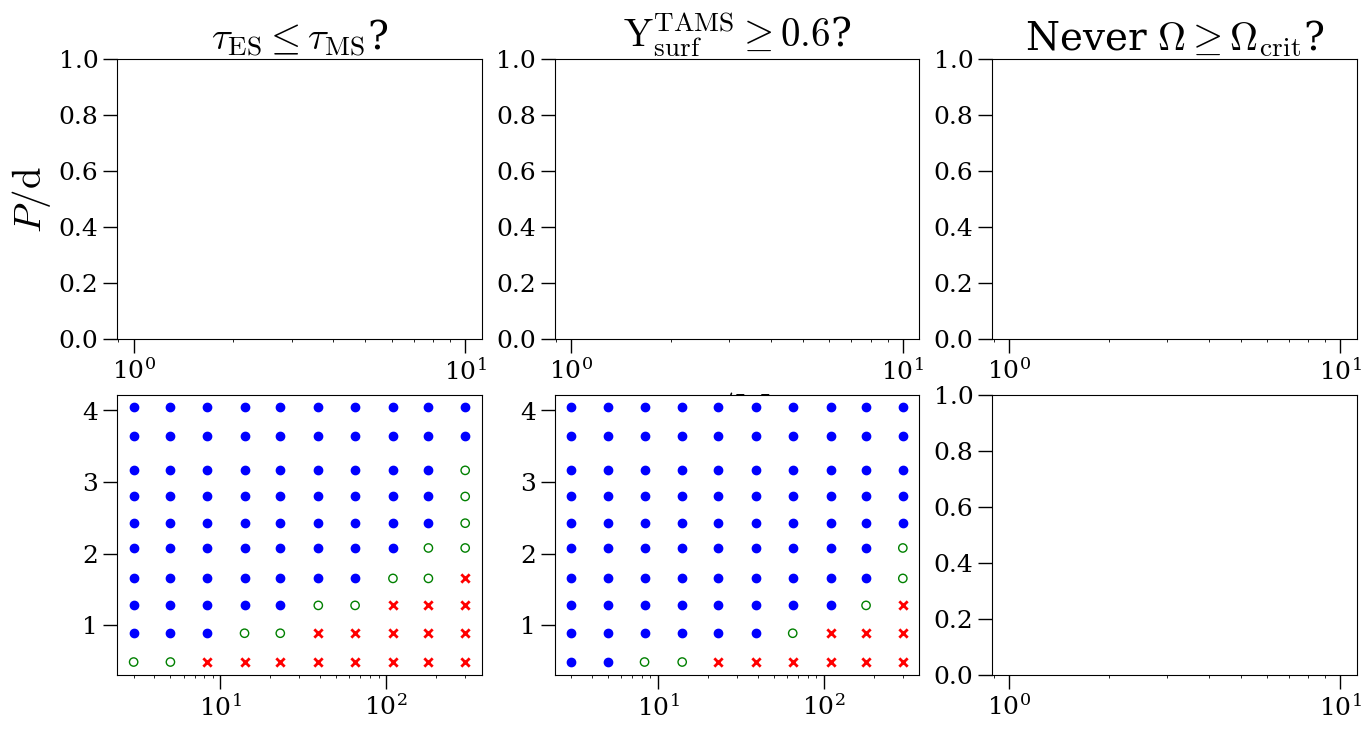

In [12]:
fig, axess = plt.subplots(2, 3, figsize=(16, 8))
axes = axess.flatten()

for m_key in model_ms:
    m = float(m_key)
    w_models = model_dict[m_key]
    for w_key in model_ws:
        print(m_key, w_key)
        model = w_models[w_key]
        w = float(w_key)
        p = 2 * np.pi / float(w) / (24*60*60)
        try:
            h = mr.MesaData(str(model/'LOGS/history.data'))
        except:
            continue
        tams_surf_he4 = h.surface_he4[-1]
        tams_t_kh = h.kh_timescale[-1]
        tams_r = h.radius[-1]
        tams_m = h.star_mass [-1]
        tams_v_rot =  h.surf_avg_v_rot[-1]
        tams_w = tams_v_rot/(2*np.pi*tams_r*u.Rsun.to(u.km)/(2*np.pi))
        tams_t_es = tau_es(tams_t_kh, tams_m, tams_r, tams_w)
        t_ms = h.star_age[-1]
        
        max_omega_div_omega_crit = np.max(h.surf_avg_omega_div_omega_crit)
        
        
        #if t_ms >= tams_t_es:
        #    axes[0].plot(m, p, 'b', linestyle='', marker='o')
        #else:
        #    axes[0].plot(m, p, 'r', linestyle='', marker='x')
            
        #if tams_surf_he4 >= 0.6:
        #    axes[1].plot(m, p, 'b', linestyle='', marker='o')
        #else:
        #    axes[1].plot(m, p, 'r', linestyle='', marker='x')
            
        #if max_omega_div_omega_crit >= 1:
        #    axes[2].plot(m, p, 'r', linestyle='', marker='x')
        #else:
        #    axes[2].plot(m, p, 'b', linestyle='', marker='o')
            
        zams_i = np.searchsorted(h.surf_avg_v_rot, 0, side='right')
        r_zams = h.radius[zams_i]
        r_prezams = h.radius[np.argmax(h.radius[:zams_i])]
        a = a_from_p(p, m, q=1.).to(u.Rsun).value
        rl_r = eggleton_rl1_radius(a, q=1.).to(u.Rsun).value
        l2_r = marchant_l2_radius(a, q=1.).to(u.Rsun).value
        
        print(r_prezams, r_zams, a)
        
        if r_prezams < rl_r:
            axes[3].scatter(m, p, marker='o', color='b')
        elif r_zams < rl_r:
            axes[3].scatter(m, p, marker='o', edgecolors='g', facecolors='none')
        else:
            axes[3].scatter(m, p, marker='x', color='r')
            
        if r_prezams < l2_r:
            axes[4].scatter(m, p, marker='o', color='b')
        elif r_zams < l2_r:
            axes[4].scatter(m, p, marker='o', edgecolors='g', facecolors='none')
        else:
            axes[4].scatter(m, p, marker='x', color='r')
            
for ax in axes:
    ax.set_xscale('log')
    #ax.set_yscale('log')
    
axes[1].set_xlabel('$M/\\mathrm{M}_\\odot$')
axes[0].set_ylabel('$P/\\mathrm{d}$')

axes[0].set_title('$\\tau_\\mathrm{ES}\leq\\tau_\\mathrm{MS}$?')
axes[1].set_title('$\\mathrm{Y}_\\mathrm{surf}^\\mathrm{TAMS}\\geq0.6$?')
axes[2].set_title('Never $\\Omega\\geq\\Omega_\\mathrm{crit}$?')
        

Color code - final Y surface  
Marker   
    - no of - star  
    - of pre-zams - closed circle  
    - of at zams - open circle  
    - merger pre zams - x  
One panel for RLOF, another for L2OF  


/tmp/ipykernel_2062494/1442985349.py:9: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=0.05)


Running 1 of 100 (3.0e+00, 1.8e-05)
Running 2 of 100 (3.0e+00, 2.0e-05)
Running 3 of 100 (3.0e+00, 2.3e-05)
Running 4 of 100 (3.0e+00, 2.6e-05)
Running 5 of 100 (3.0e+00, 3.0e-05)
Running 6 of 100 (3.0e+00, 3.5e-05)
Running 7 of 100 (3.0e+00, 4.4e-05)
Running 8 of 100 (3.0e+00, 5.7e-05)
Running 9 of 100 (3.0e+00, 8.2e-05)
Running 10 of 100 (3.0e+00, 1.5e-04)
Running 11 of 100 (5.0e+00, 1.8e-05)
Running 12 of 100 (5.0e+00, 2.0e-05)
Running 13 of 100 (5.0e+00, 2.3e-05)
Running 14 of 100 (5.0e+00, 2.6e-05)
Running 15 of 100 (5.0e+00, 3.0e-05)
Running 16 of 100 (5.0e+00, 3.5e-05)
Running 17 of 100 (5.0e+00, 4.4e-05)
Running 18 of 100 (5.0e+00, 5.7e-05)
Running 19 of 100 (5.0e+00, 8.2e-05)
Running 20 of 100 (5.0e+00, 1.5e-04)
Running 21 of 100 (8.3e+00, 1.8e-05)
Running 22 of 100 (8.3e+00, 2.0e-05)
Running 23 of 100 (8.3e+00, 2.3e-05)
Running 24 of 100 (8.3e+00, 2.6e-05)
Running 25 of 100 (8.3e+00, 3.0e-05)
Running 26 of 100 (8.3e+00, 3.5e-05)
Running 27 of 100 (8.3e+00, 4.4e-05)
Running 28

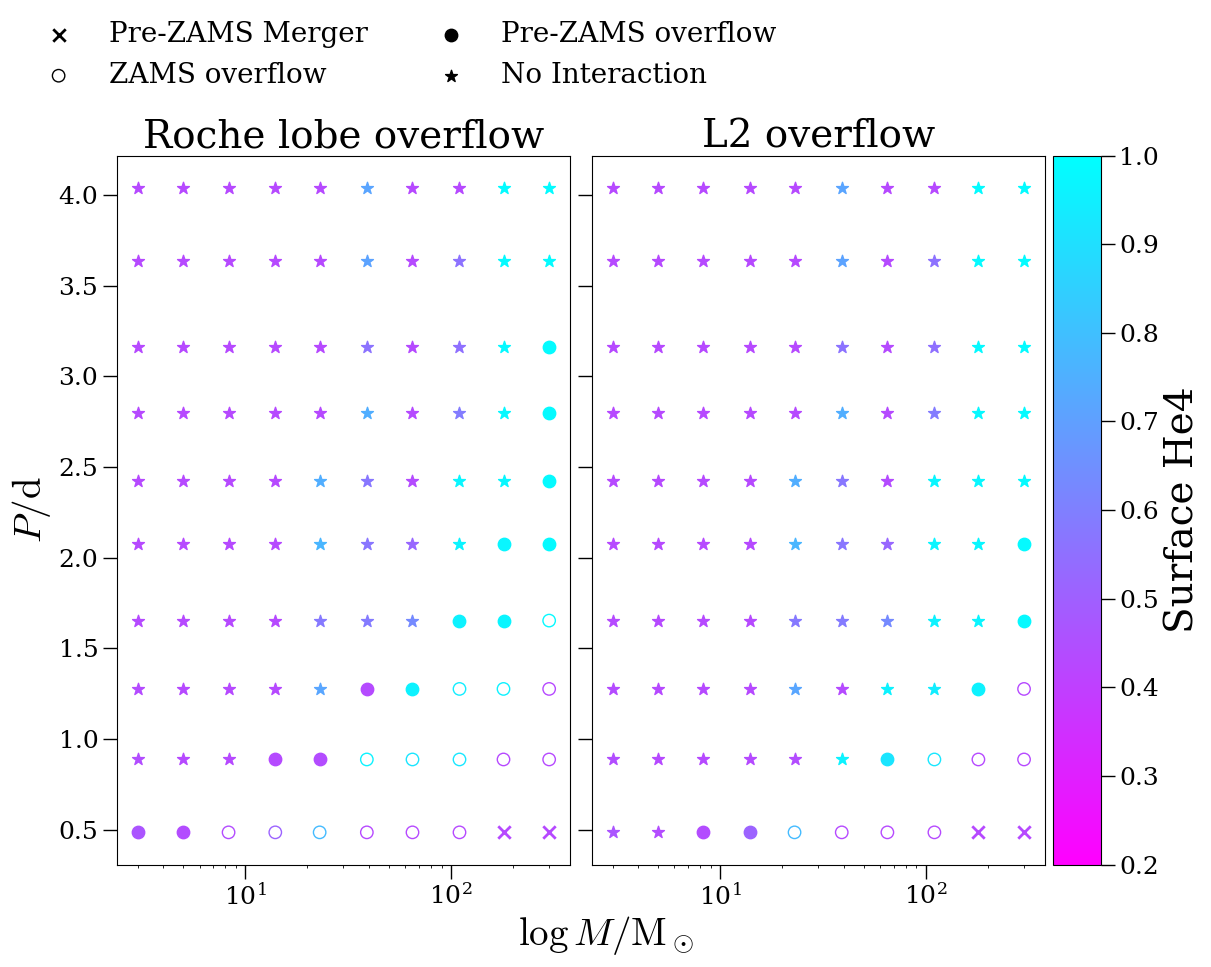

In [13]:
fig = plt.figure(figsize=(12, 8), constrained_layout=True)
gs = fig.add_gridspec(ncols=3, nrows=1, width_ratios=[0.475, 0.475, 0.05])
cmap = cm.cool_r

rl_ax = fig.add_subplot(gs[0, 0])
l2_ax = fig.add_subplot(gs[0, 1], sharex=rl_ax)
cb_ax = fig.add_subplot(gs[0, 2])

fig.subplots_adjust(wspace=0.05)

counter = 1
for m_key in model_ms:
    m = float(m_key)
    w_models = model_dict[m_key]
    for w_key in model_ws:
        print(f'Running {counter} of 100 ({m_key}, {w_key})')
        model = w_models[w_key]
        w = float(w_key)
        p = 2 * np.pi / float(w) / (24*60*60)
        try:
            h = mr.MesaData(str(model/'LOGS/history.data'))
        except:
            continue
        tams_surf_he4 = h.surface_he4[-1]
        color = cmap(tams_surf_he4)

        zams_i = np.searchsorted(h.surf_avg_v_rot, 0, side='right')
        r_zams = h.radius[zams_i]
        r_prezams = h.radius[np.argmax(h.radius[:zams_i])]
        a = a_from_p(p, m, q=1.).to(u.Rsun).value
        rl_r = eggleton_rl1_radius(a, q=1.).to(u.Rsun).value
        l2_r = marchant_l2_radius(a, q=1.).to(u.Rsun).value
               
        if r_prezams > a:
            rl_ax.scatter(m, p, marker='x', color=color, s=80)
        elif r_zams > rl_r:
            rl_ax.scatter(m, p, marker='o', edgecolors=color, facecolors='none', s=80)
        elif r_prezams > rl_r:
            rl_ax.scatter(m, p, marker='o', color=color, s=80)
        else:
            rl_ax.scatter(m, p, marker='*', color=color, s=80)
        
        if r_prezams > a:
            l2_ax.scatter(m, p, marker='x', color=color, s=80)
        elif r_zams > l2_r:
            l2_ax.scatter(m, p, marker='o', edgecolors=color, facecolors='none', s=80)
        elif r_prezams > l2_r:
            l2_ax.scatter(m, p, marker='o', color=color, s=80)
        else:
            l2_ax.scatter(m, p, marker='*', color=color, s=80)
            
        counter += 1
rl_ax.set_xscale('log')
fig.text(0.5, 0, '$\\log M/\\mathrm{M}_\\odot$', ha='center', va='top', transform=fig.transFigure)

rl_ax.set_ylabel('$P/\\mathrm{d}$')
l2_ax.set_yticks(rl_ax.get_yticks())
l2_ax.set_yticklabels([])
l2_ax.set_ylim(rl_ax.get_ylim())

rl_ax.set_title('Roche lobe overflow')
l2_ax.set_title('L2 overflow')
        
cb = plt.colorbar(mappable=ScalarMappable(Normalize(vmin=0.2, vmax=1), cmap=cmap), cax=cb_ax)
cb_label = cb.set_label('Surface He4')    

handles = []
handles.append(plt.scatter([], [], marker='x', color='k', label='Pre-ZAMS Merger', s=80))
handles.append(plt.scatter([], [], marker='o', facecolors='none', edgecolors='k', label='ZAMS overflow', s=80))
handles.append(plt.scatter([], [], marker='o', color='k', label='Pre-ZAMS overflow', s=80))
handles.append(plt.scatter([], [], marker='*', color='k', label='No Interaction', s=80))
fig.legend(handles=handles, frameon=False, loc='lower left', bbox_to_anchor=(0, 1), ncol=2, fontsize=20)

fig_title = 'che_window'
fig.savefig(f'figures/{fig_title}.png', bbox_inches='tight')
fig.savefig(f'figures/{fig_title}.png', bbox_inches='tight')
fig.savefig(f'figures/{fig_title}.png', bbox_inches='tight')